# Imports

In [1]:
import warnings; warnings.simplefilter('ignore')
import re
import pandas as pd 
import seaborn as sns 
import textwrap
import matplotlib.pyplot as plt 
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import mixedlm
import numpy as np
from utils import *

pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 20)
plt.style.use("style.mplstyle")

# Prepare data

In [2]:
# get performance of chatgpt
output_review = get_gpt_review_df()
output_review['question'] = output_review['Patient History'].map({TASKS[key]: key for key in TASKS})
output_review['vignette-length'] = output_review['Patient History'].str.split().apply(lambda x: len(x))

# format 'Level of info about images in text'
output_review.rename({'Level of info about images in text': 'Image information in text'},inplace=True,axis=1)
output_review['Image information in text'] = output_review['Image information in text'].fillna('None')

# get number of words in AI advice
output_review['differential advice length'] = output_review['Differential Diagnosis'].str.split().apply(lambda x: len(x))
output_review['chain-of-thought advice length'] = output_review['Chain-of-Thought Reasoning'].str.split().apply(lambda x: len(x))
output_review['standard advice length'] = output_review['Standard'].str.split().apply(lambda x: len(x))

In [3]:
df = pd.read_excel('../Data/data_evaluated.xlsx')
df = df.rename({f'judgement_rad': 'judgement', 'cognitive-load': 'task-load'},axis=1)

df['original_judgement'] = df.judgement
df['judgement'] = df.judgement.replace('Partial','No') 

df['correctness'] = df.judgement.map({'Yes': 1, 'No': 0},)
df['condition'] = df.condition.map(map_condition)
df['condition'] = pd.Categorical(df.condition, categories=['control', 'standard', 'differential','chain-of-thought',])


In [4]:
df['StartDate']

0      2024-11-21 12:45:03
1      2024-11-21 15:37:29
2      2024-11-21 15:58:22
3      2024-11-21 16:37:23
4      2024-11-21 21:47:59
               ...        
2015   2024-11-28 20:03:49
2016   2024-11-28 22:32:55
2017   2024-11-28 22:37:49
2018   2024-11-29 17:42:08
2019   2024-12-01 05:14:47
Name: StartDate, Length: 2020, dtype: datetime64[ns]

In [5]:
def calc_stats(df_eval):
    # df_eval['corr'] = df_eval.judgement_rad.str.replace('Partial','No').map({'Yes':1,'No':0})
    df_eval = df_eval.groupby('ResponseId')
    df_eval =  df_eval.agg({'correctness':'mean','condition':'first'})
    # df_eval['condition'] = df_eval.condition.apply(map_condition)
    return df_eval.groupby('condition')['correctness'].describe()
    
calc_stats(df)

count      mean       std   min     25%   50%     75%   max
condition                                                                    
control            24.0  0.616667  0.157195  0.35  0.5375  0.60  0.7125  0.90
standard           24.0  0.666667  0.132424  0.20  0.6000  0.70  0.7500  0.85
differential       30.0  0.641667  0.105114  0.40  0.6000  0.65  0.6500  0.95
chain-of-thought   23.0  0.739130  0.063883  0.65  0.7000  0.75  0.8000  0.85

In [6]:
rel_cols = [
 'question',
 'Image information in text',
 'Rank of Correct Diagnosis',
 'differential diagnosis correct',
 'differential explanation correct',
 'chain-of-thought diagnosis correct',
 'chain-of-thought explanation correct',
 'standard diagnosis correct',
 'standard explanation correct',
 'vignette-length',
 'differential advice length',
 'chain-of-thought advice length',
 'standard advice length'
 ]

output_review['Image information in text'] = pd.Categorical(output_review['Image information in text'])
output_review['Rank of Correct Diagnosis'] = pd.Categorical(output_review['Rank of Correct Diagnosis'])

advice_df = output_review[rel_cols]

In [7]:
explanation_df = advice_df[
    ['question','differential explanation correct','chain-of-thought explanation correct','standard explanation correct']
]
explanation_df = explanation_df.melt(id_vars='question',value_name='Explanation correctness',var_name='condition')
explanation_df['condition'] = explanation_df['condition'].apply(lambda x: x.split(' ')[0])
explanation_df

question     condition Explanation correctness
0    question_1  differential                      No
1    question_2  differential                     Yes
2    question_3  differential                      No
3    question_4  differential                      No
4    question_5  differential                      No
..          ...           ...                     ...
55  question_16      standard                     Yes
56  question_17      standard                     Yes
57  question_18      standard                     Yes
58  question_19      standard                     Yes
59  question_20      standard                     Yes

[60 rows x 3 columns]

In [8]:
diagnosis_df = advice_df[
    ['question','differential diagnosis correct','chain-of-thought diagnosis correct','standard diagnosis correct']
]

diagnosis_df = diagnosis_df.melt(id_vars='question',value_name='Diagnosis correctness',var_name='condition')
diagnosis_df['condition'] = diagnosis_df['condition'].apply(lambda x: x.split(' ')[0])
diagnosis_df

question     condition Diagnosis correctness
0    question_1  differential                   Yes
1    question_2  differential                   Yes
2    question_3  differential                   Yes
3    question_4  differential                   Yes
4    question_5  differential                   Yes
..          ...           ...                   ...
55  question_16      standard                   Yes
56  question_17      standard                   Yes
57  question_18      standard                   Yes
58  question_19      standard                   Yes
59  question_20      standard                   Yes

[60 rows x 3 columns]

In [9]:
length_df = advice_df[
    ['question','differential advice length','chain-of-thought advice length','standard advice length']
]

length_df = length_df.melt(id_vars='question',value_name='advice-length',var_name='condition')
length_df['condition'] = length_df['condition'].apply(lambda x: x.split(' ')[0])
length_df

question     condition  advice-length
0    question_1  differential            178
1    question_2  differential            209
2    question_3  differential            244
3    question_4  differential            200
4    question_5  differential            198
..          ...           ...            ...
55  question_16      standard             44
56  question_17      standard             49
57  question_18      standard             61
58  question_19      standard             72
59  question_20      standard             78

[60 rows x 3 columns]

In [10]:
agg_fns = {'correctness': 'mean','task-load': 'mean', 'usefulness':'mean', 
           'ease-of-use': 'mean', 'trust':'mean','condition': 'first'}

df_agg = df.groupby('ResponseId').agg(agg_fns)


participant_vars = df.set_index('ResponseId') \
    .drop(['question','answer','judgement','ground_truth', 'original_judgement']+list(agg_fns.keys()),axis=1) \
    .drop_duplicates()


participant_vars.head(3)

StartDate             EndDate  Status  \
ResponseId                                                          
R_7Bl1xOlCKLlDuUk 2024-11-21 12:45:03 2024-11-21 13:49:31       0   
R_3L27f1b3klEk0fL 2024-11-21 15:37:29 2024-11-21 16:00:10       0   
R_6jkMqDRXLPUtGyd 2024-11-21 15:58:22 2024-11-21 16:26:07       0   

                        IPAddress  Progress  Duration (in seconds)  Finished  \
ResponseId                                                                     
R_7Bl1xOlCKLlDuUk   104.28.55.217       100                   3867         1   
R_3L27f1b3klEk0fL  108.20.119.209       100                   1361         1   
R_6jkMqDRXLPUtGyd   12.48.162.126       100                   1665         1   

                             RecordedDate  RecipientLastName  \
ResponseId                                                     
R_7Bl1xOlCKLlDuUk 2024-11-21 13:49:32.147                NaN   
R_3L27f1b3klEk0fL 2024-11-21 16:00:12.019                NaN   
R_6jkMqDRXLPUtGyd 2024-11-21 16:26:08.667                NaN   

                   RecipientFirstName  ...  t_dd11  t_dd12  t_dd13  t_dd14  \
ResponseId                             ...                                   
R_7Bl1xOlCKLlDuUk                 NaN  ...       0       0       0       0   
R_3L27f1b3klEk0fL                 NaN  ...       0       0       0       0   
R_6jkMqDRXLPUtGyd                 NaN  ...       0       0       0       0   

                  t_dd15 t_dd16 t_dd17 t_dd18 t_dd19 t_dd20  
ResponseId                                                   
R_7Bl1xOlCKLlDuUk      0      0      0      0      0      0  
R_3L27f1b3klEk0fL      0      0      0      0      0      0  
R_6jkMqDRXLPUtGyd      0      0      0      0      0      0  

[3 rows x 597 columns]

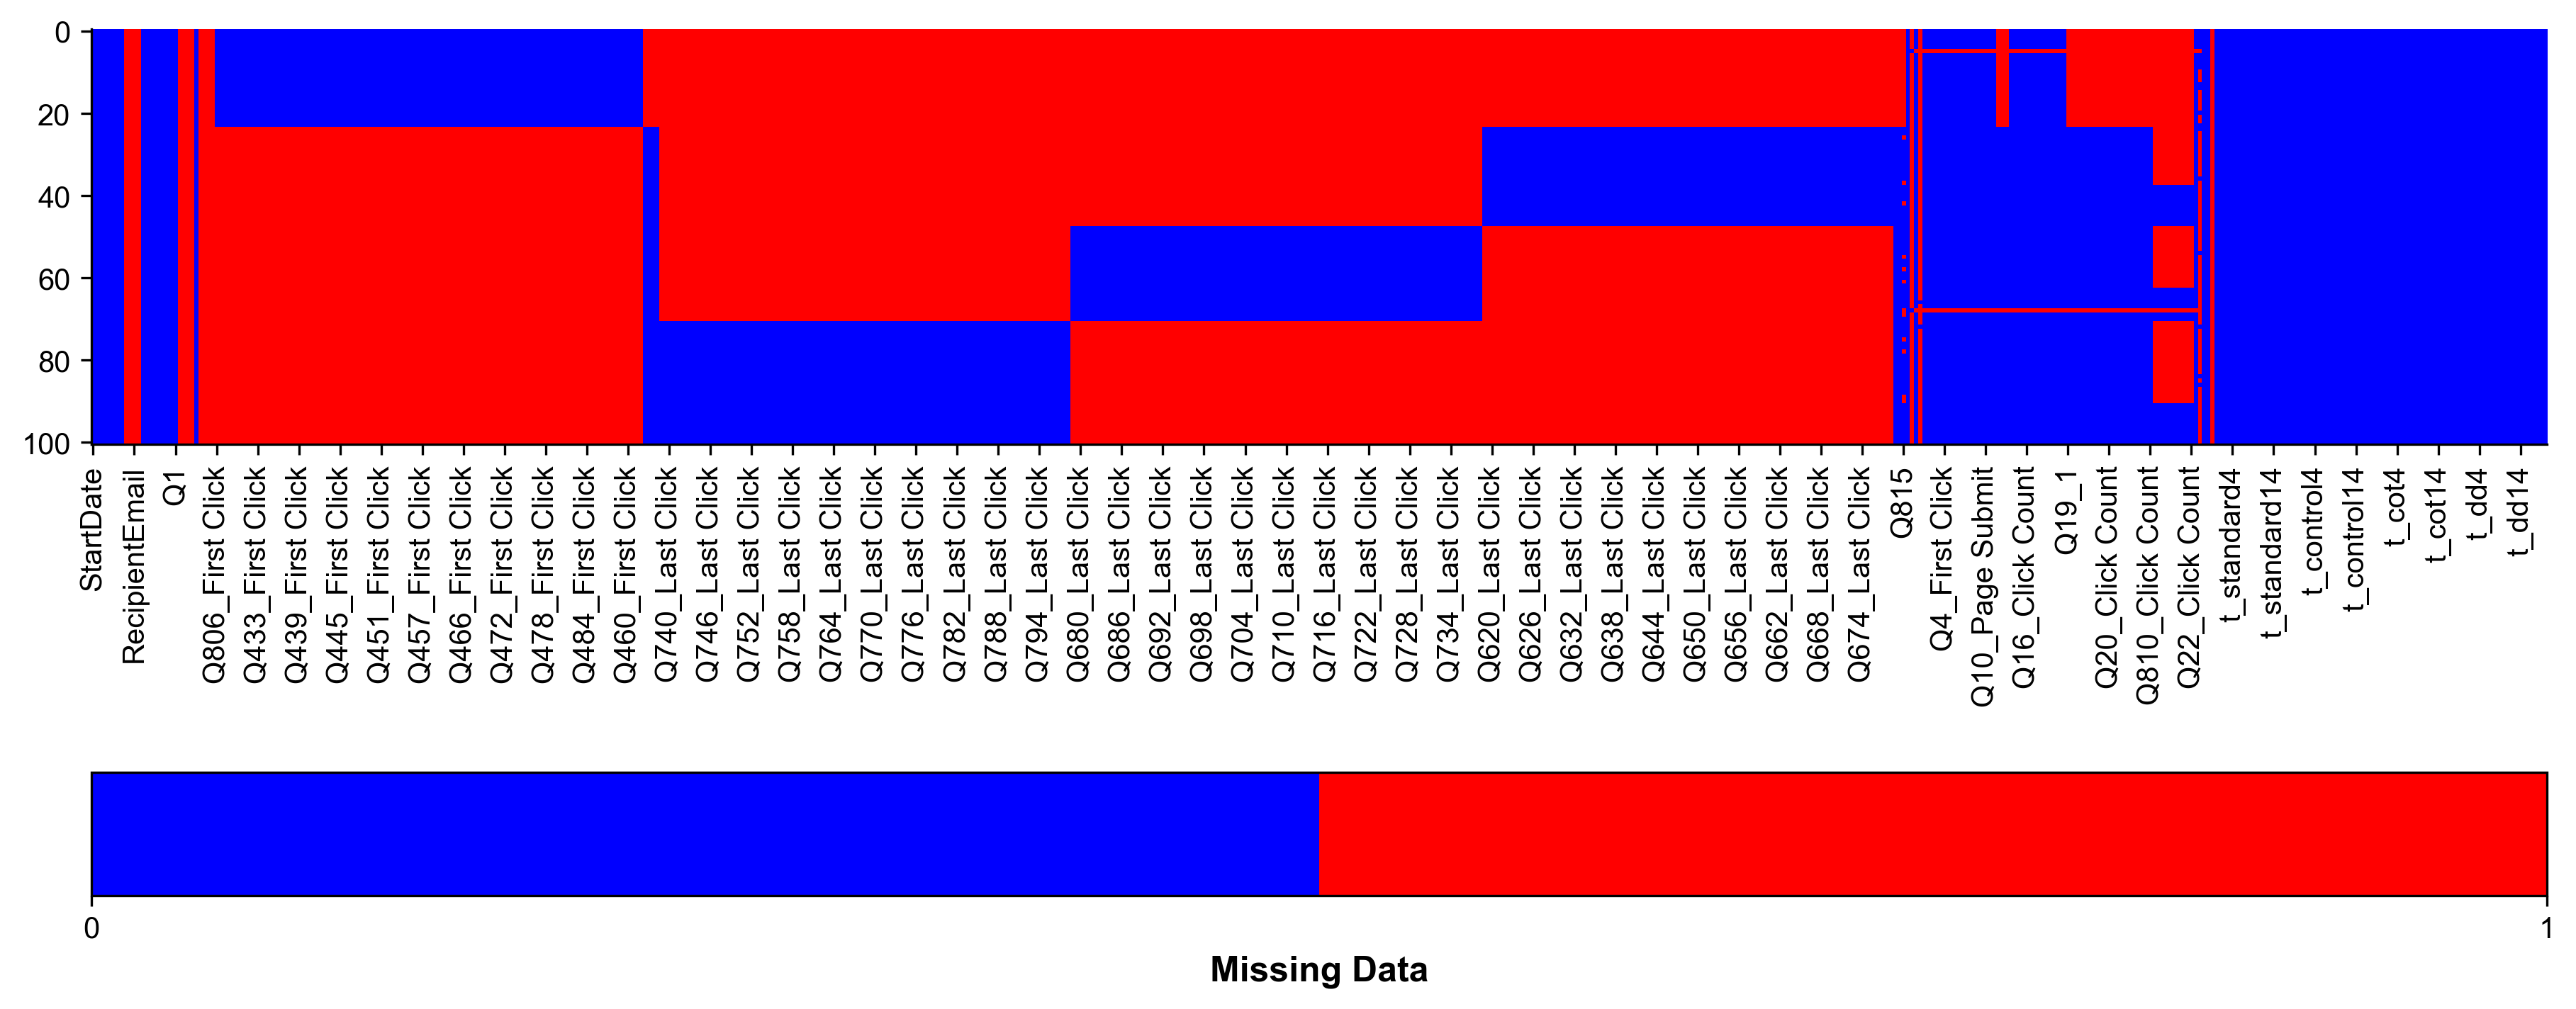

In [11]:
def plot_nans(data,orientation='horizontal',step=10,fsize=(12, 8),legend=True):
    import matplotlib.colors as mcolors
    cmap = mcolors.ListedColormap(['blue', 'red'])
    plt.figure(figsize=fsize)
    plt.imshow(data.isna(), cmap=cmap)
    if legend:
        plt.colorbar(ticks=[0, 1], label='Missing Data', orientation=orientation)
    plt.xticks(ticks=np.arange(data.shape[1])[::step], labels=data.columns[::step], rotation=90)
    
plot_nans(participant_vars)

In [12]:
df_reg = pd.merge(left=df_agg, right=participant_vars, how='left', 
                  validate='1:m', left_index=True, right_index=True)

col_name_changes = {
    'Q818_Browser': 'Browser',
    'Q818_Version': 'Version',
    'Q818_Operating System': 'Operating System',
    'Q818_Resolution': 'Resolution',
    'Q9_1': 'Helpfulness', 
    'Q5_1': 'GenAI-Experience',
    'Q1.1': 'Specialization',
    'Q3.1': 'medical-experience',
    'Q246_1': 'radiology-experience',
    'Q7_1': 'weekly-inspection-time',
    'Q8_1': 'IT-skills',
    'Q245_1': 'medical-AI-experience',
    'Q11': 'Estimated-Correct-Diagnosis',
    'Q12': 'Estimated-Correct-Diagnosis-AI',
    'Q13_1': 'AI-Performance-Expectations',
    'Q14_1': 'AI-Bad-Estimate-Rating',
    'Q15_1': 'Own-Success-Rating',
    'Q19_7': 'Attention-Check',
    'Q808': 'assistive-tools',
}

df_reg.rename(col_name_changes, axis=1, inplace=True)
df.rename(col_name_changes, axis=1, inplace=True)

In [13]:
# convert scales 
df['Helpfulness'] = (df['Helpfulness'] - 1) / 7 * 100
df['GenAI-Experience'] = (df['GenAI-Experience'] - 1) / 7 * 100
df['radiology-experience'] = (df['radiology-experience'] - 1) / 7 * 100
df['medical-AI-experience'] = (df['medical-AI-experience'] - 1) / 7 * 100

df_reg['Helpfulness'] = (df_reg['Helpfulness'] - 1) / 7 * 100
df_reg['GenAI-Experience'] = (df_reg['GenAI-Experience'] - 1) / 7 * 100
df_reg['radiology-experience'] = (df_reg['radiology-experience'] - 1) / 7 * 100
df_reg['medical-AI-experience'] = (df_reg['medical-AI-experience'] - 1) / 7 * 100

In [14]:
map_inspection_time = {
    1: '<30h',
    2: '30-35h',
    3: '35-40h',
    4: '40-45h',
    5: '45-50h',
    6: '50-55h',
    7: '>55h',    
}

df['weekly-inspection-time'] = pd.Categorical(
    df['weekly-inspection-time'].map(map_inspection_time), 
    categories=map_inspection_time.values(),)

df_reg['weekly-inspection-time'] = pd.Categorical(
    df_reg['weekly-inspection-time'].map(map_inspection_time), 
    categories=map_inspection_time.values(),)

In [15]:
conds = df.condition.unique()
times_cols = [c for c in df_reg.columns if c.startswith('t_')]

condition_to_times_col = {
    'chain-of-thought': 'cot',
    'differential': 'dd',
    'standard': 'standard',
    'control': 'control'
}

dfs = []
for cond in ['control', 'standard', 'differential', 'chain-of-thought']:
    dfs.append(df[['ResponseId','condition']+[c for c in times_cols if condition_to_times_col[cond] in c]].query(f'condition == "{cond}"') \
        .melt(id_vars=['ResponseId','condition'],value_name='time-per-case',var_name='question') \
        .drop_duplicates())
    
time_per_case_df = pd.concat(dfs, axis=0)
def extract_number_from_end(input_string):
    match = re.search(r'\d+$', input_string)
    return int(match.group())

time_per_case_df['question'] = time_per_case_df.question.apply(lambda o: f"question_{extract_number_from_end(o)}")
time_per_case_df['time-per-case'] = time_per_case_df['time-per-case'] / 1000 / 60 # convert to minutes
time_per_case_df

ResponseId         condition     question  time-per-case
0     R_7Bl1xOlCKLlDuUk           control   question_1       0.994783
1     R_3L27f1b3klEk0fL           control   question_1       1.732950
2     R_6jkMqDRXLPUtGyd           control   question_1       0.456383
3     R_3o5eW5zH6mVOqJt           control   question_1       0.170583
4     R_3lBxjyrPfIoDrBD           control   question_1       0.713000
...                 ...               ...          ...            ...
8758  R_6EXinQzIT4hp6wN  chain-of-thought  question_20       0.185717
8759  R_5SkPVlMWl5baMZb  chain-of-thought  question_20       0.767867
8760  R_5QrOVEBEzc0VezC  chain-of-thought  question_20       0.243383
8761  R_6BATA1iqcEDTJBL  chain-of-thought  question_20       0.894650
8762  R_5j7FJW0Fb8gXaTQ  chain-of-thought  question_20       0.397383

[2020 rows x 4 columns]

In [16]:
def nans(df): return df.isna().sum()
nans(time_per_case_df)

ResponseId       0
condition        0
question         0
time-per-case    0
dtype: int64

In [17]:
df_reg['condition'] = pd.Categorical(df_reg['condition'], categories=['control', 'standard', 'differential', 'chain-of-thought'])
df_reg['assistive-tools'] = pd.Categorical(df_reg['assistive-tools'])
df_reg['Specialization'] = pd.Categorical(df_reg['Specialization'])

map_assistive_tools = {1: 'Yes', 2: 'No'}
df_reg['assistive-tools'] = df_reg['assistive-tools'].map(map_assistive_tools)


df_reg['total-time'] = df_reg[times_cols].sum(axis=1) / 1000 / 60
# df['total-time'] = df[times_cols].sum(axis=1) / 1000 / 60
df = df.merge(time_per_case_df,how='left',on=['ResponseId','condition','question'],validate='1:1')

map_it_skills = {8: 'Beginner', 1: 'Novice', 2: 'Basic', 3: 'Good', 4: 'Very Good', 9: 'Advanced', 5: 'Expert'}
df_reg['IT-skills'] = df_reg['IT-skills'].map(map_it_skills)
df_reg['IT-skills'] = pd.Categorical(df_reg['IT-skills'], categories=['Basic', 'Good','Very Good', 'Advanced', 'Expert'])

df['IT-skills'] = df['IT-skills'].map(map_it_skills)
df['IT-skills'] = pd.Categorical(df['IT-skills'], categories=['Basic', 'Good','Very Good', 'Advanced', 'Expert'])

df_reg.head(3)

correctness  task-load  usefulness  ease-of-use  trust  \
ResponseId                                                                  
R_10vjyyr8j51riwX         0.60       50.0   69.444444    66.666667    NaN   
R_1CE2eg81xyyBnNy         0.40       50.0         NaN          NaN    NaN   
R_1CsZuXiqwalCXnP         0.85       20.0   66.666667    83.333333    NaN   

                      condition           StartDate             EndDate  \
ResponseId                                                                
R_10vjyyr8j51riwX  differential 2024-11-23 21:07:26 2024-11-23 21:30:34   
R_1CE2eg81xyyBnNy       control 2024-11-28 05:05:55 2024-11-28 05:17:38   
R_1CsZuXiqwalCXnP      standard 2024-11-24 15:55:16 2024-11-24 16:43:26   

                   Status      IPAddress  ...  t_dd12  t_dd13  t_dd14 t_dd15  \
ResponseId                                ...                                  
R_10vjyyr8j51riwX       0    73.76.76.59  ...   48491   76403  154022  42699   
R_1CE2eg81xyyBnNy       0   73.245.79.36  ...       0       0       0      0   
R_1CsZuXiqwalCXnP       0  104.28.57.239  ...       0       0       0      0   

                   t_dd16  t_dd17  t_dd18  t_dd19  t_dd20  total-time  
ResponseId                                                             
R_10vjyyr8j51riwX   22213  117917   32680   80499   24215   19.425050  
R_1CE2eg81xyyBnNy       0       0       0       0       0    9.715983  
R_1CsZuXiqwalCXnP       0       0       0       0       0   41.672917  

[3 rows x 604 columns]

In [18]:
df = df.merge(explanation_df,how='left',on=['question','condition'],validate='m:1')
df = df.merge(diagnosis_df,how='left',on=['question','condition'],validate='m:1')
df = df.merge(length_df,how='left',on=['question','condition'],validate='m:1')

df = df.merge(advice_df[['question','Image information in text','Rank of Correct Diagnosis','vignette-length']],
              how='left',on=['question'],validate='m:1')

In [19]:
df.shape

(2020, 616)

In [20]:
df['advice-length'] = df['advice-length'].fillna(0)

df['Diagnosis correctness'] = pd.Categorical(df['Diagnosis correctness'])
df['Explanation correctness'] = pd.Categorical(df['Explanation correctness'])

df['assistive-tools'] = df['assistive-tools'].map({1:'Yes',2: 'No'})
df['assistive-tools'] = pd.Categorical(df['assistive-tools'])

df['question-order'] = df['question'].str.extract('_(\d+)').astype(int)

In [21]:
df_reg = df_reg.reset_index().merge(length_df.groupby('condition')['advice-length'].mean(), how='left',on='condition',validate='m:1')
df_reg['advice-length'] = df_reg['advice-length'].fillna(0)
df['answer-length'] = df['answer'].apply(lambda x: len(x))
df_reg = df_reg.merge(df.groupby('ResponseId').agg({'answer-length':'mean','condition':'first'}), how='left',on=['ResponseId','condition'],validate='1:1')

# Data exploration

## Randomization checks

In [22]:
df_checks = df_reg[['condition','medical-experience','medical-AI-experience','radiology-experience','weekly-inspection-time', 'IT-skills']].dropna(axis=0)

In [23]:
from scipy.stats import chi2_contingency, f_oneway

# Split the data into four groups based on the treatment arms
groups = ['control', 'standard', 'chain-of-thought', 'differential']
group_data = {group: df_checks[df_checks['condition'] == group] for group in groups}
results = {}

# Perform randomization checks for categorical variables
categorical_vars = ['IT-skills','radiology-experience','medical-experience', 'weekly-inspection-time']
for var in categorical_vars:
    contingency_table = pd.crosstab(df_checks[var], df_checks['condition'])
    chi2, p_value, _, _ = chi2_contingency(contingency_table,correction=True)
    print(f"Randomization check for {var}: p-value = {p_value:.3f}")
    results[var] = p_value


# Perform randomization checks for continuous variables
continuous_vars = ['medical-AI-experience', ]
for var in continuous_vars:
    group_values = [group_data[group][var] for group in groups]
    f_statistic, p_value = f_oneway(*group_values)
    print(f"Randomization check for {var}: p-value = {p_value:.3f}")
    results[var] = p_value

Randomization check for IT-skills: p-value = 0.608
Randomization check for radiology-experience: p-value = 0.015
Randomization check for medical-experience: p-value = 0.336
Randomization check for weekly-inspection-time: p-value = 0.211
Randomization check for medical-AI-experience: p-value = 0.688


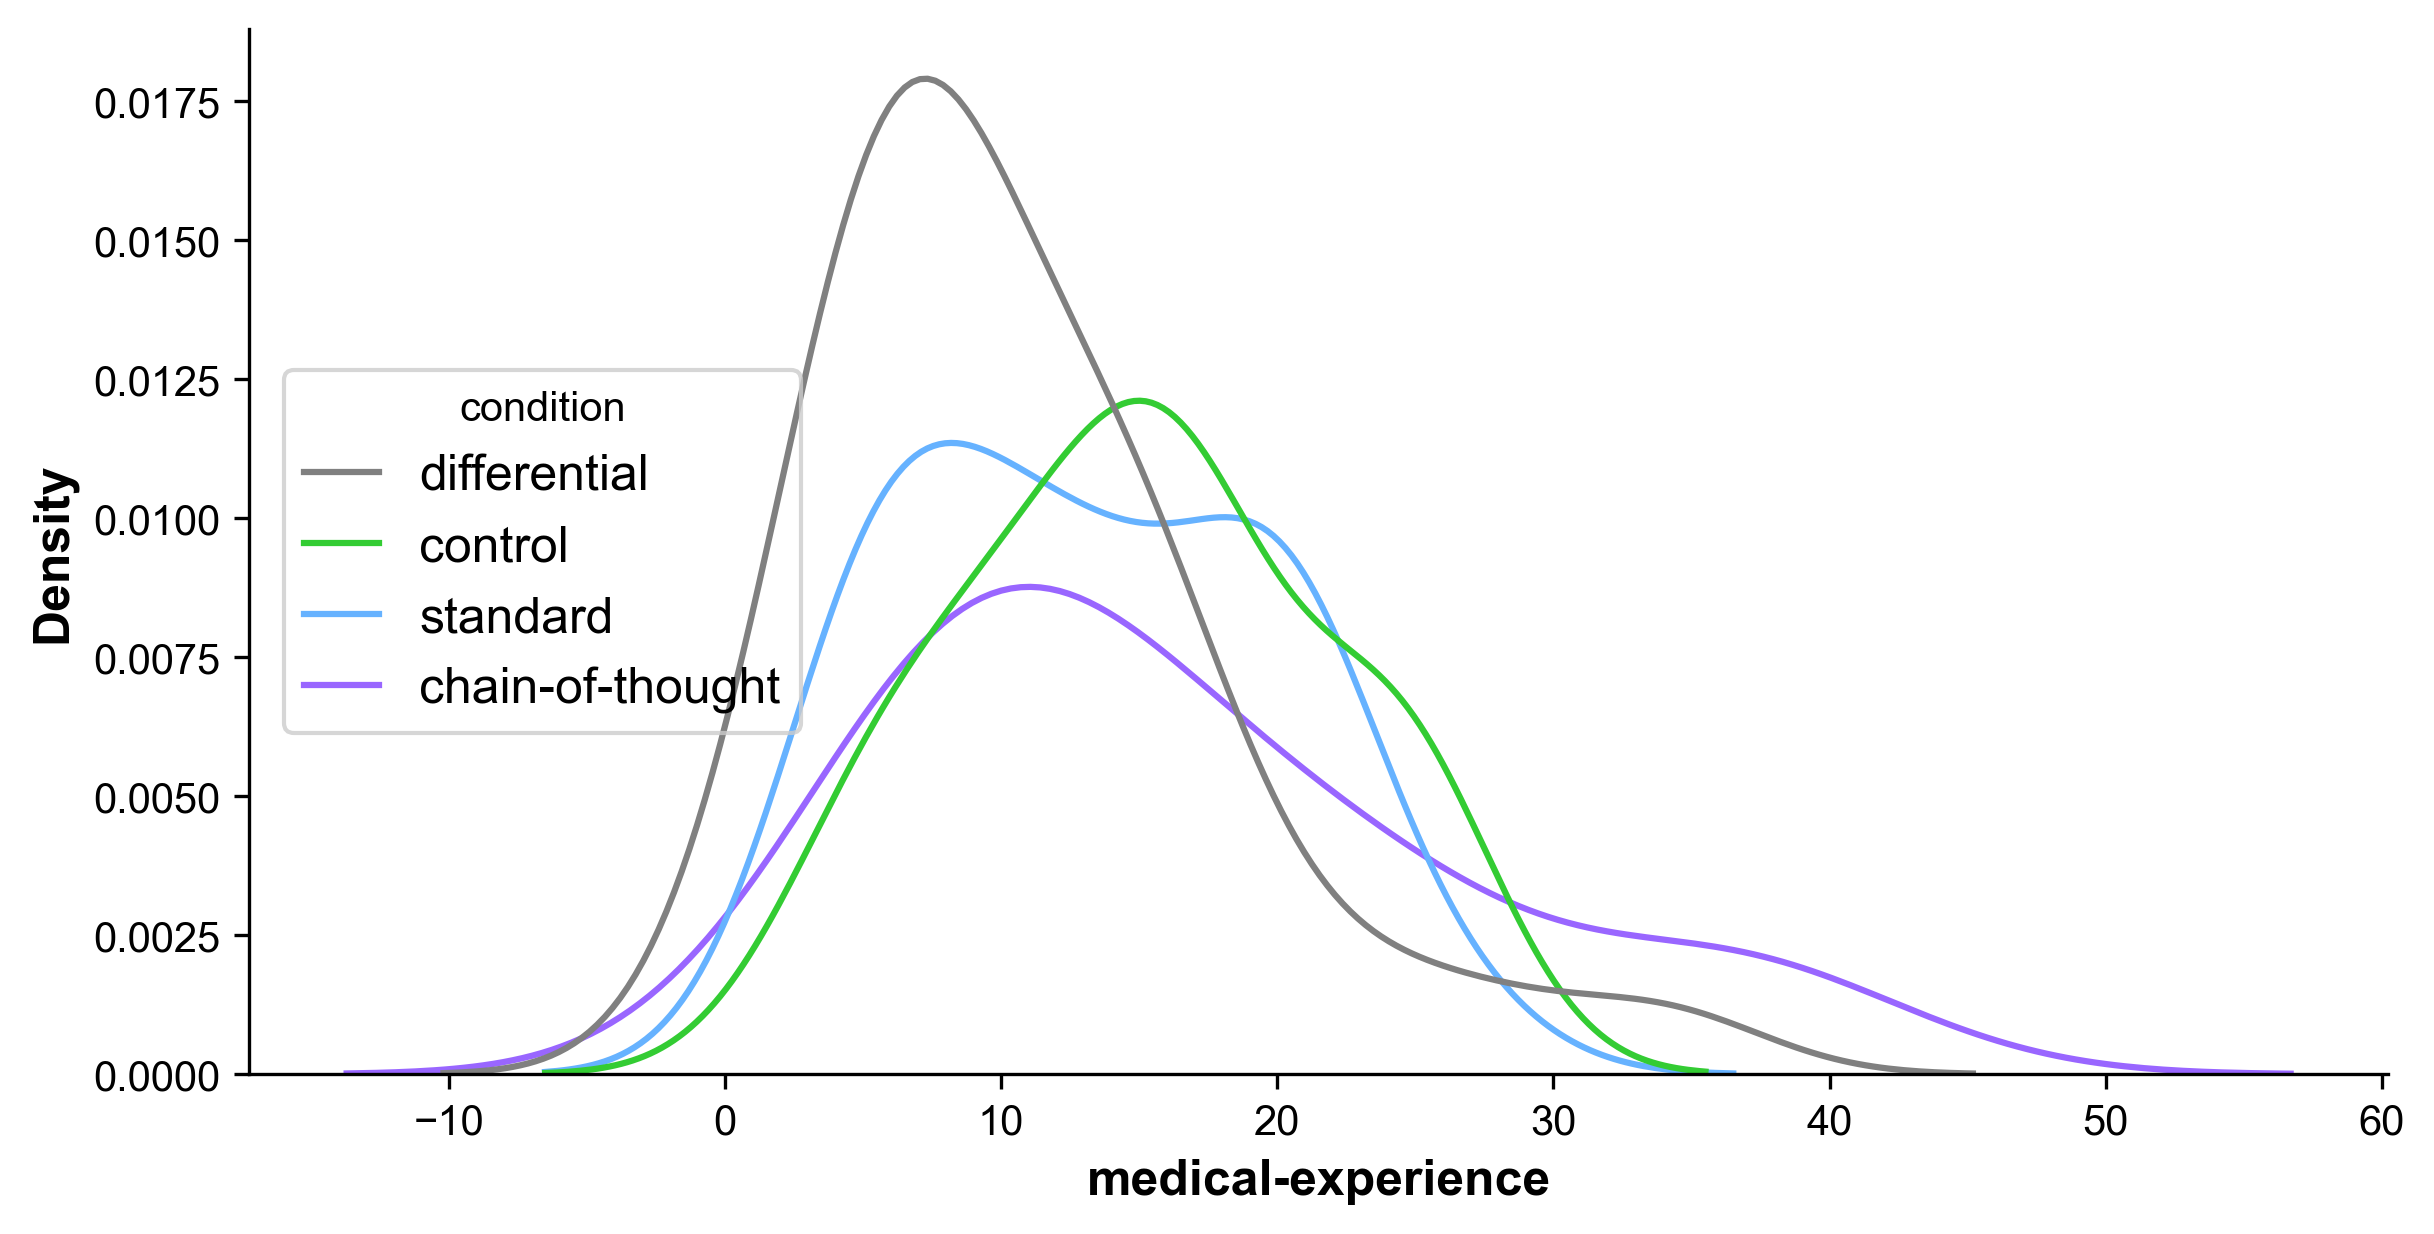

In [24]:
sns.kdeplot(df_checks,x='medical-experience', hue='condition');

## Sample description

In [25]:
df_demo = df_reg.copy()
df_demo['medical-AI-experience'] = (df_demo['medical-AI-experience'] / 100 * 7 + 1) # reverse for statistics
df_demo['radiology-experience'] = (df_demo['radiology-experience'] / 100 * 7 + 1)

In [26]:
demo_cols = ['condition','medical-experience','medical-AI-experience','radiology-experience',]
demo_table = df_demo[demo_cols].groupby('condition').agg(['mean','std']).loc[:,].T.round(3) 

demo_cat = df_demo[['condition','IT-skills','weekly-inspection-time']].groupby('condition').describe() \
    [[('IT-skills','top'),('IT-skills','freq'),('weekly-inspection-time','top'),('weekly-inspection-time','freq')]].loc[:,].T.round(3)

demo_table = pd.concat([demo_table,demo_cat],axis=0)[['control','standard','differential','chain-of-thought']] \
    .reset_index(names=['Variable','Statistic'])

In [27]:
demo_table

condition                Variable Statistic    control standard differential  \
0              medical-experience      mean     15.087   13.104         10.8   
1              medical-experience       std      6.557    6.617        7.364   
2           medical-AI-experience      mean        5.0      5.5        5.133   
3           medical-AI-experience       std      1.859    1.956        1.814   
4            radiology-experience      mean      5.739      6.0        5.967   
5            radiology-experience       std       1.01    0.933        0.964   
6                       IT-skills       top  Very Good     Good         Good   
7                       IT-skills      freq         10        8            9   
8          weekly-inspection-time       top     45-50h     >55h       35-40h   
9          weekly-inspection-time      freq          8        7            7   

condition chain-of-thought  
0                     16.5  
1                   10.327  
2                    4.818  
3                    2.322  
4                      6.5  
5                    0.598  
6                     Good  
7                        9  
8                   45-50h  
9                        5

In [28]:
all_cont = df_demo[['medical-experience','medical-AI-experience','radiology-experience']].describe().T[['mean','std']] \
    .reset_index(names='Variable').melt(id_vars='Variable',var_name='Statistic',value_name='Overall')
    
all_cat = df_demo[['IT-skills','weekly-inspection-time']].describe().T[['top','freq']] \
    .reset_index(names='Variable').melt(id_vars='Variable', var_name='Statistic', value_name='Overall')

all_cat_cont = pd.concat([all_cont,all_cat],ignore_index=True)

In [29]:
all_cat_cont

Variable Statistic    Overall
0      medical-experience      mean  13.621212
1   medical-AI-experience      mean   5.121212
2    radiology-experience      mean   6.040404
3      medical-experience       std   7.980873
4   medical-AI-experience       std   1.965378
5    radiology-experience       std   0.924929
6               IT-skills       top       Good
7  weekly-inspection-time       top     45-50h
8               IT-skills      freq         33
9  weekly-inspection-time      freq         25

In [30]:
demo_table = demo_table.merge(all_cat_cont, on=['Variable','Statistic'],validate='1:1')

In [31]:
demo_table = demo_table.set_index(['Variable','Statistic'],)

In [32]:
demo_table

control standard differential  \
Variable               Statistic                                    
medical-experience     mean          15.087   13.104         10.8   
                       std            6.557    6.617        7.364   
medical-AI-experience  mean             5.0      5.5        5.133   
                       std            1.859    1.956        1.814   
radiology-experience   mean           5.739      6.0        5.967   
                       std             1.01    0.933        0.964   
IT-skills              top        Very Good     Good         Good   
                       freq              10        8            9   
weekly-inspection-time top           45-50h     >55h       35-40h   
                       freq               8        7            7   

                                 chain-of-thought    Overall  
Variable               Statistic                              
medical-experience     mean                  16.5  13.621212  
                       std                 10.327   7.980873  
medical-AI-experience  mean                 4.818   5.121212  
                       std                  2.322   1.965378  
radiology-experience   mean                   6.5   6.040404  
                       std                  0.598   0.924929  
IT-skills              top                   Good       Good  
                       freq                     9         33  
weekly-inspection-time top                 45-50h     45-50h  
                       freq                     5         25

In [33]:
demo_table = demo_table.rename(index=lambda x: ' '.join(word.upper() if word.upper() in ['AI', 'IT'] else word.title() for word in x.replace('-', ' ').split()))
demo_table = demo_table.rename(columns=lambda x: x.capitalize())
# demo_table.columns.name = demo_table.columns.name.capitalize()
demo_table.rename(index={'Std': 'SD'}, inplace=True)
demo_table

Control Standard Differential  \
Variable               Statistic                                    
Medical Experience     Mean          15.087   13.104         10.8   
                       SD             6.557    6.617        7.364   
Medical AI Experience  Mean             5.0      5.5        5.133   
                       SD             1.859    1.956        1.814   
Radiology Experience   Mean           5.739      6.0        5.967   
                       SD              1.01    0.933        0.964   
IT Skills              Top        Very Good     Good         Good   
                       Freq              10        8            9   
Weekly Inspection Time Top           45-50h     >55h       35-40h   
                       Freq               8        7            7   

                                 Chain-of-thought    Overall  
Variable               Statistic                              
Medical Experience     Mean                  16.5  13.621212  
                       SD                  10.327   7.980873  
Medical AI Experience  Mean                 4.818   5.121212  
                       SD                   2.322   1.965378  
Radiology Experience   Mean                   6.5   6.040404  
                       SD                   0.598   0.924929  
IT Skills              Top                   Good       Good  
                       Freq                     9         33  
Weekly Inspection Time Top                 45-50h     45-50h  
                       Freq                     5         25

In [34]:
save_tabtex(demo_table,fn='Demographics of study sample by condtion', 
            cap=r'\textbf{Demographics of study sample by condition.} The table presents demographic statistics for study participants across four experimental conditions. Variables include medical experience (years, freely reported), medical AI experience (reported on a 7-point Likert-scale, normalized to values between 0 and 100), radiology experience (reported on a 7-point Likert-scale, normalized to values between 0 and 100), and weekly inspection time (reported on a 7-point Likert-scale, converted to the categories displayed in the study). In the table, we report the mean and standard deviation (SD) for continuous variables. For categorical variables, we report the the most frequently occurring category (top) and its frequency (freq).',
            lab='supptab:sociodemographics')

In [35]:
df_reg['weekly-inspection-time'].describe()

count         99
unique         7
top       45-50h
freq          25
Name: weekly-inspection-time, dtype: object

In [36]:
df_reg.condition.value_counts(dropna=False)

condition
differential        30
control             24
standard            24
chain-of-thought    23
Name: count, dtype: int64

In [37]:
df_demo['radiology-experience'].value_counts()

radiology-experience
6.0    38
7.0    36
5.0    19
4.0     5
3.0     1
Name: count, dtype: int64

In [38]:
df_reg['radiology-experience'].value_counts()

radiology-experience
71.428571    38
85.714286    36
57.142857    19
42.857143     5
28.571429     1
Name: count, dtype: int64

## Vignette and advice length

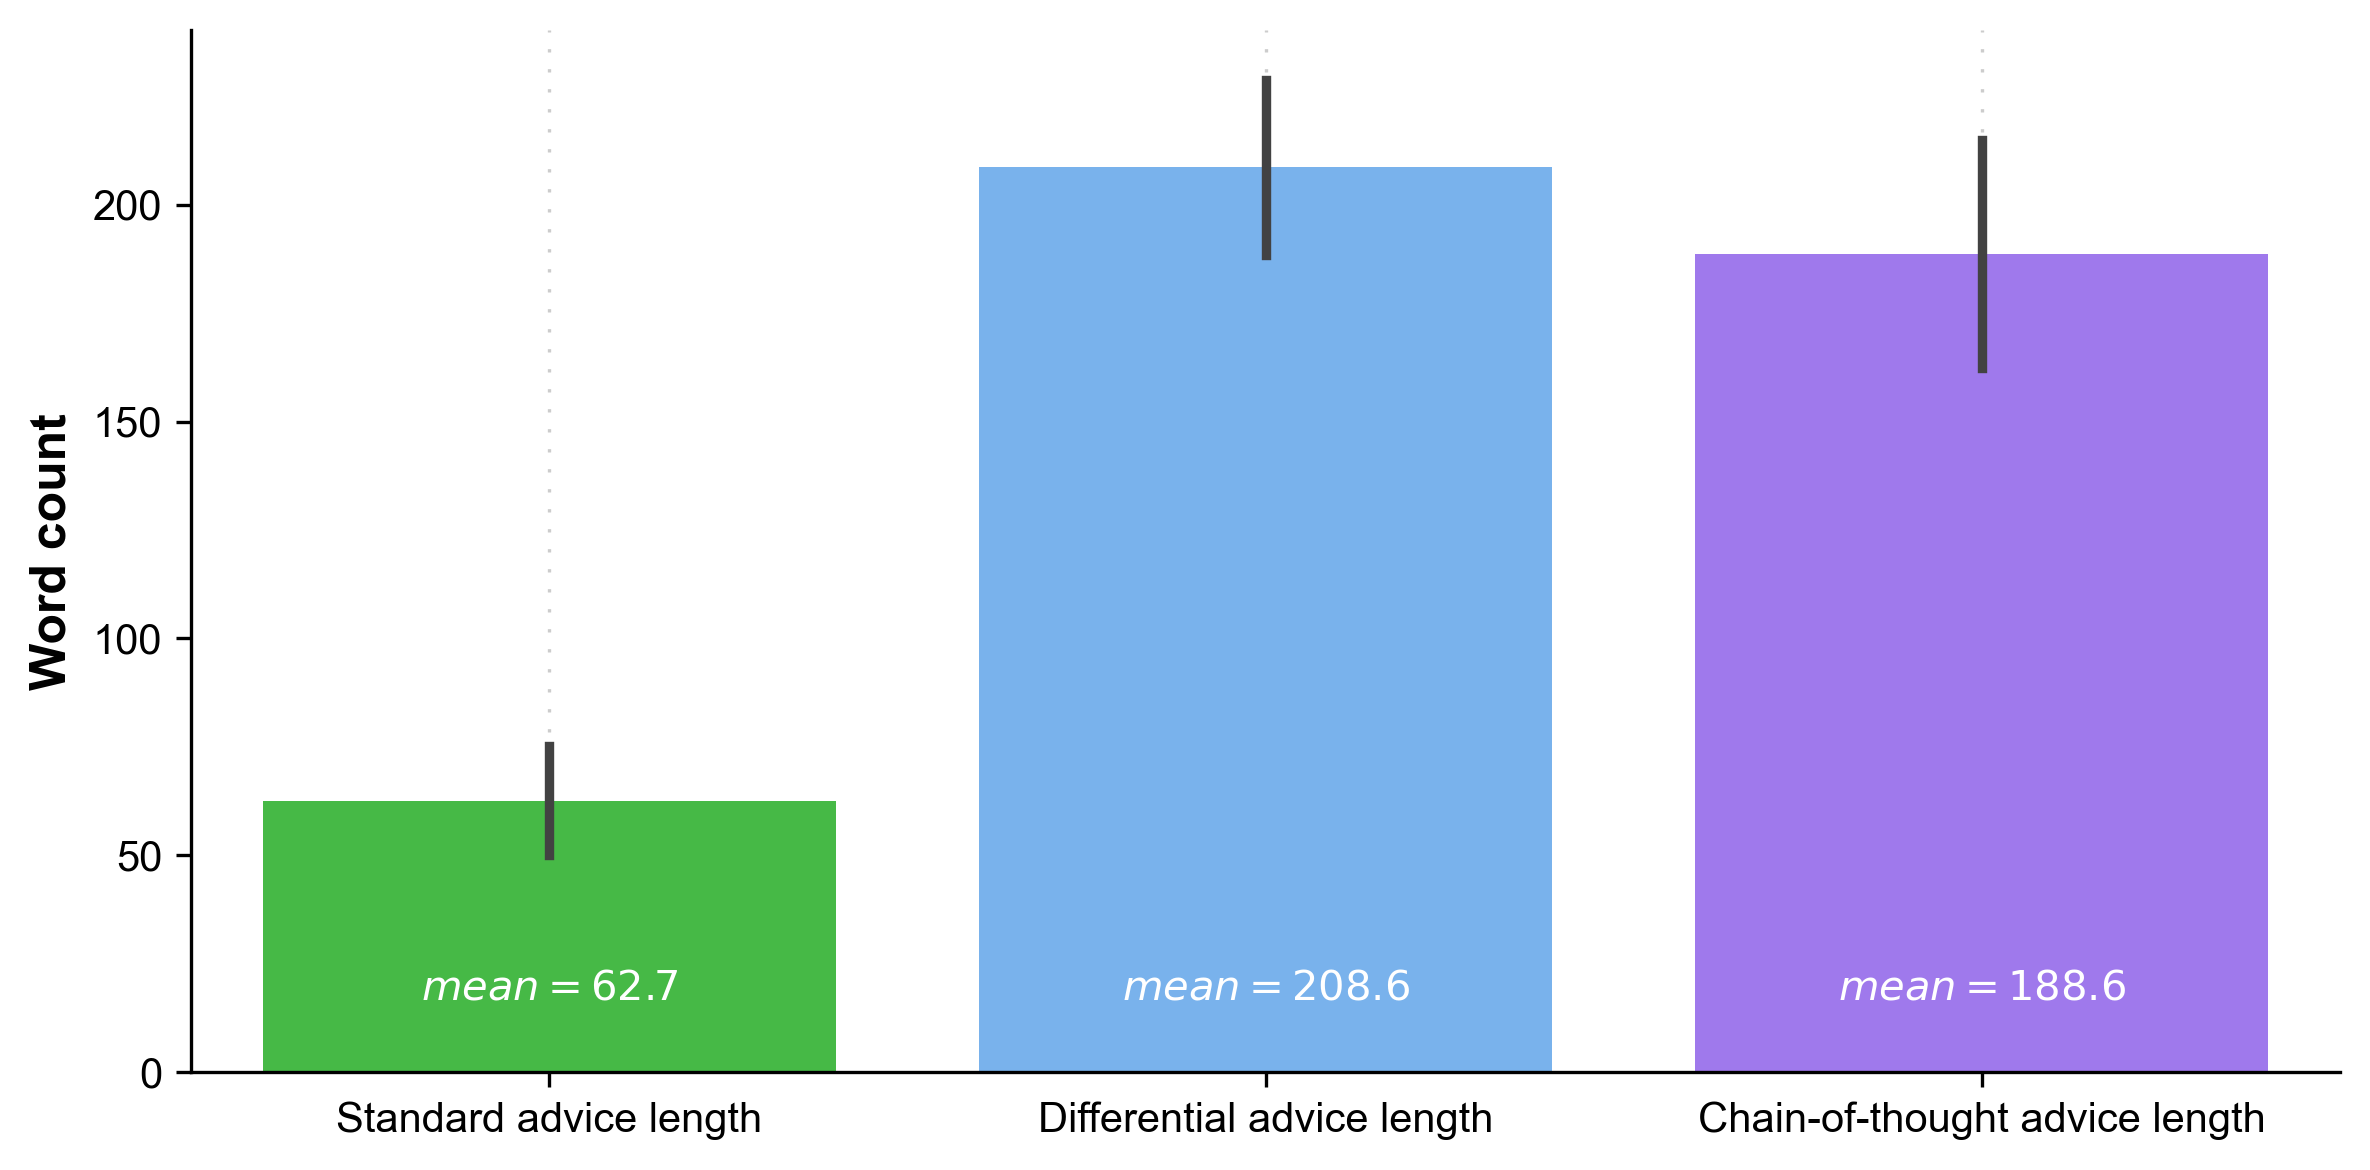

In [39]:
fig, ax = plt.subplots(1,1, figsize=(8,4))
order = ['standard advice length', 'differential advice length', 'chain-of-thought advice length',]
pal = ['#33cc33', '#66b2ff', '#9966ff', '#ff9900']
# order = ['vignette-length', 'standard advice length', 'differential advice length', 'chain-of-thought advice length',]
word_count_melted = output_review[order].melt(var_name='Condition',value_name='Word count')
sns.barplot(data=word_count_melted, y='Word count', hue='Condition', x='Condition', ax=ax, errorbar="sd", order=order, hue_order=order,estimator=np.mean,palette=pal)

# Strip the last word from the xticklabels and capitalize the first letter
ax.set_xticklabels([' '.join(label.get_text().split()).capitalize() for label in ax.get_xticklabels()])
# ax.set_xticklabels(['Vignette'] + [label.get_text().capitalize().replace('length','') for label in ax.get_xticklabels()[1:]])

# Some adjustments
ax.set_xlabel('')
ax.grid(visible=True,which='both',axis='x')
ax.set_ylabel('Word count')

# Annotate the means
for bar in ax.patches:
    x = bar.get_x() + bar.get_width() / 2 
    y = bar.get_height()
    # import pdb; pdb.set_trace()
    ax.text(x, 15, f'$mean = {round(y,1)}$', ha='center', va='bottom', fontsize=10, color='white')
    
# Show and save plot
plt.tight_layout()

try:
    ax.get_figure().savefig(f'../Results/Plots/word_count.pdf')
except FileNotFoundError:
    warnings.warn('Create "../Results/Plots folder" to save figure files')


In [40]:
output_review['vignette-length'].describe()

count    20.000000
mean     55.400000
std      18.813209
min      24.000000
25%      43.000000
50%      54.500000
75%      72.250000
max      85.000000
Name: vignette-length, dtype: float64

## Ground Truth of Diagnosis and Explanations

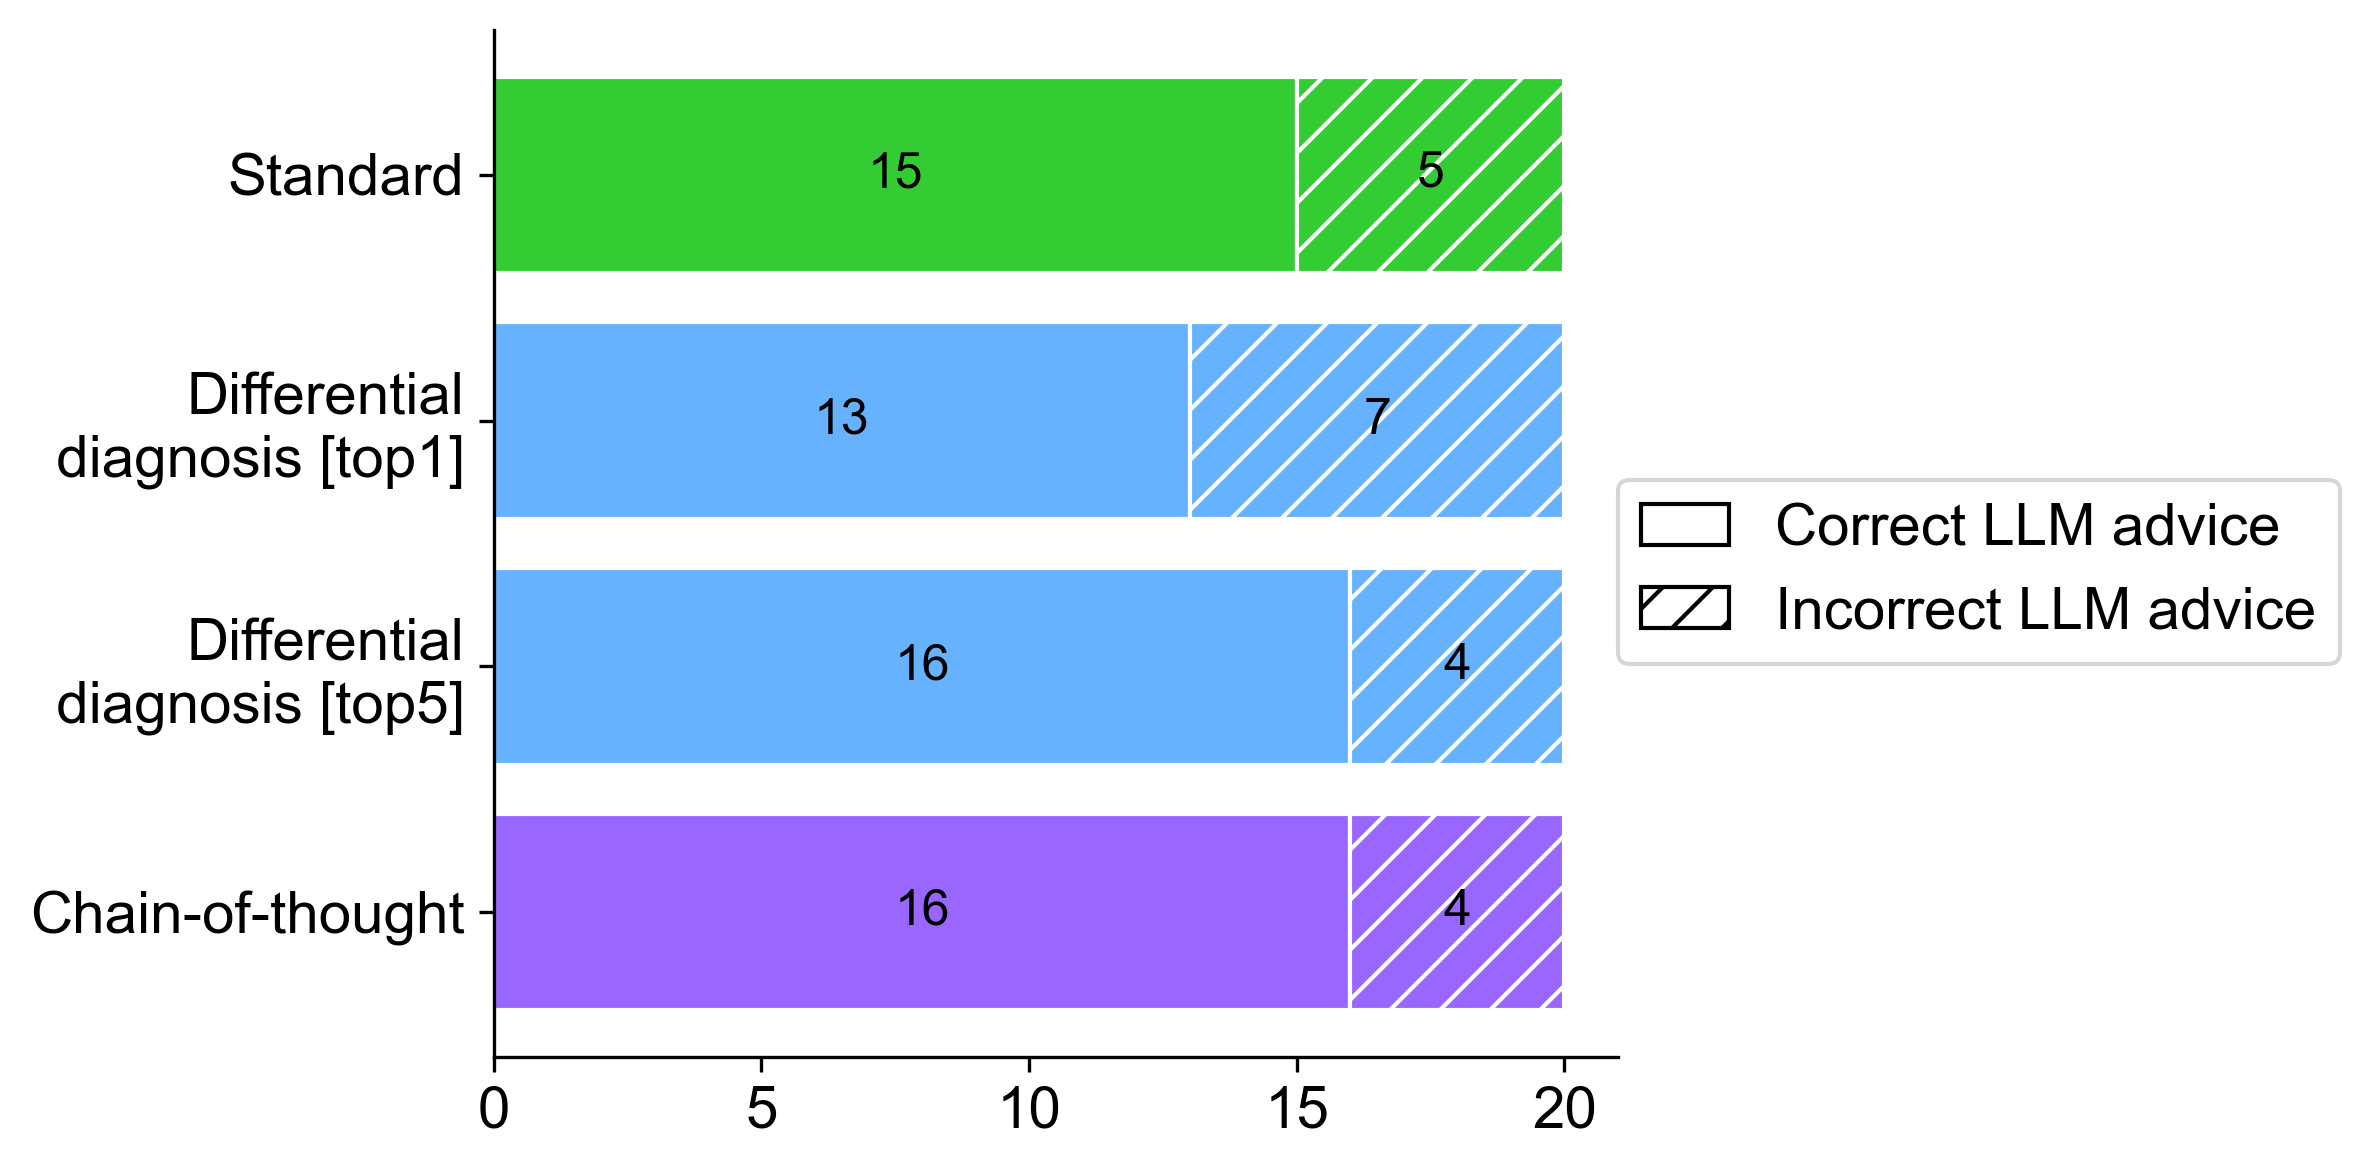

In [41]:
fig, ax = plt.subplots(figsize=(8, 4))

# Define the order and palette
correct = [16, 16, 13,15]
incorrect = [4, 4, 7, 5]
order = ['Chain-of-thought','Differential\n diagnosis [top5]','Differential\n diagnosis [top1]', 'Standard',]
pal = ['#9966ff','#66b2ff','#66b2ff', '#33cc33',]
hatches = ['', '//']

# Create the barplot for correct
bars_correct = ax.barh(order, correct, color=pal, edgecolor='white')
# Create the barplot for incorrect stacked on top of correct
bars_incorrect = ax.barh(order, incorrect, left=correct, color=pal, edgecolor='white', hatch=hatches[1])

# Annotate the bars
for bars in [bars_correct, bars_incorrect]:
    for bar in bars:
        width = bar.get_width()
        label_x_pos = bar.get_x() + width / 2
        ax.text(label_x_pos, bar.get_y() + bar.get_height() / 2, f'{int(width)}', ha='center', va='center', color='black', fontsize=12)

# Set titles and labels
#ax.set_title('Advice', fontsize=18)
ax.set_yticklabels(order, fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)

capitalize_xticklabels(ax)

# Customize x-axis ticks
ax.xaxis.set_major_locator(plt.MultipleLocator(5))
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}'))

# Create custom legend for hatches
legend_handles = [
    mpatches.Patch(facecolor='white', edgecolor='black', label='Correct LLM advice'),
    mpatches.Patch(facecolor='white', edgecolor='black', hatch=hatches[1], label='Incorrect LLM advice')
]
ax.legend(handles=legend_handles, loc=(1.0, 0.383), fontsize=14, ncol=1)

# Adjust layout
plt.tight_layout()
plt.show()

try:
    fig.savefig(f'../Results/Plots/accuracies.pdf')
except FileNotFoundError:
    warnings.warn('Create "../Results/Plots folder" to save figure files')

## LLM use in Control Group

In [42]:
# Filter the dataframe for the control group
control_group = df[df['condition'] == 'control']

# Count the number of unique participants (ResponseId) in the control group
num_participants_control = control_group['ResponseId'].nunique()

print(f"Number of participants that used LLMs in the control group: {num_participants_control}")

Number of participants that used LLMs in the control group: 24


In [43]:
# Filter the dataframe for the control group
control_group = df_reg[df_reg['condition'] == 'control']

# Get the list of assistive tools used by the control group
assistive_tools_control = control_group['Q811'].unique().tolist()

print("Assistive tools used by the control group:", assistive_tools_control)

Assistive tools used by the control group: ['No', 'google', nan, 'internet', 'Radiopaedia ', 'radiopaedia', 'Google', 'google for spelling', 'Textbook', 'Internet search', 'Brief internet search to for correct spelling']


# Performance

## Participant

In [44]:
control_performance = df_agg.query('condition == "control"')['correctness'].to_list()
standard_performance = df_agg.query('condition == "standard"')['correctness'].to_list()
cot_performance = df_agg.query('condition == "chain-of-thought"')['correctness'].to_list()
dd_performance = df_agg.query('condition == "differential"')['correctness'].to_list()

# Perform ANOVA
fvalue, pvalue = stats.f_oneway(control_performance, standard_performance, cot_performance, dd_performance)
print(f"ANOVA results: F-value = {fvalue:.3f}, p-value = {pvalue:.3f}")

# Control vs. Standard
t_statistic, p_value = one_sided_ttest(control_performance, standard_performance)
print(f"Control vs. Standard: t-statistic = {t_statistic:.3f}, p-value = {p_value:.3f}")

# Control vs. DD
t_statistic, p_value = one_sided_ttest(control_performance, dd_performance)
print(f"Control vs. DD: t-statistic = {t_statistic:.3f}, p-value = {p_value:.3f}")

# Control vs. CoT
t_statistic, p_value = one_sided_ttest(control_performance, cot_performance)
print(f"Control vs. CoT: t-statistic = {t_statistic:.3f}, p-value = {p_value:.3f}")

# Standard vs. CoT
t_statistic, p_value = one_sided_ttest(standard_performance, cot_performance)
print(f"Standard vs. CoT: t-statistic = {t_statistic:.3f}, p-value = {p_value:.3f}")

# DD vs. CoT
t_statistic, p_value = one_sided_ttest(dd_performance, cot_performance)
print(f"DD vs. CoT: t-statistic = {t_statistic:.3f}, p-value = {p_value:.3f}")

# Standard vs. DD
t_statistic, p_value = one_sided_ttest(standard_performance, dd_performance)
print(f"Standard vs. DD: t-statistic = {t_statistic:.3f}, p-value = {p_value:.3f}")

# 2. Perform pairwise t-tests (Group A vs Group B, Group B vs Group C, etc.)
p_values = {
    ('control', 'standard'): one_sided_ttest(control_performance, standard_performance),
    ('control', 'differential'): one_sided_ttest(control_performance, dd_performance),
    ('control', 'chain-of-thought'): one_sided_ttest(control_performance, cot_performance),
    ('standard', 'chain-of-thought'): one_sided_ttest(standard_performance, cot_performance),
    ('differential', 'chain-of-thought'): one_sided_ttest(dd_performance, cot_performance),
}

ANOVA results: F-value = 4.650, p-value = 0.004
Control vs. Standard: t-statistic = -1.192, p-value = 0.120
Control vs. DD: t-statistic = -0.669, p-value = 0.254
Control vs. CoT: t-statistic = -3.525, p-value = 0.001
Standard vs. CoT: t-statistic = -2.405, p-value = 0.011
DD vs. CoT: t-statistic = -4.172, p-value = 0.000
Standard vs. DD: t-statistic = 0.754, p-value = 0.773


In [45]:
# gpt_performance = {    
#     'standard': advice_df[['standard diagnosis correct', 'standard explanation correct']].eq('Yes').all(axis=1).mean(),
#     'differential': advice_df[['differential diagnosis correct', 'differential explanation correct']].eq('Yes').all(axis=1).mean(),
#     'chain-of-thought': advice_df[['chain-of-thought diagnosis correct', 'chain-of-thought explanation correct']].eq('Yes').all(axis=1).mean(),
# }

# gpt_performance

In [46]:
df_reg.groupby('condition').agg({'correctness': 'mean'})

correctness
condition                    
chain-of-thought     0.739130
control              0.616667
differential         0.641667
standard             0.666667

In [47]:
gpt_performance = {    
    'standard': advice_df[['standard diagnosis correct']].eq('Yes').all(axis=1).mean(),
    'differential': advice_df[['differential diagnosis correct']].eq('Yes').all(axis=1).mean(),
    'chain-of-thought': advice_df[['chain-of-thought diagnosis correct']].eq('Yes').all(axis=1).mean(),
}

gpt_performance

{'standard': np.float64(0.75),
 'differential': np.float64(0.8),
 'chain-of-thought': np.float64(0.8)}

In [48]:
order = ['control', 'standard', 'differential', 'chain-of-thought',]
pal = ['#33cc33', '#66b2ff', '#9966ff', '#ff9900']
    
def plot_performance(df,map_partical_to,legend=False, low_test_margin=0.04,high_test_margin=0.015,low_offset=0):
    df['judgement'] = df.original_judgement.replace('Partial',map_partical_to)
    df['correctness'] = df.judgement.map({'Yes': 1, 'No': 0},)
    df_agg = df.groupby('ResponseId').agg(agg_fns)
    
    control_performance = df_agg.query('condition == "control"')['correctness'].to_list()
    standard_performance = df_agg.query('condition == "standard"')['correctness'].to_list()
    cot_performance = df_agg.query('condition == "chain-of-thought"')['correctness'].to_list()
    dd_performance = df_agg.query('condition == "differential"')['correctness'].to_list()

    p_values = {
        ('control', 'standard'): one_sided_ttest(control_performance, standard_performance),
        ('control', 'differential'): one_sided_ttest(control_performance, dd_performance),
        ('control', 'chain-of-thought'): one_sided_ttest(control_performance, cot_performance),
        ('standard', 'chain-of-thought'): one_sided_ttest(standard_performance, cot_performance),
        ('differential', 'chain-of-thought'): one_sided_ttest(dd_performance, cot_performance),
    }

    # select data and create plot
    fig, ax = plt.subplots(1,1, figsize=(5,5))
    box = sns.boxplot(data=df_agg, x='condition', y='correctness', order=order, hue='condition', hue_order=order,width=.2, showfliers=False, ax=ax, whis=0, medianprops={'linewidth': 3})
    vio = sns.violinplot(data=df_agg, x='condition', y='correctness',alpha=0.5, hue='condition', hue_order=order, order=order, ax=ax, inner=None, cut=0)
    
    for violin in vio.collections: violin.set_alpha(0.5) 
    
    gpt_performance_df = pd.DataFrame(list(gpt_performance.items()), columns=['condition', 'accuracy'])
    
    sns.pointplot(data=df_agg, x='condition', y='correctness', estimator=np.mean,markers='D',scale=1,ax=ax, linestyles='',
                  hue='condition',errorbar=None,order=order,hue_order=order, zorder=10)
    
    sns.pointplot(data=gpt_performance_df, x='condition', y='accuracy', markers='o', join=False, ax=ax, hue='condition', hue_order=order, order=order, legend=legend, zorder=10)
    annotate_tests(p_values=p_values,order=order,ymax=max(df_agg['correctness']),low_test_margin=low_test_margin,high_test_margin=high_test_margin,low_offset=low_offset)
    format_labs(xlab='',ylab='Diagnostic accuracy',ylim=(0,1),perc=1)

    # Show and save plot
    plt.legend(handles=[
        plt.Line2D([0], [0], marker='o', color='gray', markerfacecolor='none', label='LLM-only', markersize=7, markeredgewidth=2, linestyle='None'), 
        plt.Line2D([0], [0], marker='D', color='gray', markerfacecolor='none', label='Physicians with LLM support', markersize=5, markeredgewidth=2, linestyle='None')
        ], loc='lower left', title_fontsize=8, prop={'size': 8}, title='Diagnostic accuracy (mean)');
    plt.tight_layout()
    save_plot(f'performance_partial_as_{map_partical_to}')

In [49]:
df_reg.groupby('condition')['correctness'].describe()

count      mean       std   min     25%   50%     75%   max
condition                                                                    
chain-of-thought   23.0  0.739130  0.063883  0.65  0.7000  0.75  0.8000  0.85
control            24.0  0.616667  0.157195  0.35  0.5375  0.60  0.7125  0.90
differential       30.0  0.641667  0.105114  0.40  0.6000  0.65  0.6500  0.95
standard           24.0  0.666667  0.132424  0.20  0.6000  0.70  0.7500  0.85

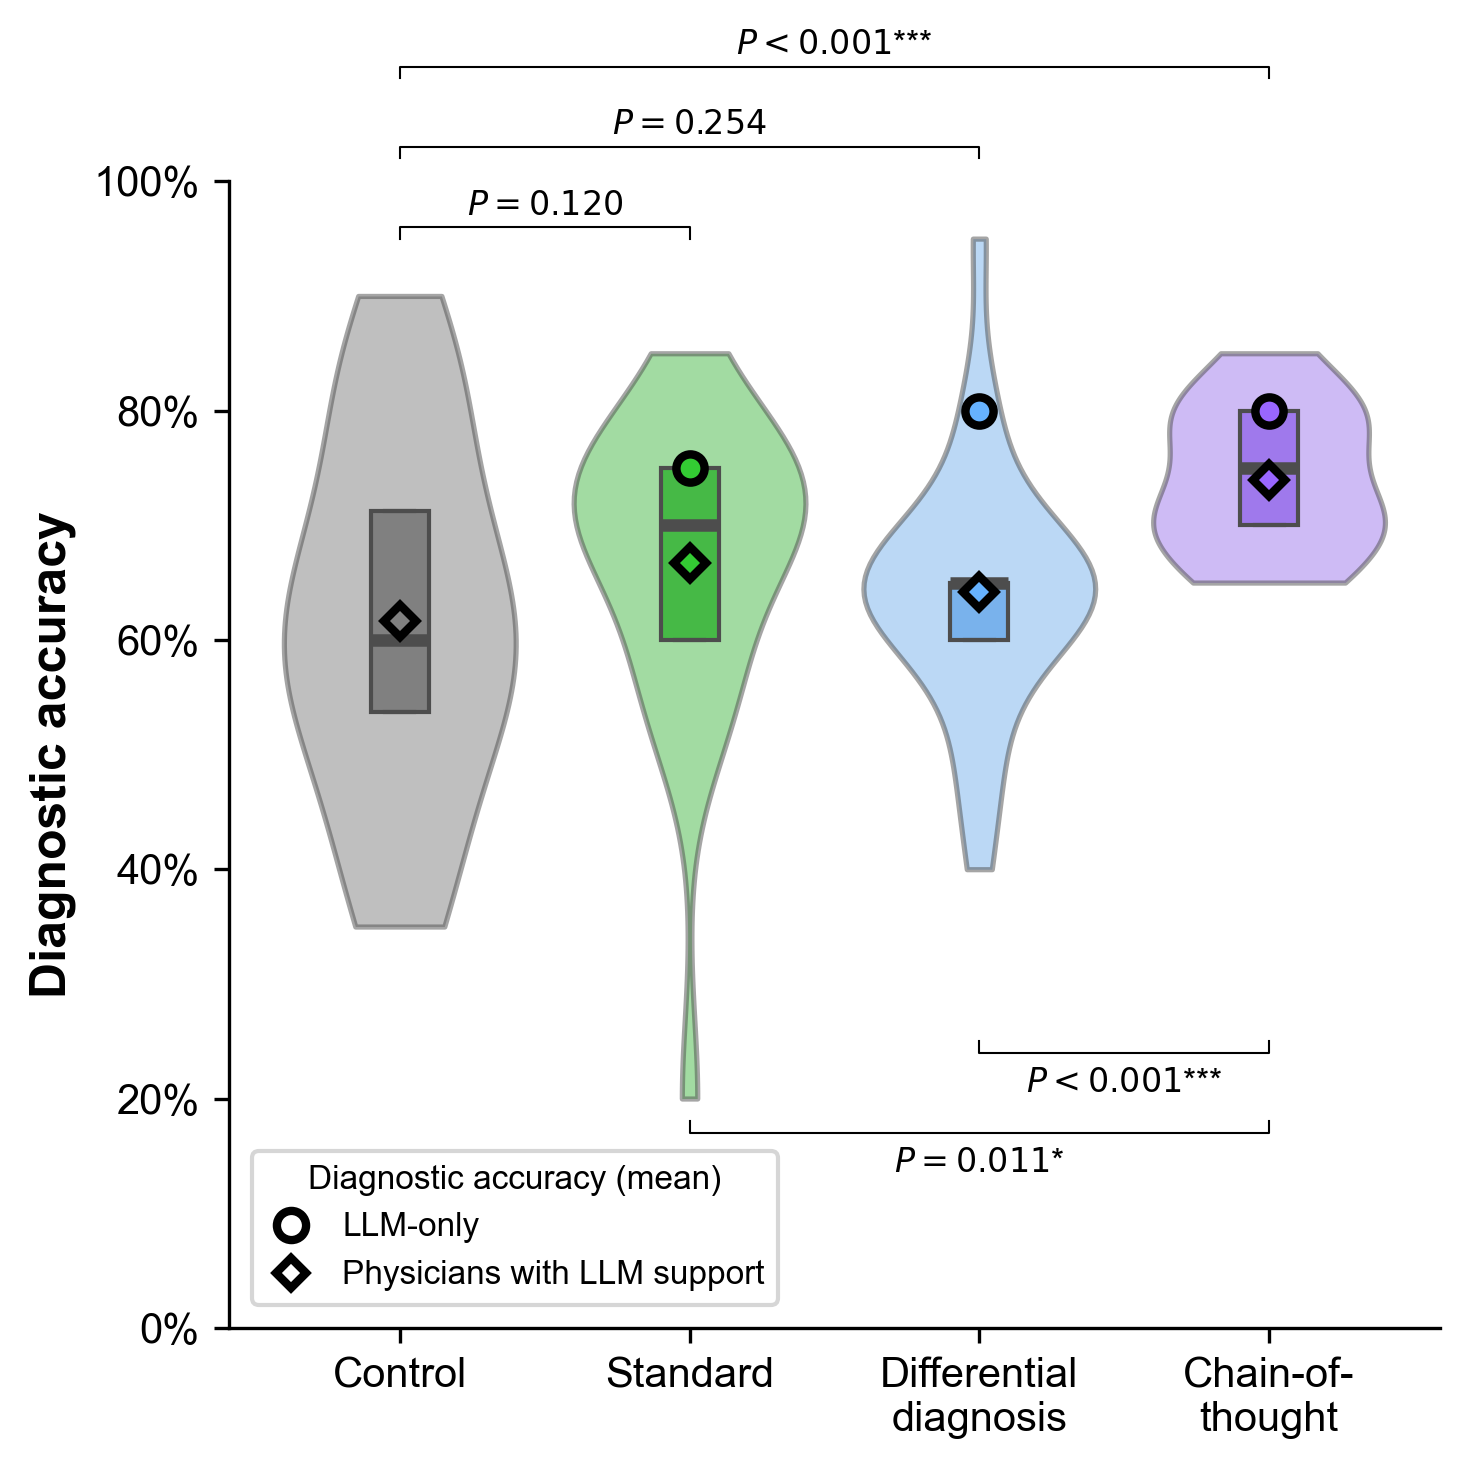

In [50]:
plot_performance(df,'No',legend=True,low_offset=-0.03)


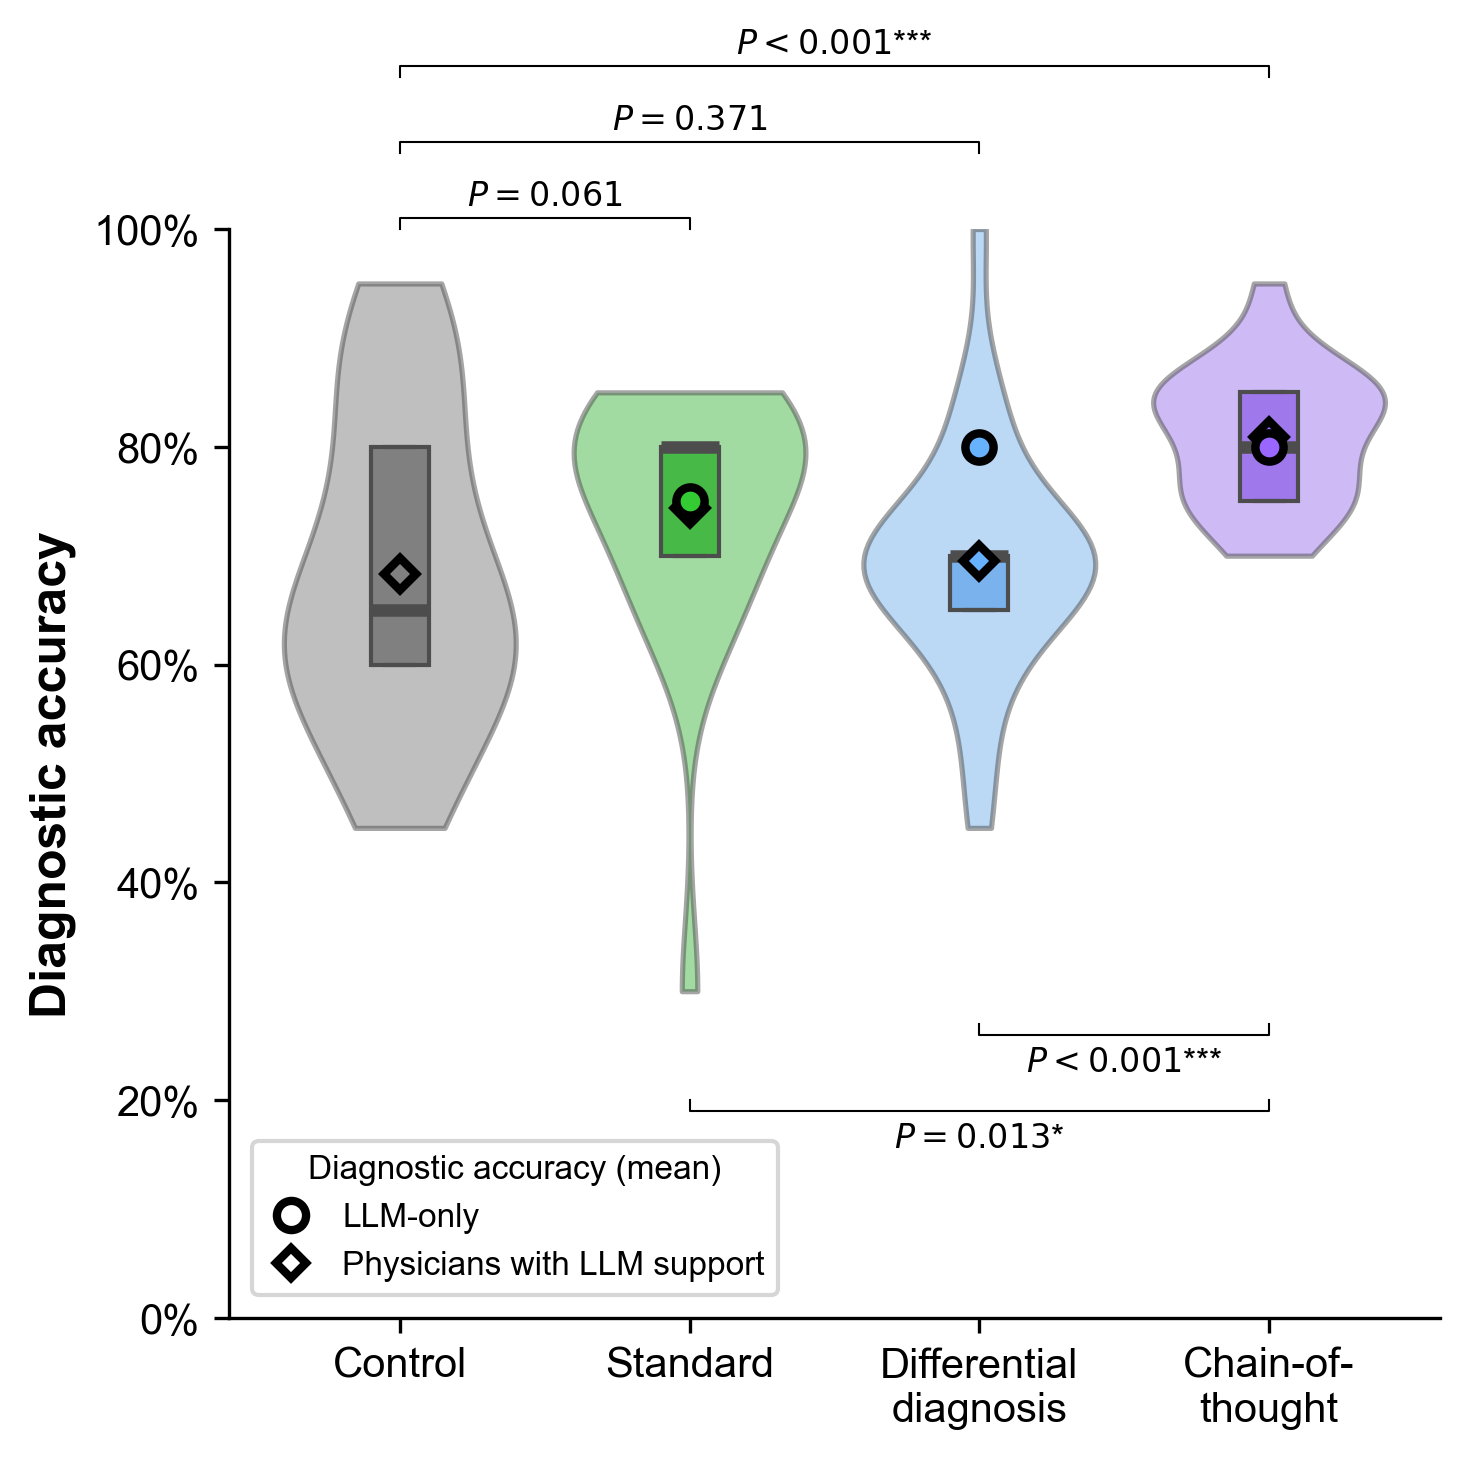

In [51]:
plot_performance(df,'Yes');

## Performance distribution

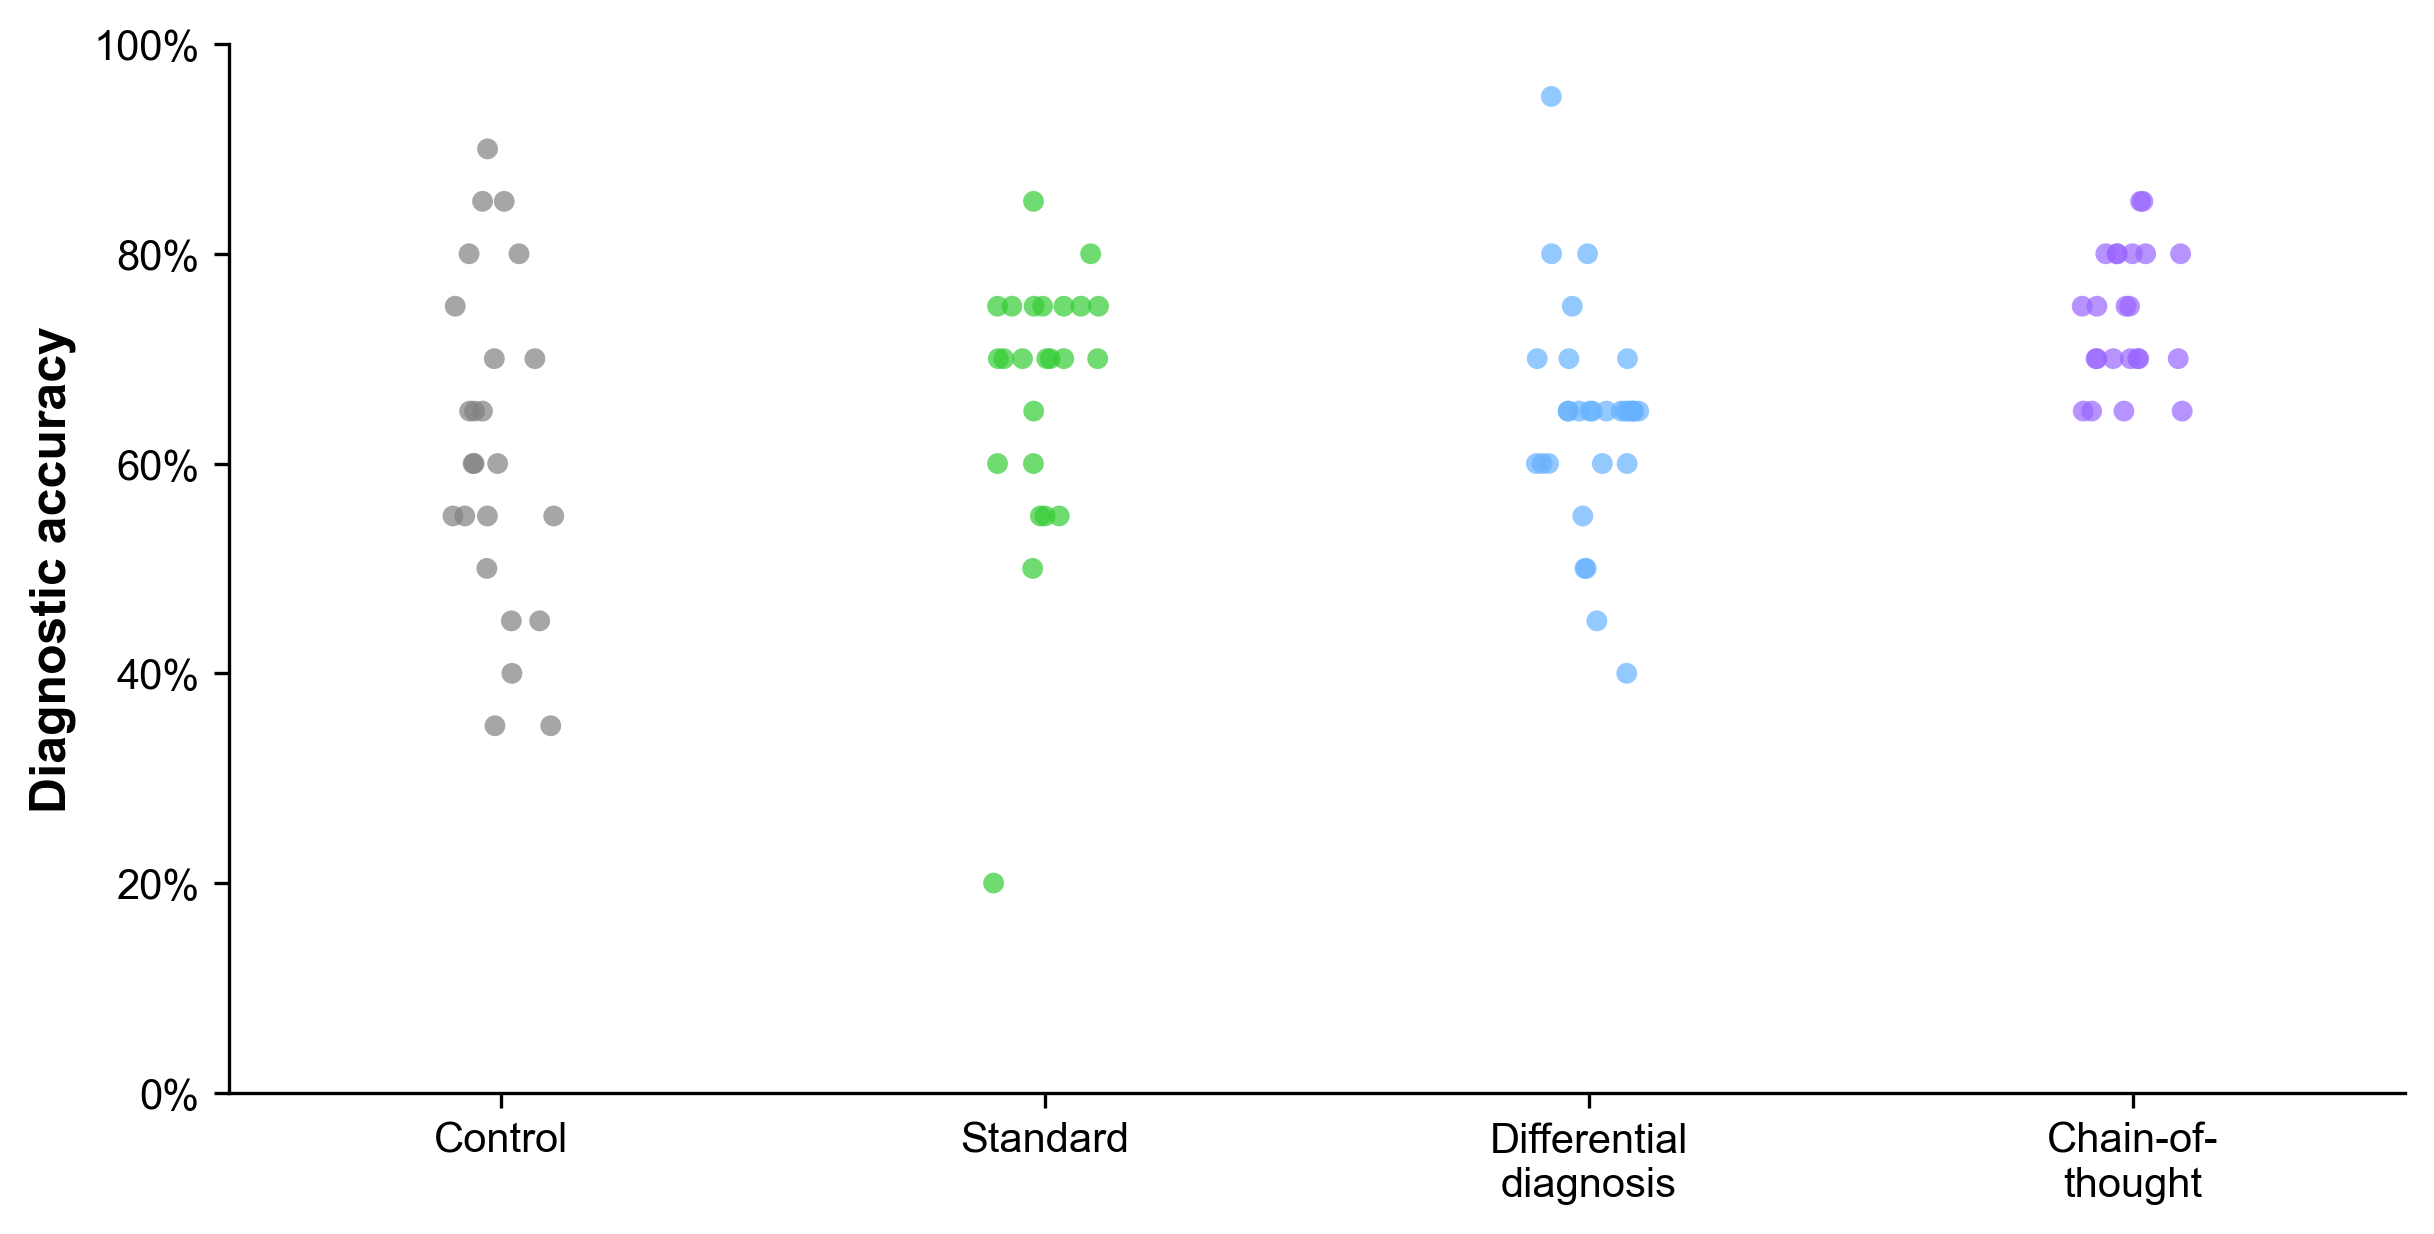

In [52]:
fig = sns.stripplot(df_reg, y='correctness', x='condition', hue='condition', 
                    hue_order=order, order=order, alpha=0.7, jitter=True)

format_labs(perc=1,ylim=(0,1),ylab='Diagnostic accuracy',xlab='')

save_plot('performance_distribution')

## Disease (Question)

In [53]:
df['disease'] = df.question.map(GROUND_TRUTHS)

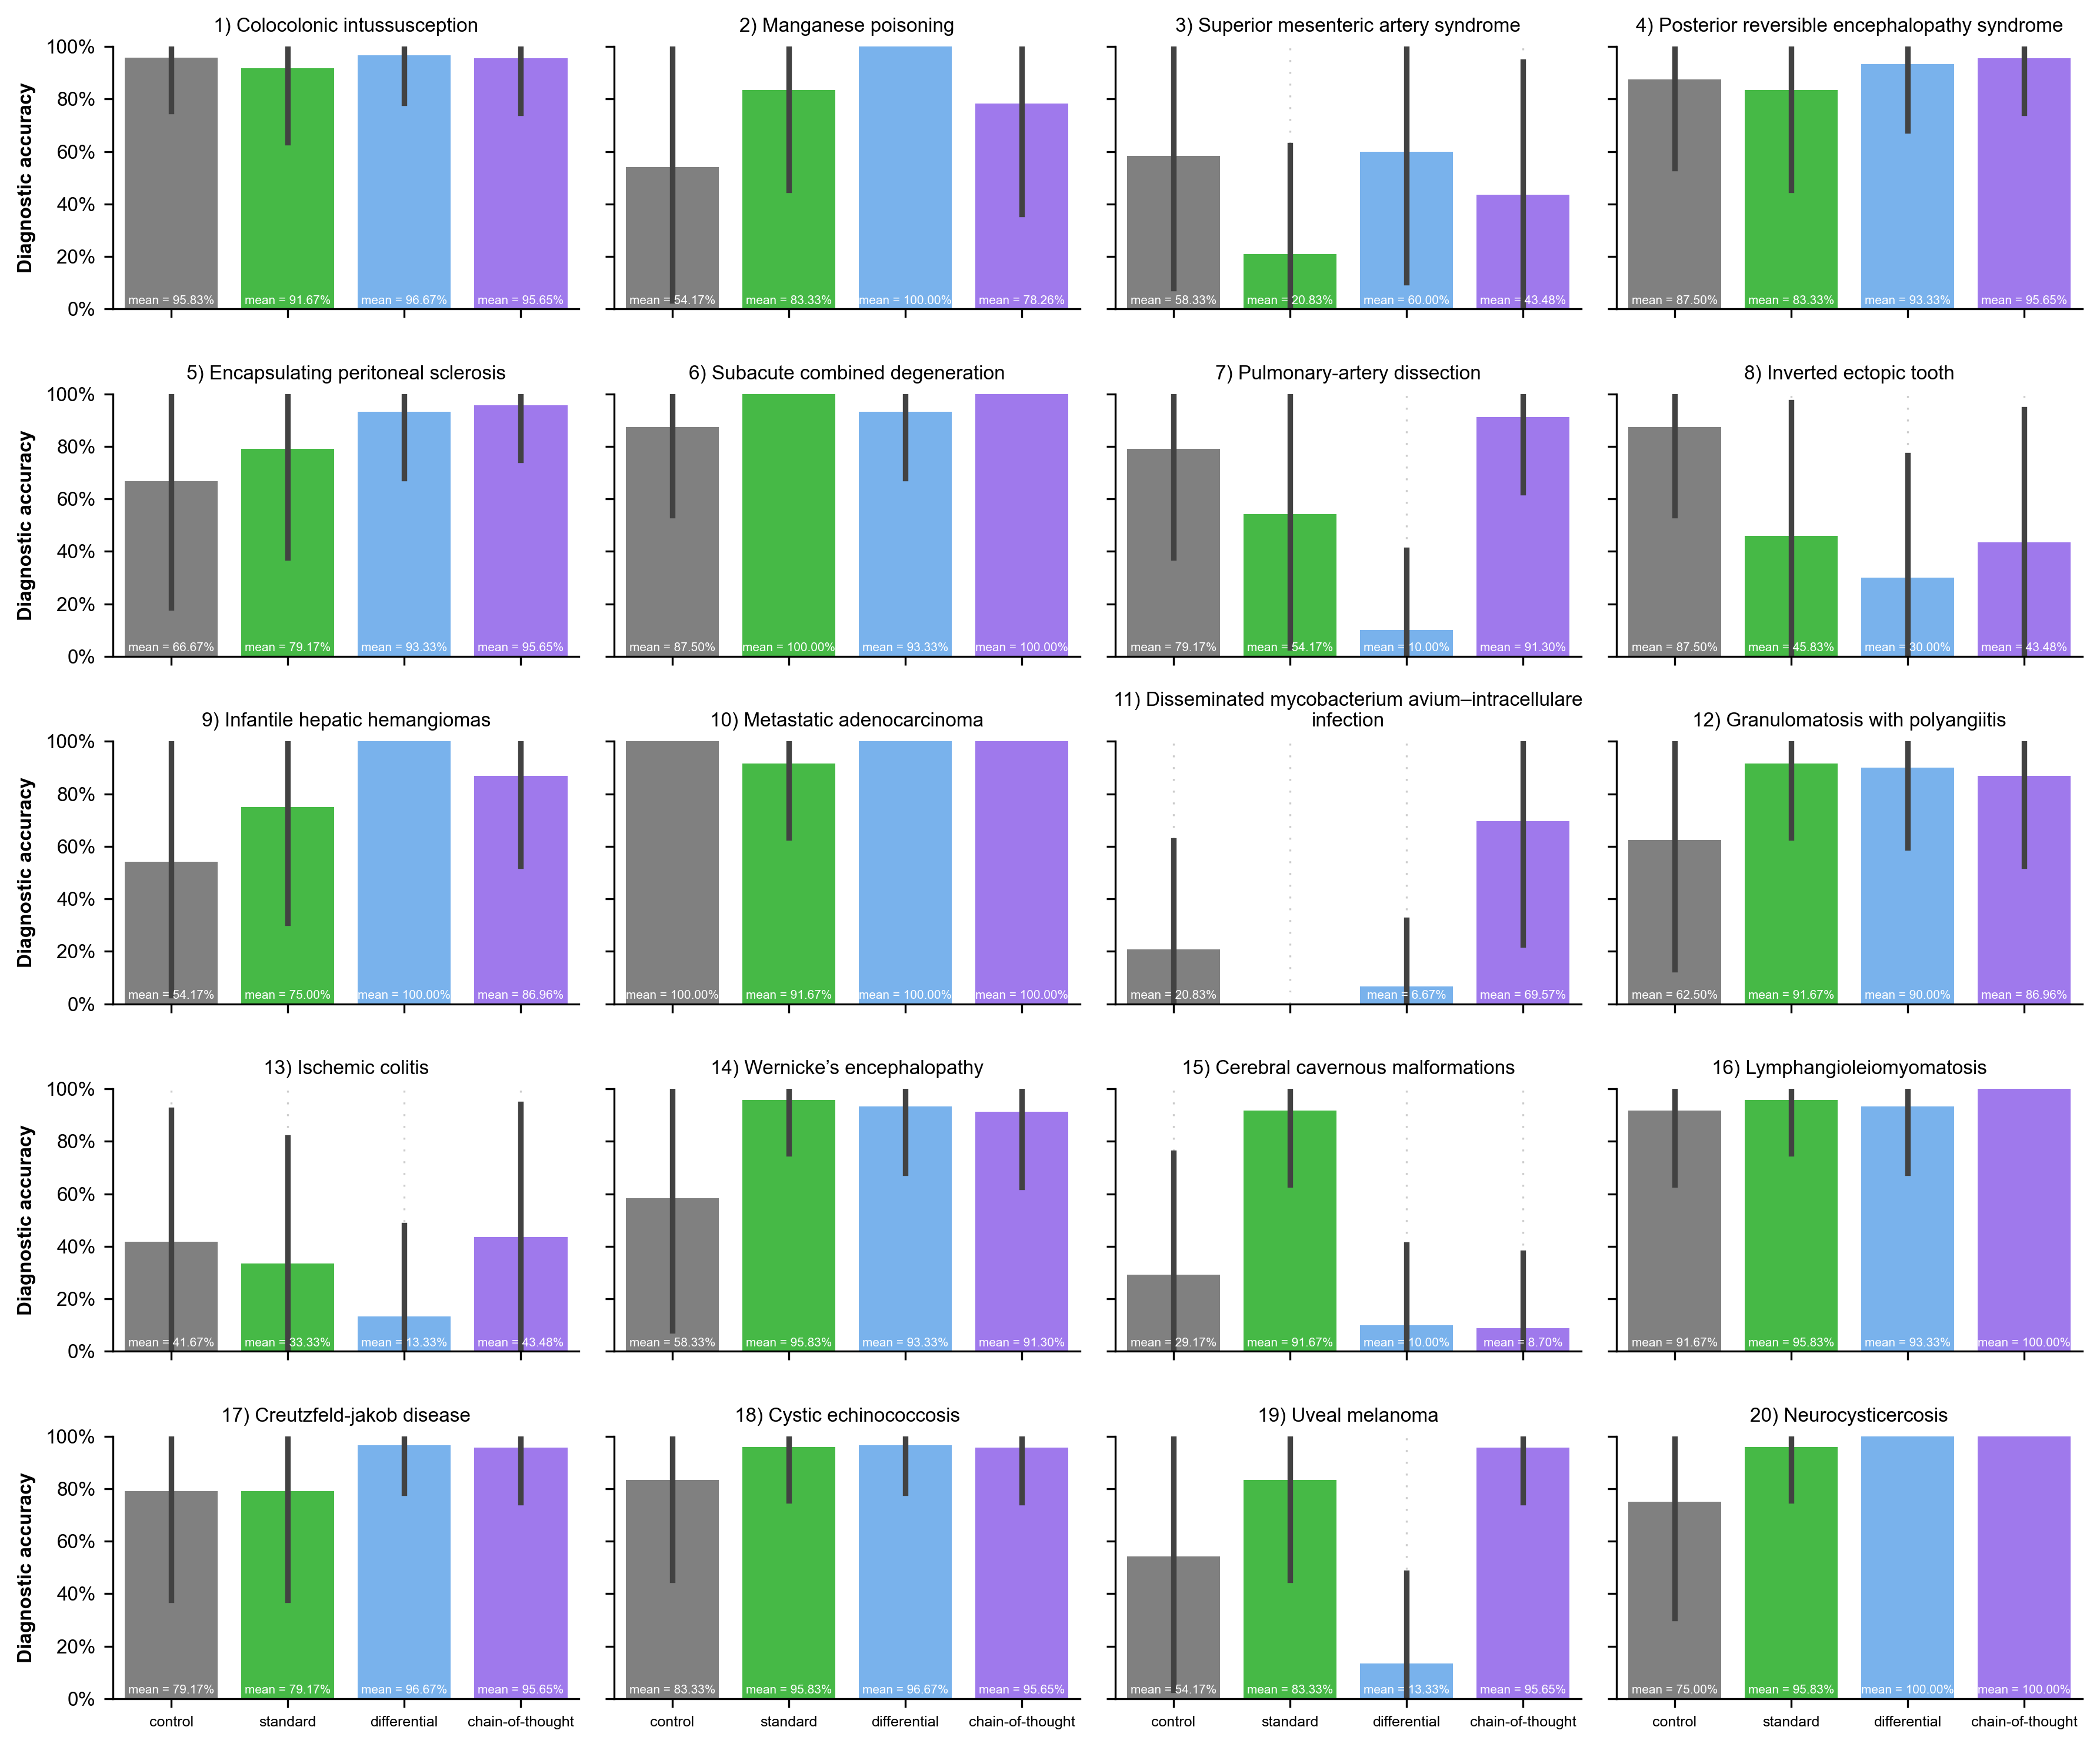

In [54]:
# select data and create plot
kwargs_box = dict(data=df, x='condition', y='correctness', order=order, width=.2, showfliers=False, whis=0)
kwargs_vio = dict(data=df, x='condition', y='correctness', order=order, alpha=0.5, inner=None, cut=0)
kwargs_bar = dict(data=df, x='condition', y='correctness', order=order, alpha=1,)

g = sns.FacetGrid(data=df, col='disease', hue='condition', hue_order=order, col_wrap=4, sharex=True,)
g.map_dataframe(sns.barplot, **kwargs_bar, errorbar='sd') 

# Some adjustments
for n, ax in enumerate(g.axes.flat):
    ax.set_xlabel('') 
    ax.set_ylabel('Diagnostic accuracy',fontsize=8)
    ax.tick_params(axis='x', labelsize=6)
    
    
    title = ax.get_title()[10:]
    if len(title) > 50:
        wrapper = textwrap.TextWrapper(width=50)
        ax.set_title(f"{n+1}) {wrapper.fill(title).strip().lower().capitalize()}", fontsize=8)
    else:
        ax.set_title(f"{n+1}) {title.strip().lower().capitalize()}", fontsize=8)

    ax.grid(visible=True,which='both',axis='x')
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
    ax.yaxis.set_tick_params(labelsize=8)

    # Annotate the means
    for con,bar in zip(order, ax.patches):
        x = bar.get_x() + bar.get_width() / 2
        y = bar.get_height()
        
        #if y > 0.75: y -= 0.20; fontcolor = 'white'
        #else: fontcolor = 'black'
        # if y < 20: y += 0.10; fontcolor = 'black'
        ax.text(x, 0.01, f'mean = {y * 100:.2f}%', ha='center', va='bottom', fontsize=5, color='white')
        # Calculate and annotate the standard deviation
        std_dev = (df[(df['disease'] == title)&(df['condition'] == con)]['correctness']*100).std()
        # ax.text(x, y, f'std = {std_dev:.2f}', ha='center', va='bottom', fontsize=5, color=fontcolor)
    
    ax.set_ylim(0,1)

g.fig.set_figheight(10)
plt.tight_layout()    
try:
    g.savefig(f'../Results/Plots/performance_disease.pdf')
except FileNotFoundError:
    warnings.warn('Create "../Results/Plots folder" to save figure files')

In [55]:
df.groupby(['disease','condition'])['correctness'].count()

disease                                       condition       
Cerebral cavernous malformations              chain-of-thought    23
                                              control             24
                                              differential        30
                                              standard            24
Colocolonic intussusception                   chain-of-thought    23
                                                                  ..
posterior reversible encephalopathy syndrome  standard            24
subacute combined degeneration                chain-of-thought    23
                                              control             24
                                              differential        30
                                              standard            24
Name: correctness, Length: 80, dtype: int64

## Diagnosis and explanation correctness

In [56]:
df.groupby(['Diagnosis correctness','Explanation correctness'])['correctness'].mean()

Diagnosis correctness  Explanation correctness
No                     No                         0.259843
                       Yes                        0.282051
Yes                    No                         0.842233
                       Yes                        0.893216
Name: correctness, dtype: float64

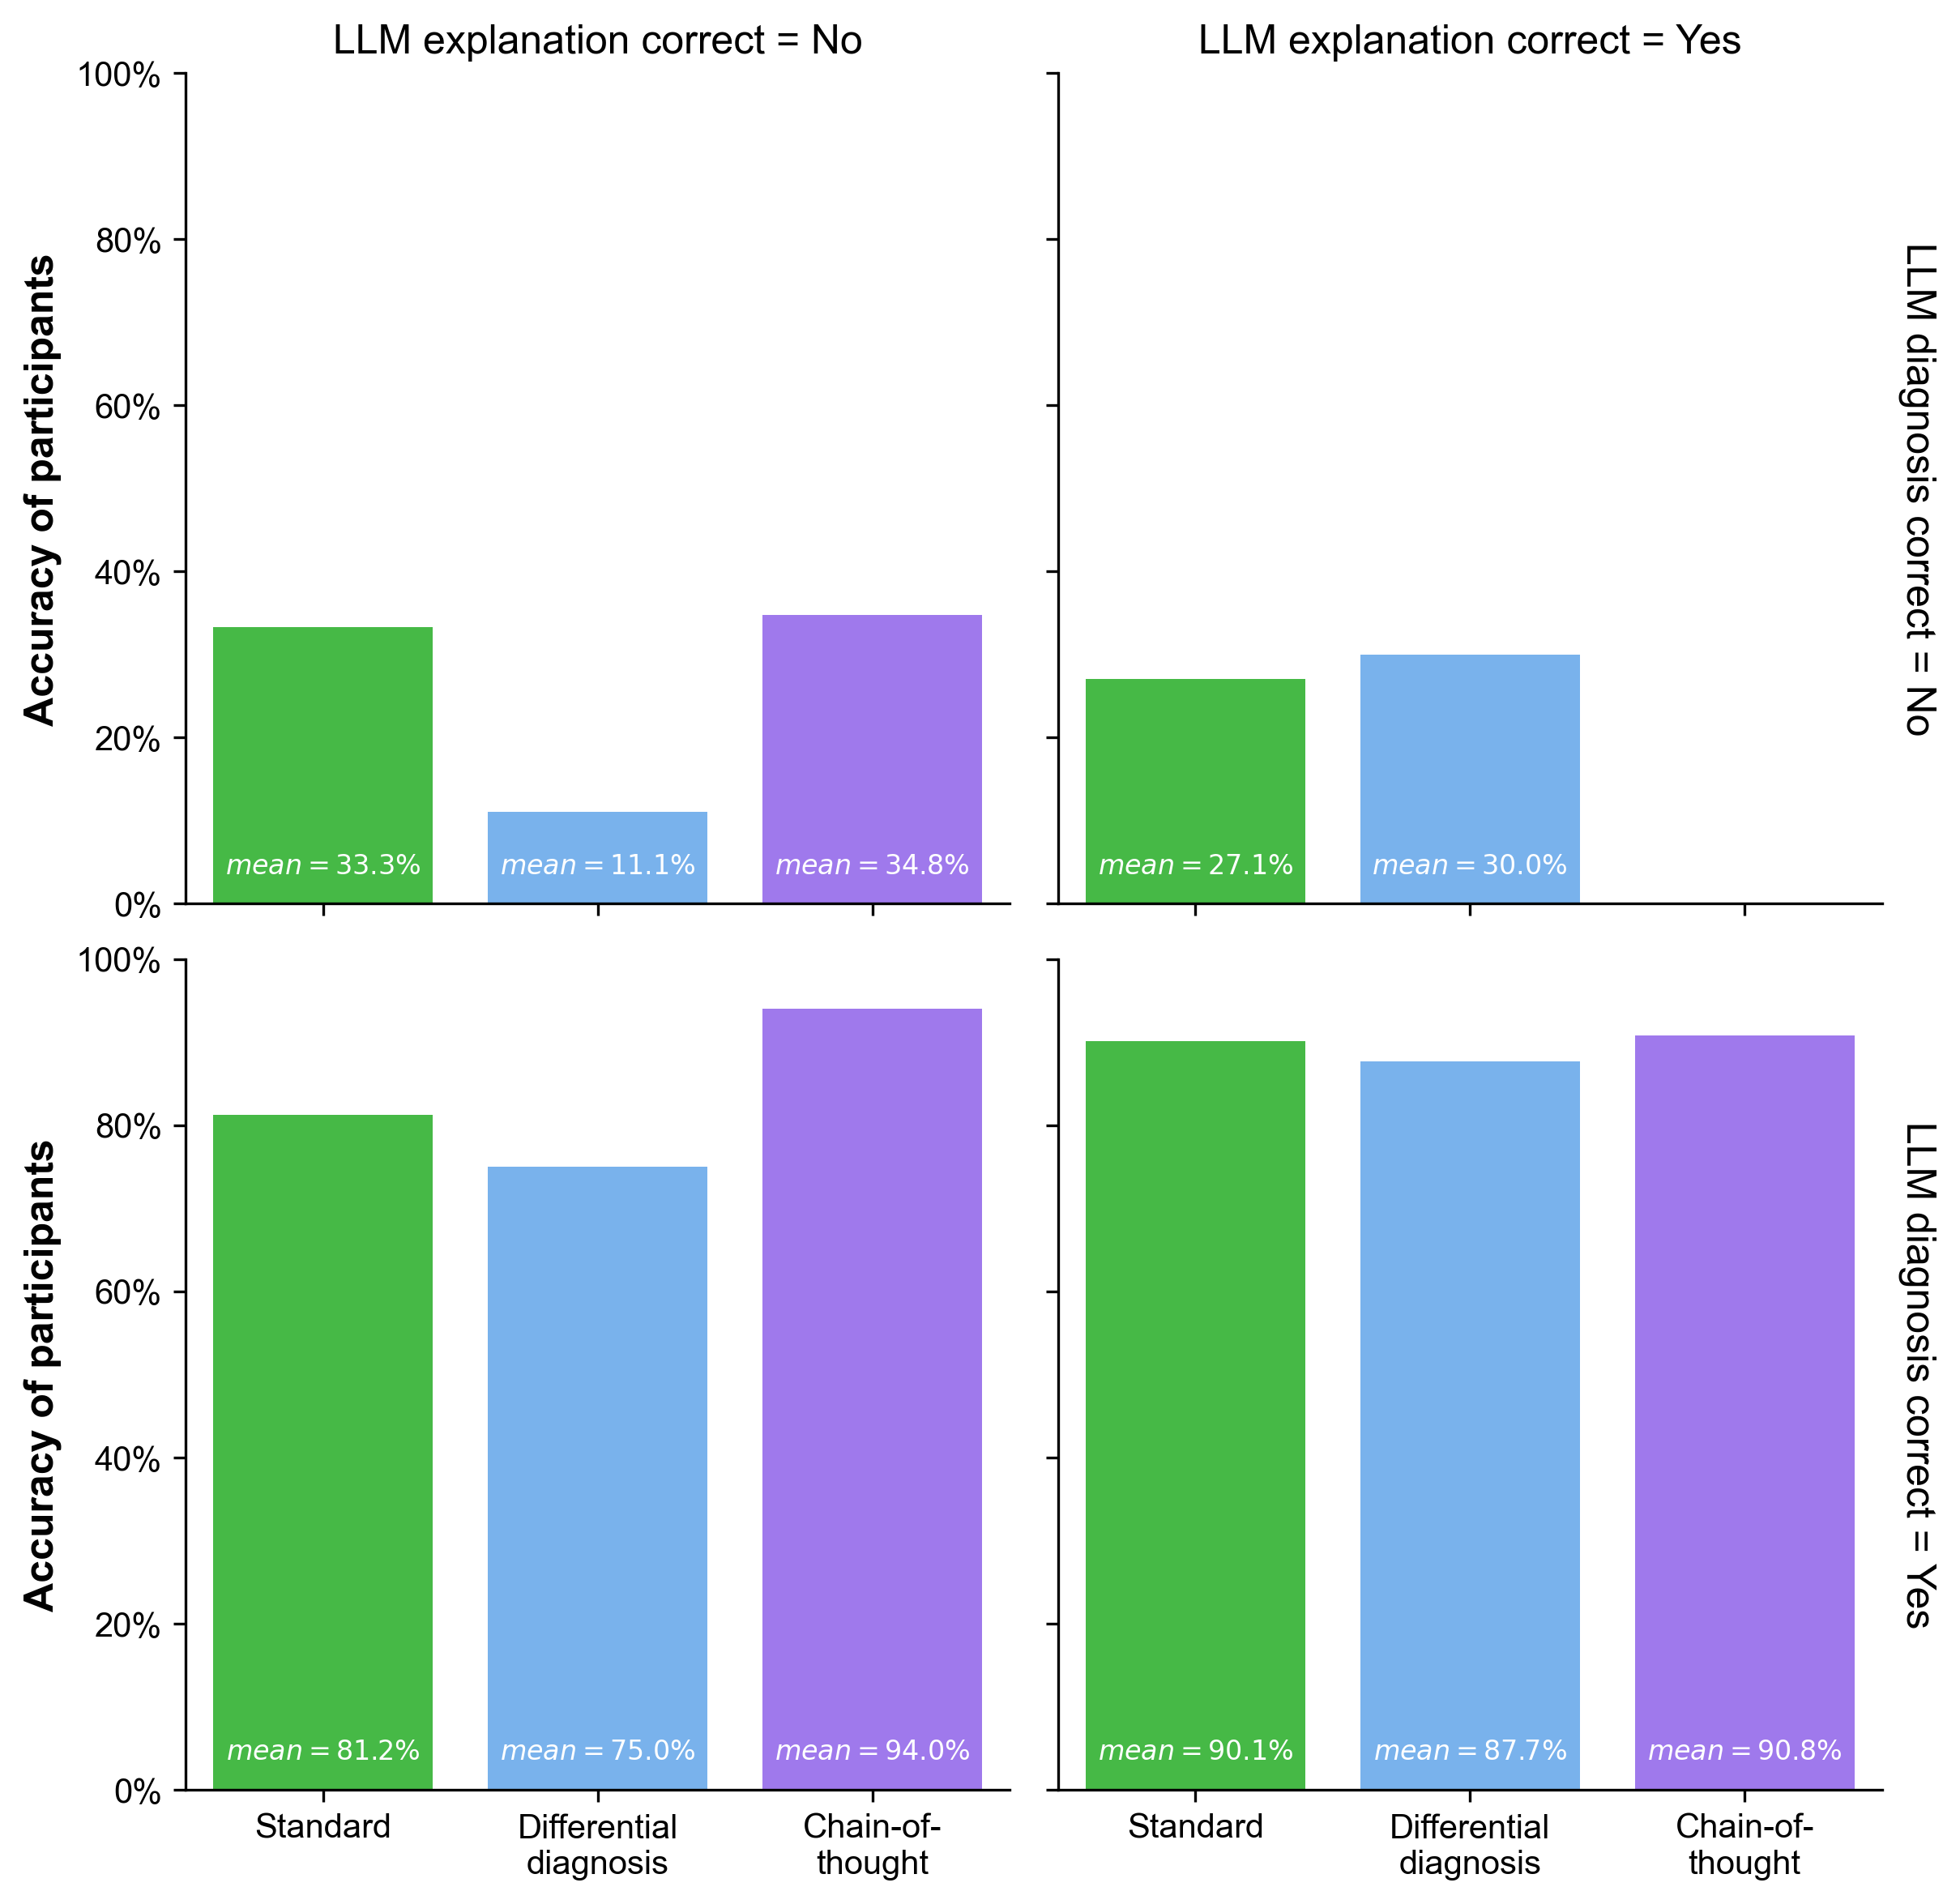

In [57]:
g = sns.FacetGrid(data=df.rename(columns={'Diagnosis correctness': 'LLM diagnosis correct','Explanation correctness':'LLM explanation correct'}), 
                  row='LLM diagnosis correct', col='LLM explanation correct', hue='condition', margin_titles=True, aspect=1, height=4)
g.map(sns.barplot, 'condition', 'correctness', order=order[1:], hue_order= order[1:], palette=pal, errorbar=None)
for ax in g.axes.flat: 
    ax.set_ylabel('Accuracy of participants')
    ax.set_xlabel('')
    # ax.set_xticklabels([label.get_text() for label in ax.get_xticklabels()])
    
    # Annotate the means
    for con,bar in zip(order, ax.patches):
        x = bar.get_x() + bar.get_width() / 2
        y = bar.get_height()
        
        #if y > 0.75: y -= 0.20; fontcolor = 'white'
        #else: fontcolor = 'black'
        # if y < 20: y += 0.10; fontcolor = 'black'
        ax.text(x, 0.03, f'$mean = {y * 100:.1f}\%$', ha='center', va='bottom', color='white', fontsize=8)
    
    #labels = [textwrap.fill(map_condition_label(tick.get_text()), width=12) for tick in ax.get_xticklabels()]
    #ax.set_xticklabels(labels, rotation=0)
format_labs(xlab='',ylim=(0,1),perc=1)
# sample_sizes = df.dropna(subset=['correctness'])['condition'].value_counts().reindex(order)
# bar_annotate_n(sample_sizes[1:])  
    
# ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

# plt.tight_layout()
try:
    g.figure.savefig(f'../Results/Plots/performance_by_advice.pdf')
except FileNotFoundError:
    warnings.warn('Create "../Results/Plots folder" to save figure files')
# save_plot('target')

# Helpfulness

In [58]:
def plot_dist(data, target, skip_control=False, xlab='',ylim=None, perc=100):    
    np.random.seed(0)
    _, ax = plt.subplots(1,1, figsize=(8,4))
    if skip_control: 
        data = df_reg.query("condition != 'control'")
        order = ['standard', 'differential', 'chain-of-thought']
        palette=pal
    else: 
        order = ['control','standard', 'differential', 'chain-of-thought']
        palette=None
    
    sns.boxplot(data=data, x='condition', y=target, hue='condition', ax=ax, palette=palette,
        order=order, hue_order=order,width=.2, showfliers=False, whis=0, medianprops={'linewidth': 3})

    sns.violinplot(data,y=target, x='condition', ax=ax, hue='condition',
                   alpha=0.5, hue_order=order, order=order, palette=palette, inner=None, cut=0)

    sns.stripplot(data=data, x='condition', y=target, ax=ax, hue='condition', clip_on=False,
                  marker='o', size=5, jitter=0.2, color='black', )

    format_labs(xlab=xlab,ylim=ylim,perc=perc)

    sample_sizes = data.dropna(subset=[target])['condition'].value_counts().reindex(order)
    for i, count in enumerate(sample_sizes): 
        ax.text(i, 105, f'n = {count}', ha='center', fontsize=10, color='black')

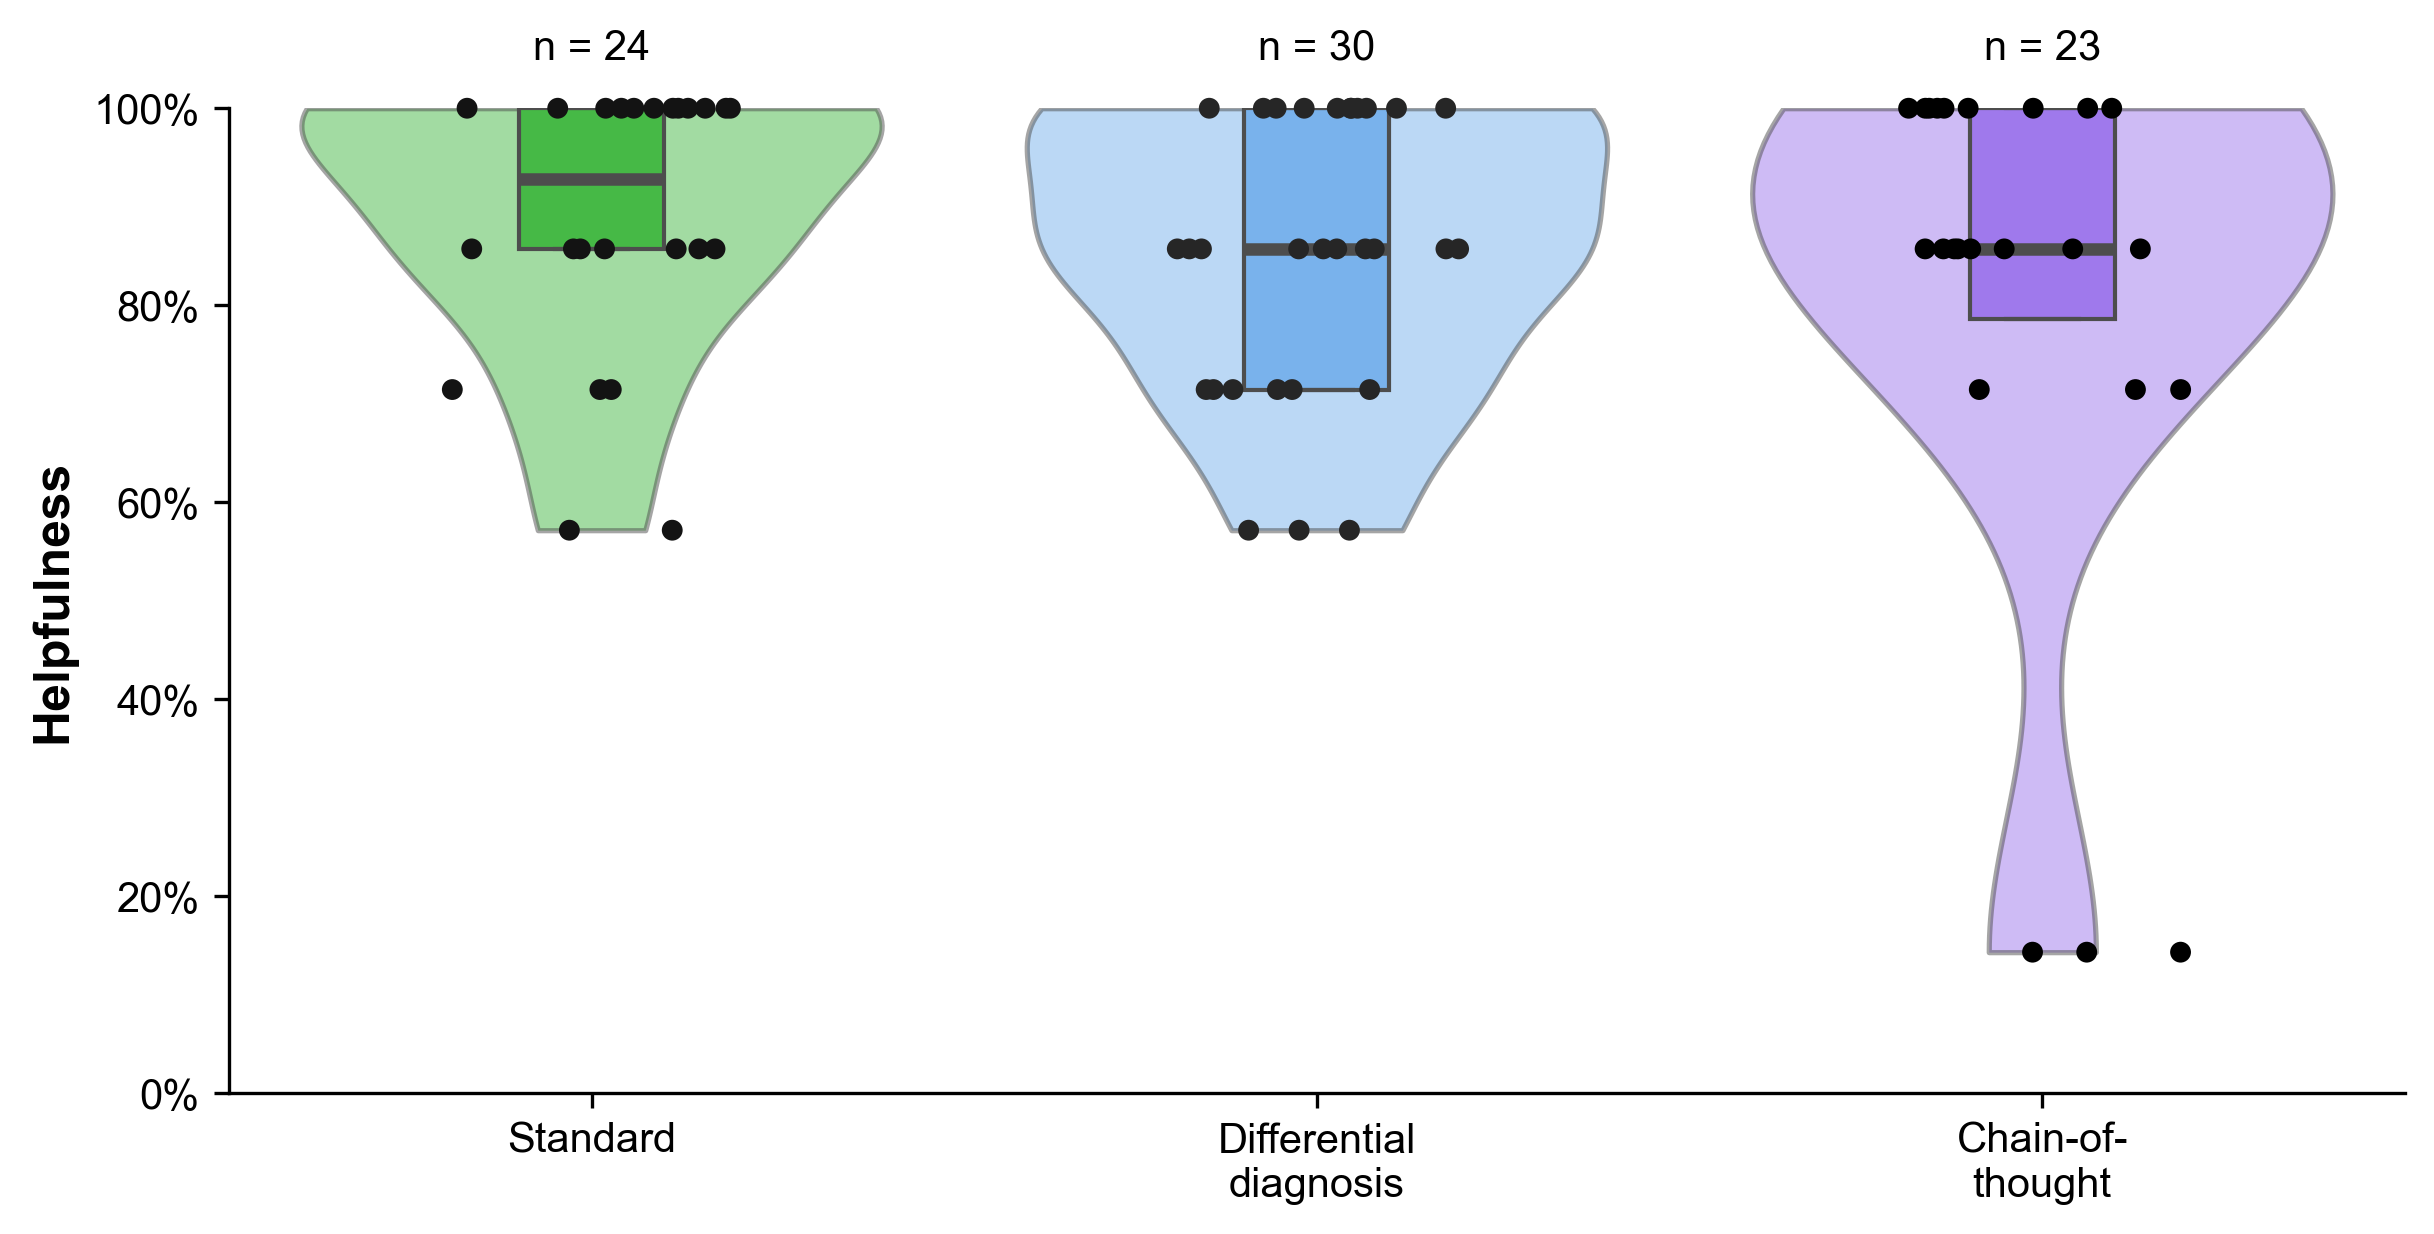

In [59]:
target = 'Helpfulness'
plot_dist(df_reg,target,skip_control=True, ylim=(0,100))
save_plot(target)

# Task load

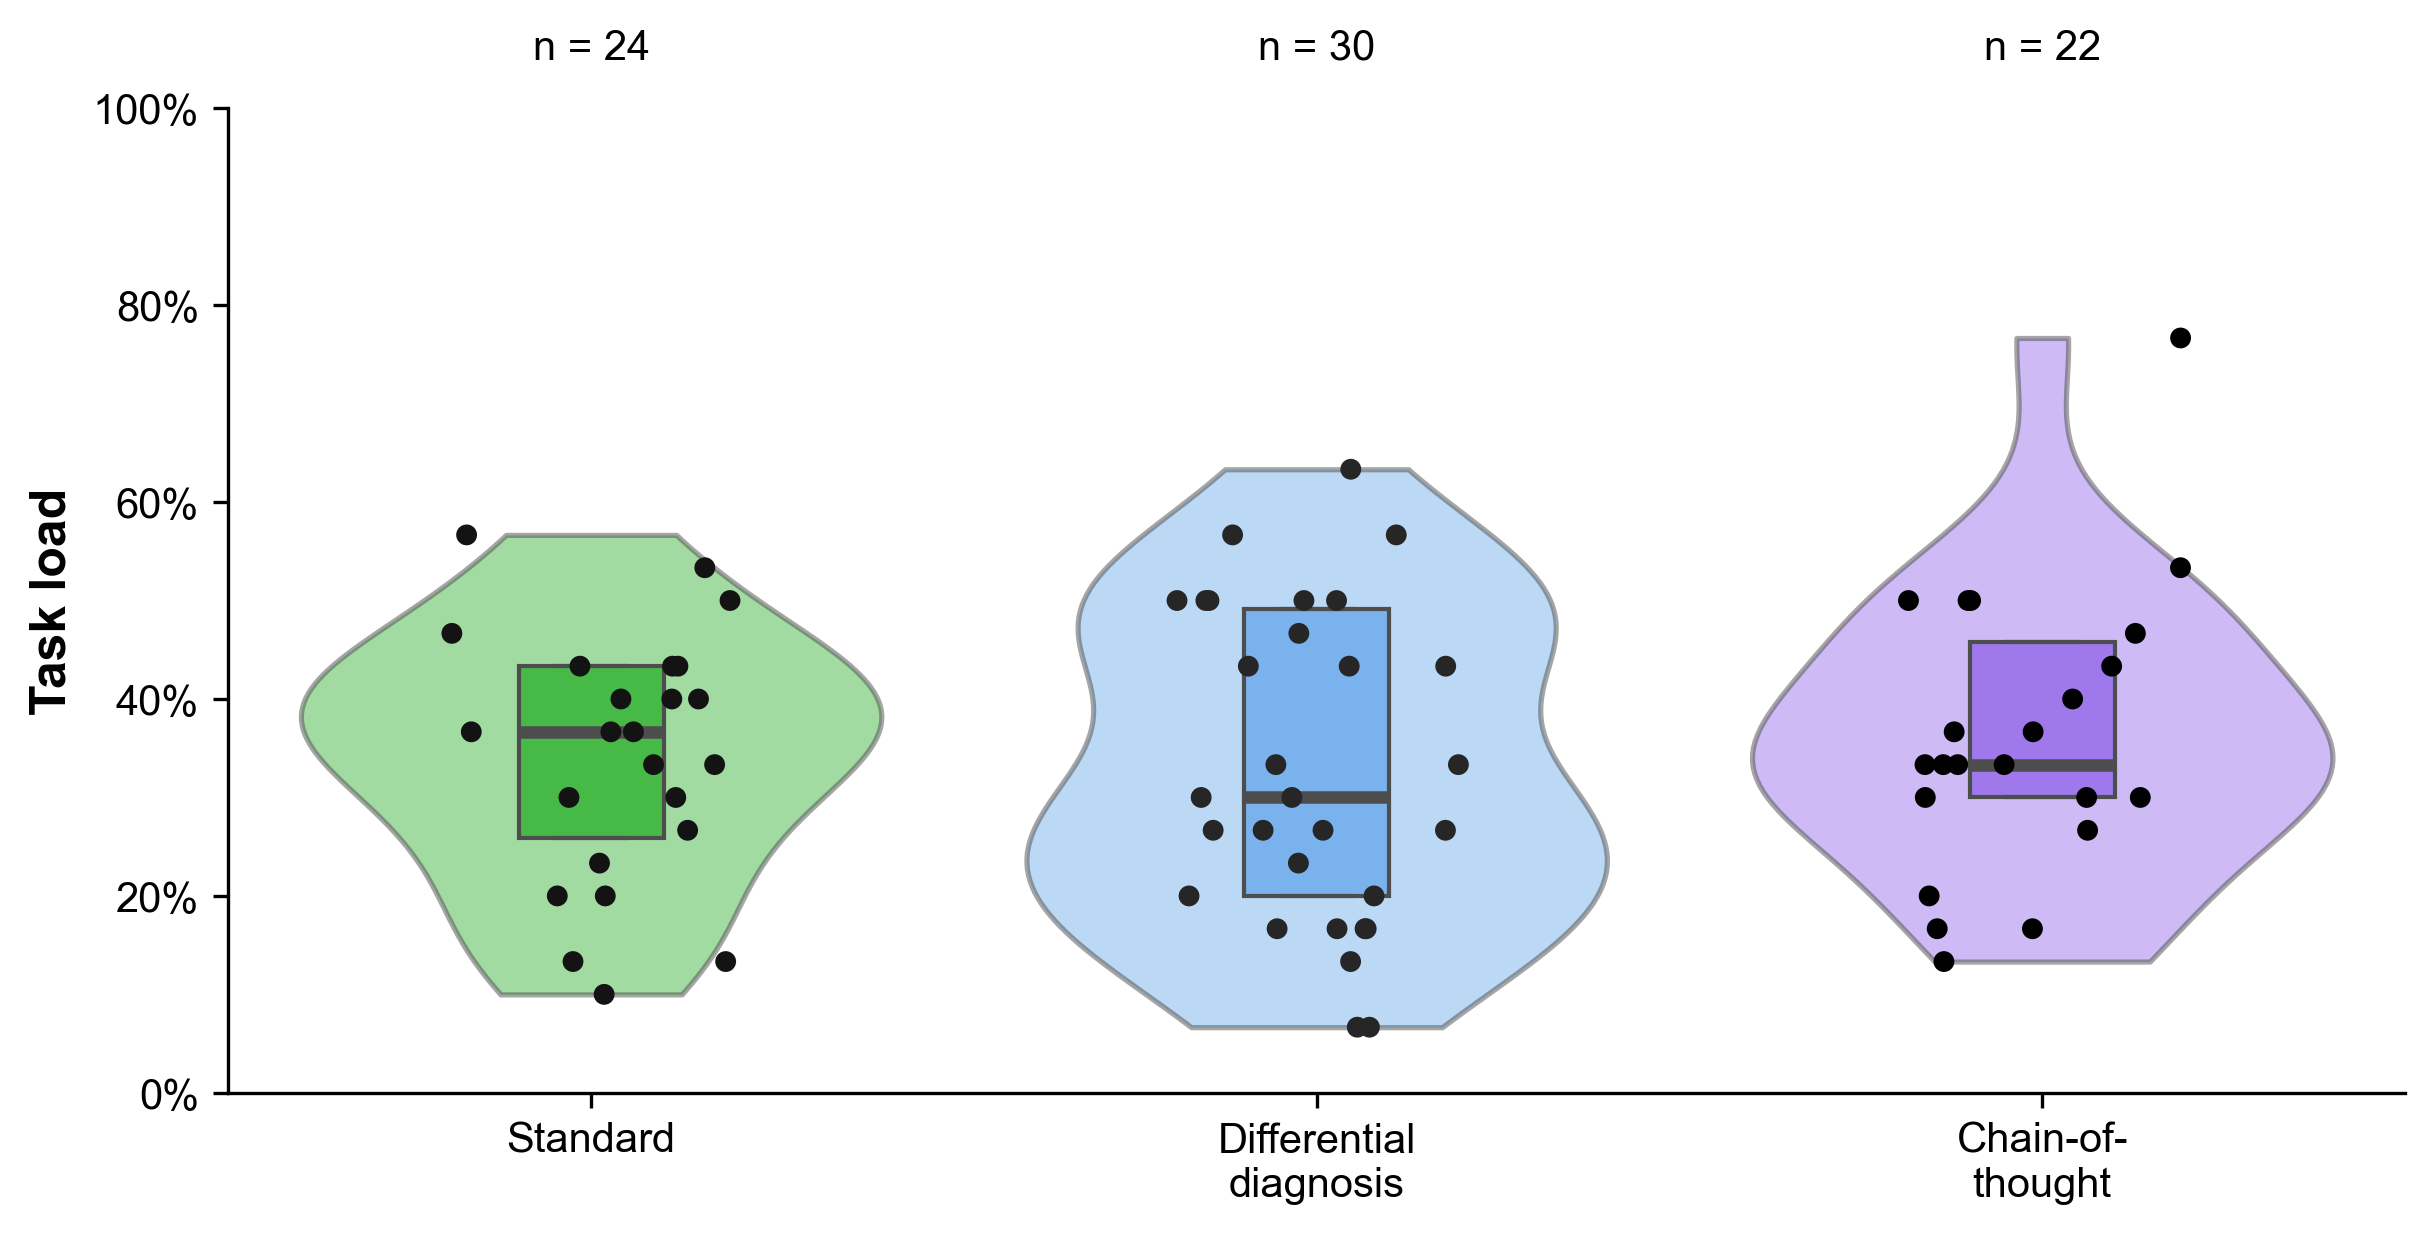

In [60]:
target = 'task-load'
plot_dist(df_reg,target,skip_control=True, ylim=(0,100))
save_plot(target)

In [61]:
control = df_agg.query('condition == "control"')['task-load'].dropna().to_list()
standard = df_agg.query('condition == "standard"')['task-load'].dropna().to_list()
cot = df_agg.query('condition == "chain-of-thought"')['task-load'].dropna().to_list()
dd = df_agg.query('condition == "differential"')['task-load'].dropna().to_list()

# Perform ANOVA
fvalue, pvalue = stats.f_oneway(control, standard, cot, dd)
print(f"ANOVA results: F-value = {fvalue:.3f}, p-value = {pvalue:.3f}")

# Control vs. Standard
t_statistic, p_value = one_sided_ttest(control, standard)
print(f"Control vs. Standard: t-statistic = {t_statistic:.3f}, p-value = {p_value:.3f}")

# Control vs. DD
t_statistic, p_value = one_sided_ttest(control, dd)
print(f"Control vs. DD: t-statistic = {t_statistic:.3f}, p-value = {p_value:.3f}")

# Control vs. CoT
t_statistic, p_value = one_sided_ttest(control, cot)
print(f"Control vs. CoT: t-statistic = {t_statistic:.3f}, p-value = {p_value:.3f}")

# Standard vs. CoT
t_statistic, p_value = one_sided_ttest(standard, cot)
print(f"Standard vs. CoT: t-statistic = {t_statistic:.3f}, p-value = {p_value:.3f}")

# DD vs. CoT
t_statistic, p_value = one_sided_ttest(dd, cot)
print(f"DD vs. CoT: t-statistic = {t_statistic:.3f}, p-value = {p_value:.3f}")

# Standard vs. DD
t_statistic, p_value = one_sided_ttest(standard, dd)
print(f"Standard vs. DD: t-statistic = {t_statistic:.3f}, p-value = {p_value:.3f}")

ANOVA results: F-value = 1.324, p-value = 0.271
Control vs. Standard: t-statistic = 1.649, p-value = 0.947
Control vs. DD: t-statistic = 1.813, p-value = 0.962
Control vs. CoT: t-statistic = 1.007, p-value = 0.840
Standard vs. CoT: t-statistic = -0.543, p-value = 0.295
DD vs. CoT: t-statistic = -0.762, p-value = 0.225
Standard vs. DD: t-statistic = 0.270, p-value = 0.606


# Usefulness

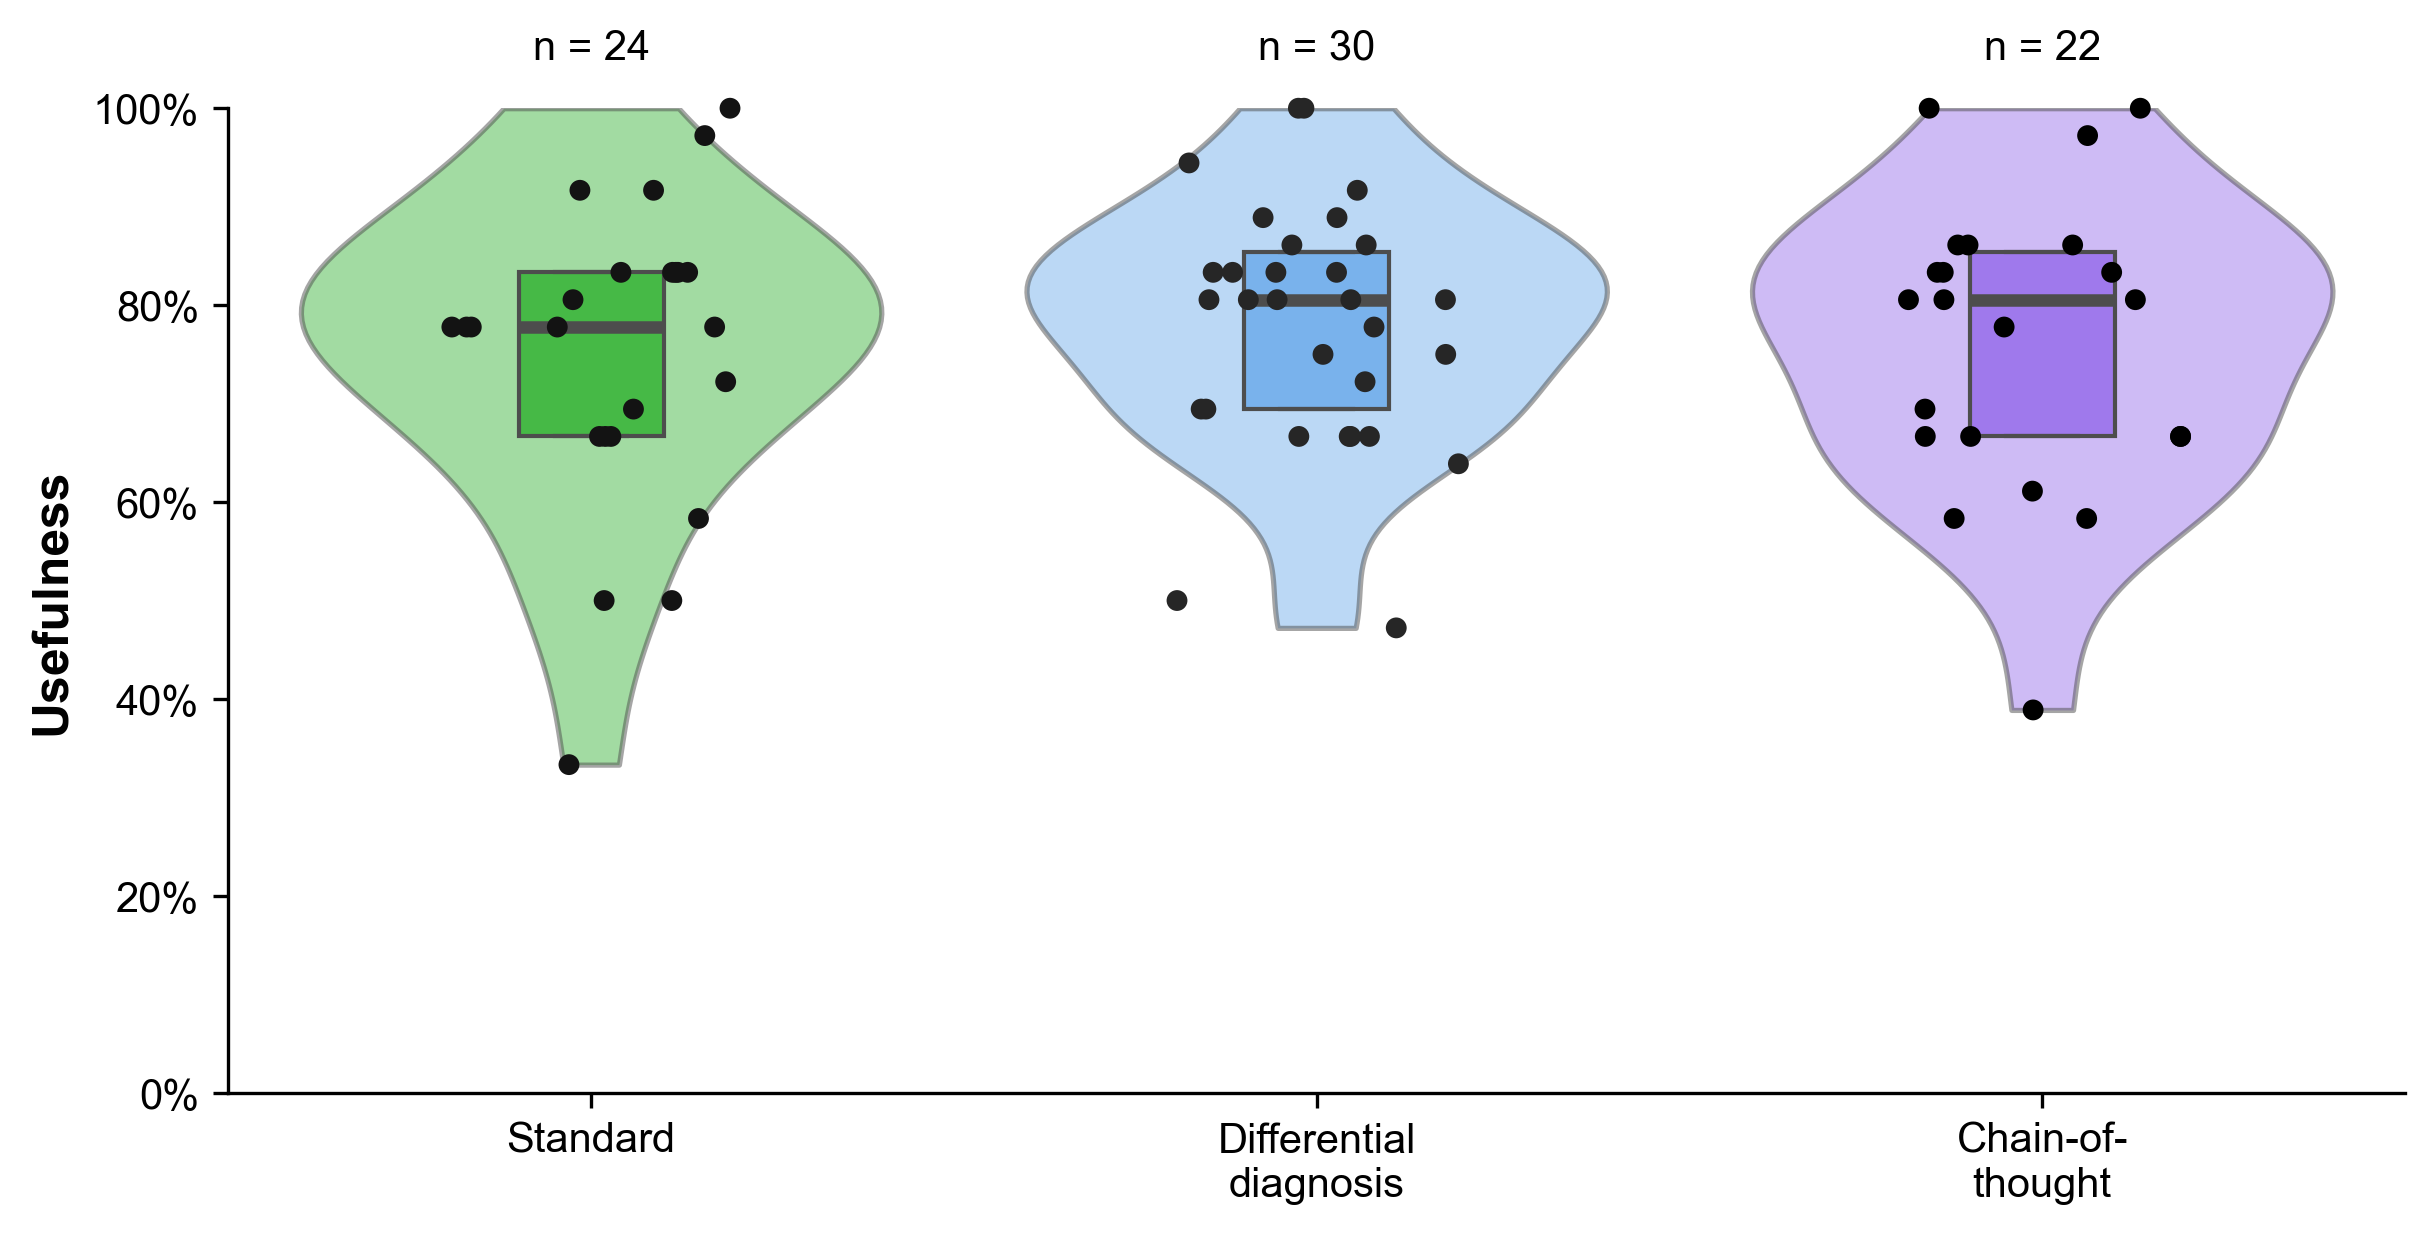

In [62]:
target = 'usefulness'
plot_dist(df_reg,target,skip_control=True, ylim=(0,100))
save_plot(target)

In [63]:
# target = 'usefulness'
# ax = sns.barplot(data=df_reg, x='condition', y=target, errorbar='sd',order=order[1:],
#                  hue='condition', hue_order=order[1:], palette=pal)
# sns.stripplot(data=df_agg, x='condition', y=target, hue='condition', marker='o', size=5, jitter=0.2, color='gray',clip_on=False)

# format_labs(xlab='')
# sample_sizes = df_reg.dropna(subset=[target]).query("condition != 'control'")['condition'].value_counts().reindex(order[1:])
# bar_annotate_n(sample_sizes)
# save_plot(target)

In [64]:
# control = df.query('condition == "control"')[target].to_list()
standard = df_reg.query('condition == "standard"')[target].dropna().to_list()
cot = df_reg.query('condition == "chain-of-thought"')[target].dropna().to_list()
dd = df_reg.query('condition == "differential"')[target].dropna().to_list()

fvalue, pvalue = stats.f_oneway(standard, cot, dd)
print(f"ANOVA results: F-value = {fvalue:.3f}, p-value = {pvalue:.3f}")

# Standard vs. CoT
t_statistic, p_value = one_sided_ttest(standard, cot)
print(f"Standard vs. CoT: t-statistic = {t_statistic:.3f}, p-value = {p_value:.3f}")

# DD vs. CoT
t_statistic, p_value = one_sided_ttest(dd, cot)
print(f"DD vs. CoT: t-statistic = {t_statistic:.3f}, p-value = {p_value:.3f}")

# Standard vs. DD
t_statistic, p_value = one_sided_ttest(standard, dd)
print(f"Standard vs. DD: t-statistic = {t_statistic:.3f}, p-value = {p_value:.3f}")

ANOVA results: F-value = 0.292, p-value = 0.748
Standard vs. CoT: t-statistic = -0.279, p-value = 0.391
DD vs. CoT: t-statistic = 0.431, p-value = 0.666
Standard vs. DD: t-statistic = -0.755, p-value = 0.227


# Ease of use

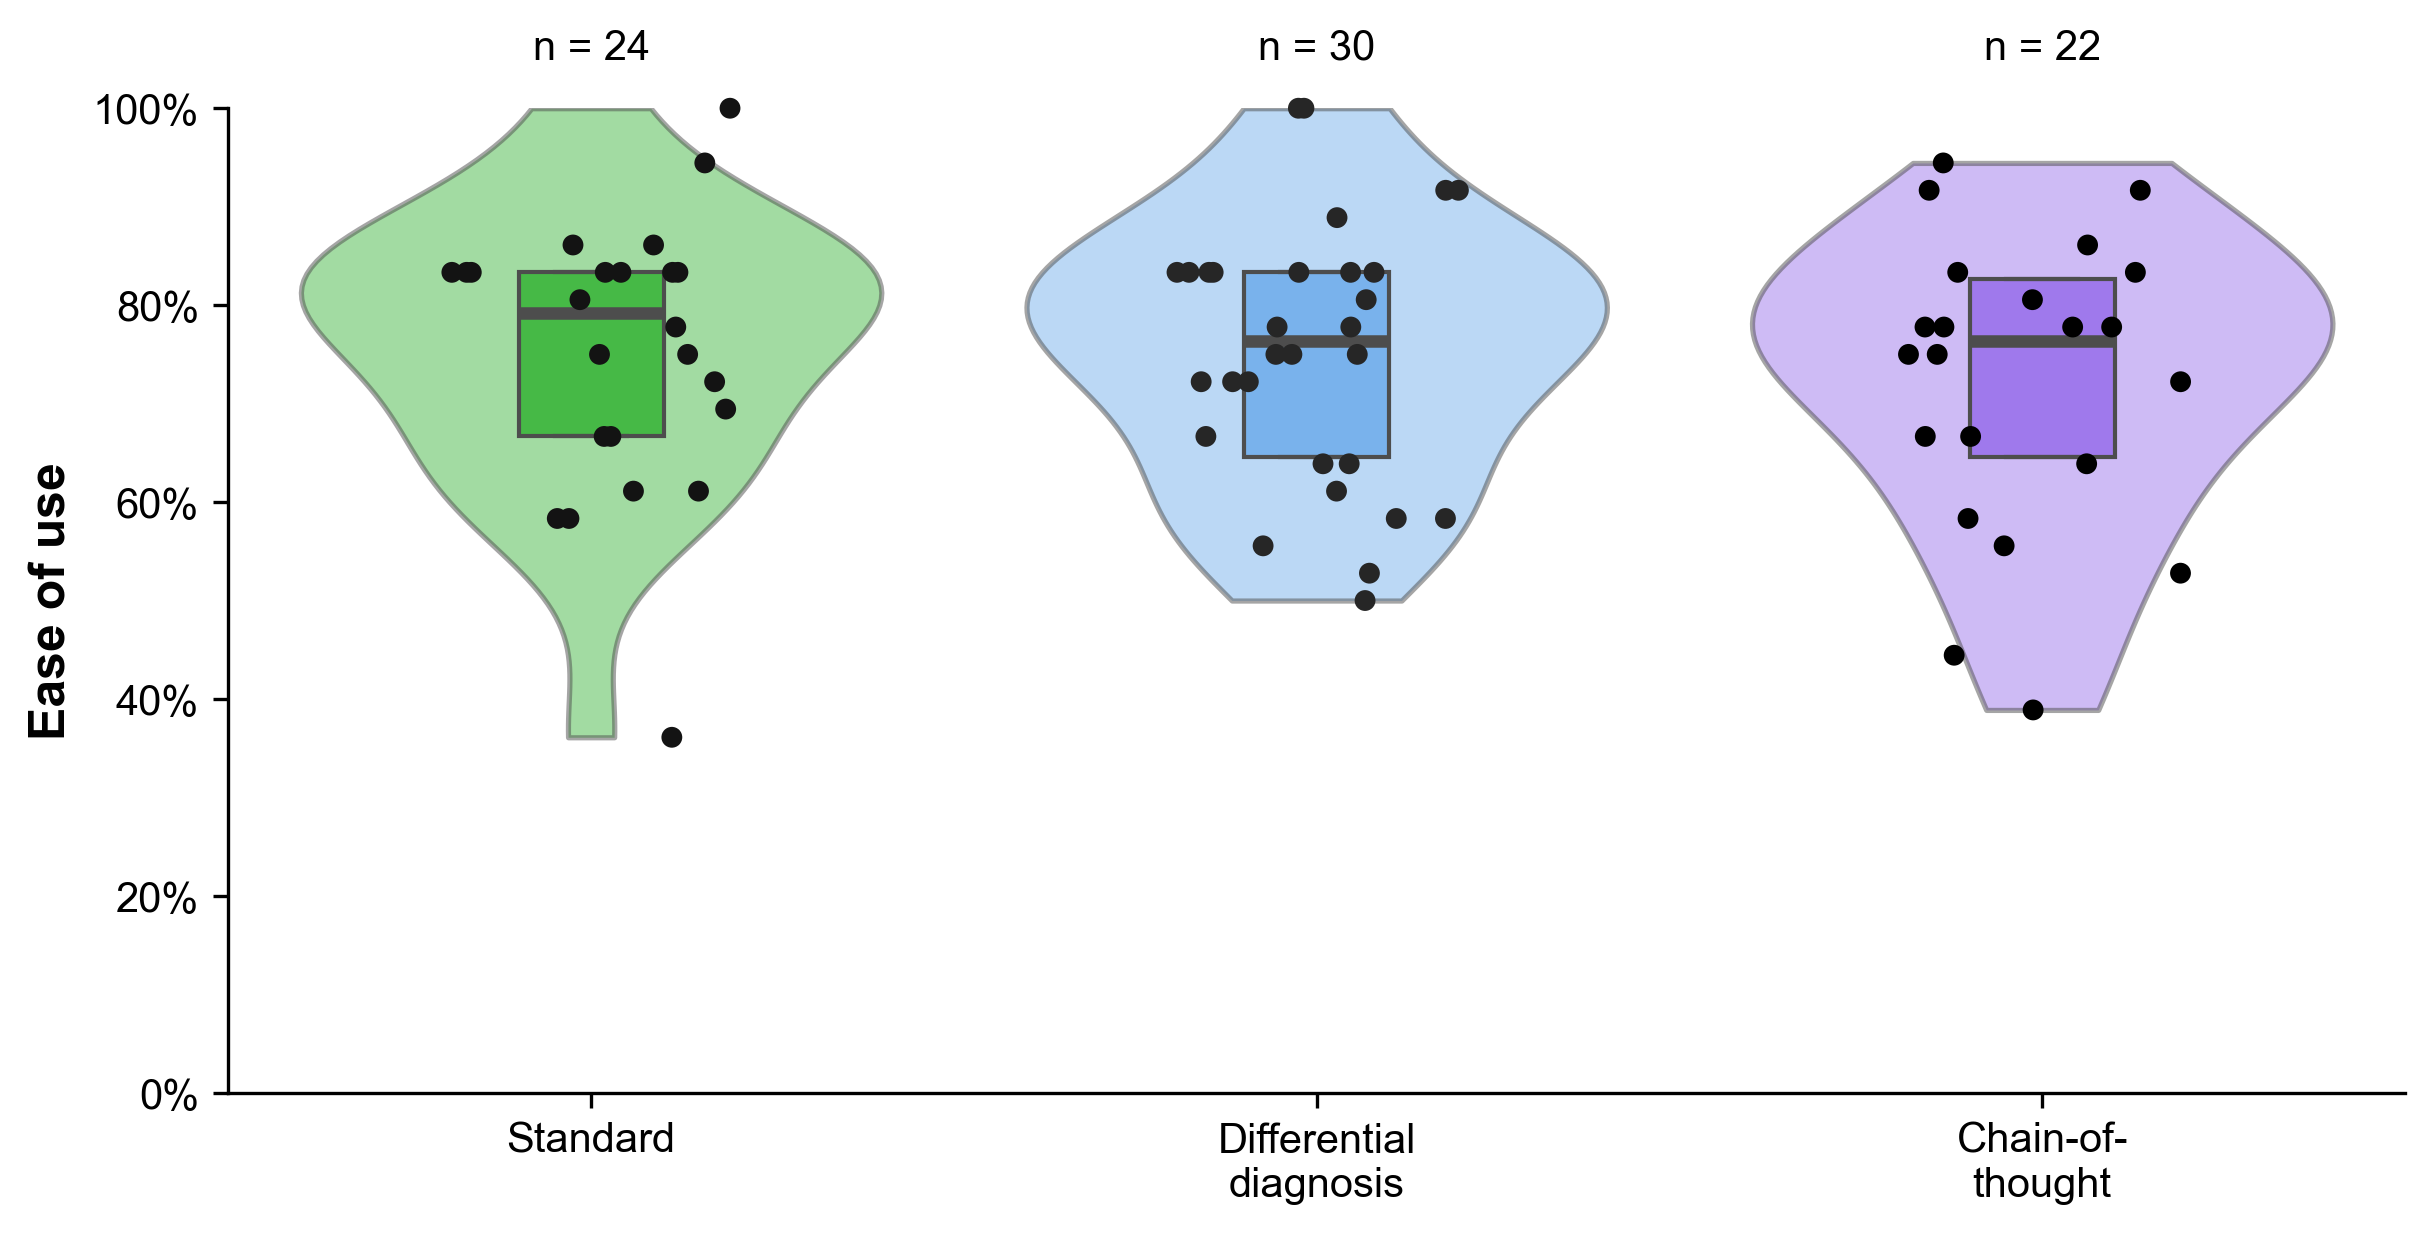

In [65]:
target = 'ease-of-use'
plot_dist(df_reg,target,skip_control=True, ylim=(0,100))
save_plot(target)

In [66]:
# control = df.query('condition == "control"')[target].to_list()
standard = df_reg.query('condition == "standard"')[target].dropna().to_list()
cot = df_reg.query('condition == "chain-of-thought"')[target].dropna().to_list()
dd = df_reg.query('condition == "differential"')[target].dropna().to_list()

fvalue, pvalue = stats.f_oneway(standard, cot, dd)
print(f"ANOVA results: F-value = {fvalue:.3f}, p-value = {pvalue:.3f}")

# Standard vs. CoT
t_statistic, p_value = one_sided_ttest(standard, cot)
print(f"Standard vs. CoT: t-statistic = {t_statistic:.3f}, p-value = {p_value:.3f}")

# DD vs. CoT
t_statistic, p_value = one_sided_ttest(dd, cot)
print(f"DD vs. CoT: t-statistic = {t_statistic:.3f}, p-value = {p_value:.3f}")

# Standard vs. DD
t_statistic, p_value = one_sided_ttest(standard, dd)
print(f"Standard vs. DD: t-statistic = {t_statistic:.3f}, p-value = {p_value:.3f}")

ANOVA results: F-value = 0.376, p-value = 0.688
Standard vs. CoT: t-statistic = 0.701, p-value = 0.757
DD vs. CoT: t-statistic = 0.774, p-value = 0.778
Standard vs. DD: t-statistic = -0.031, p-value = 0.488


# Trust

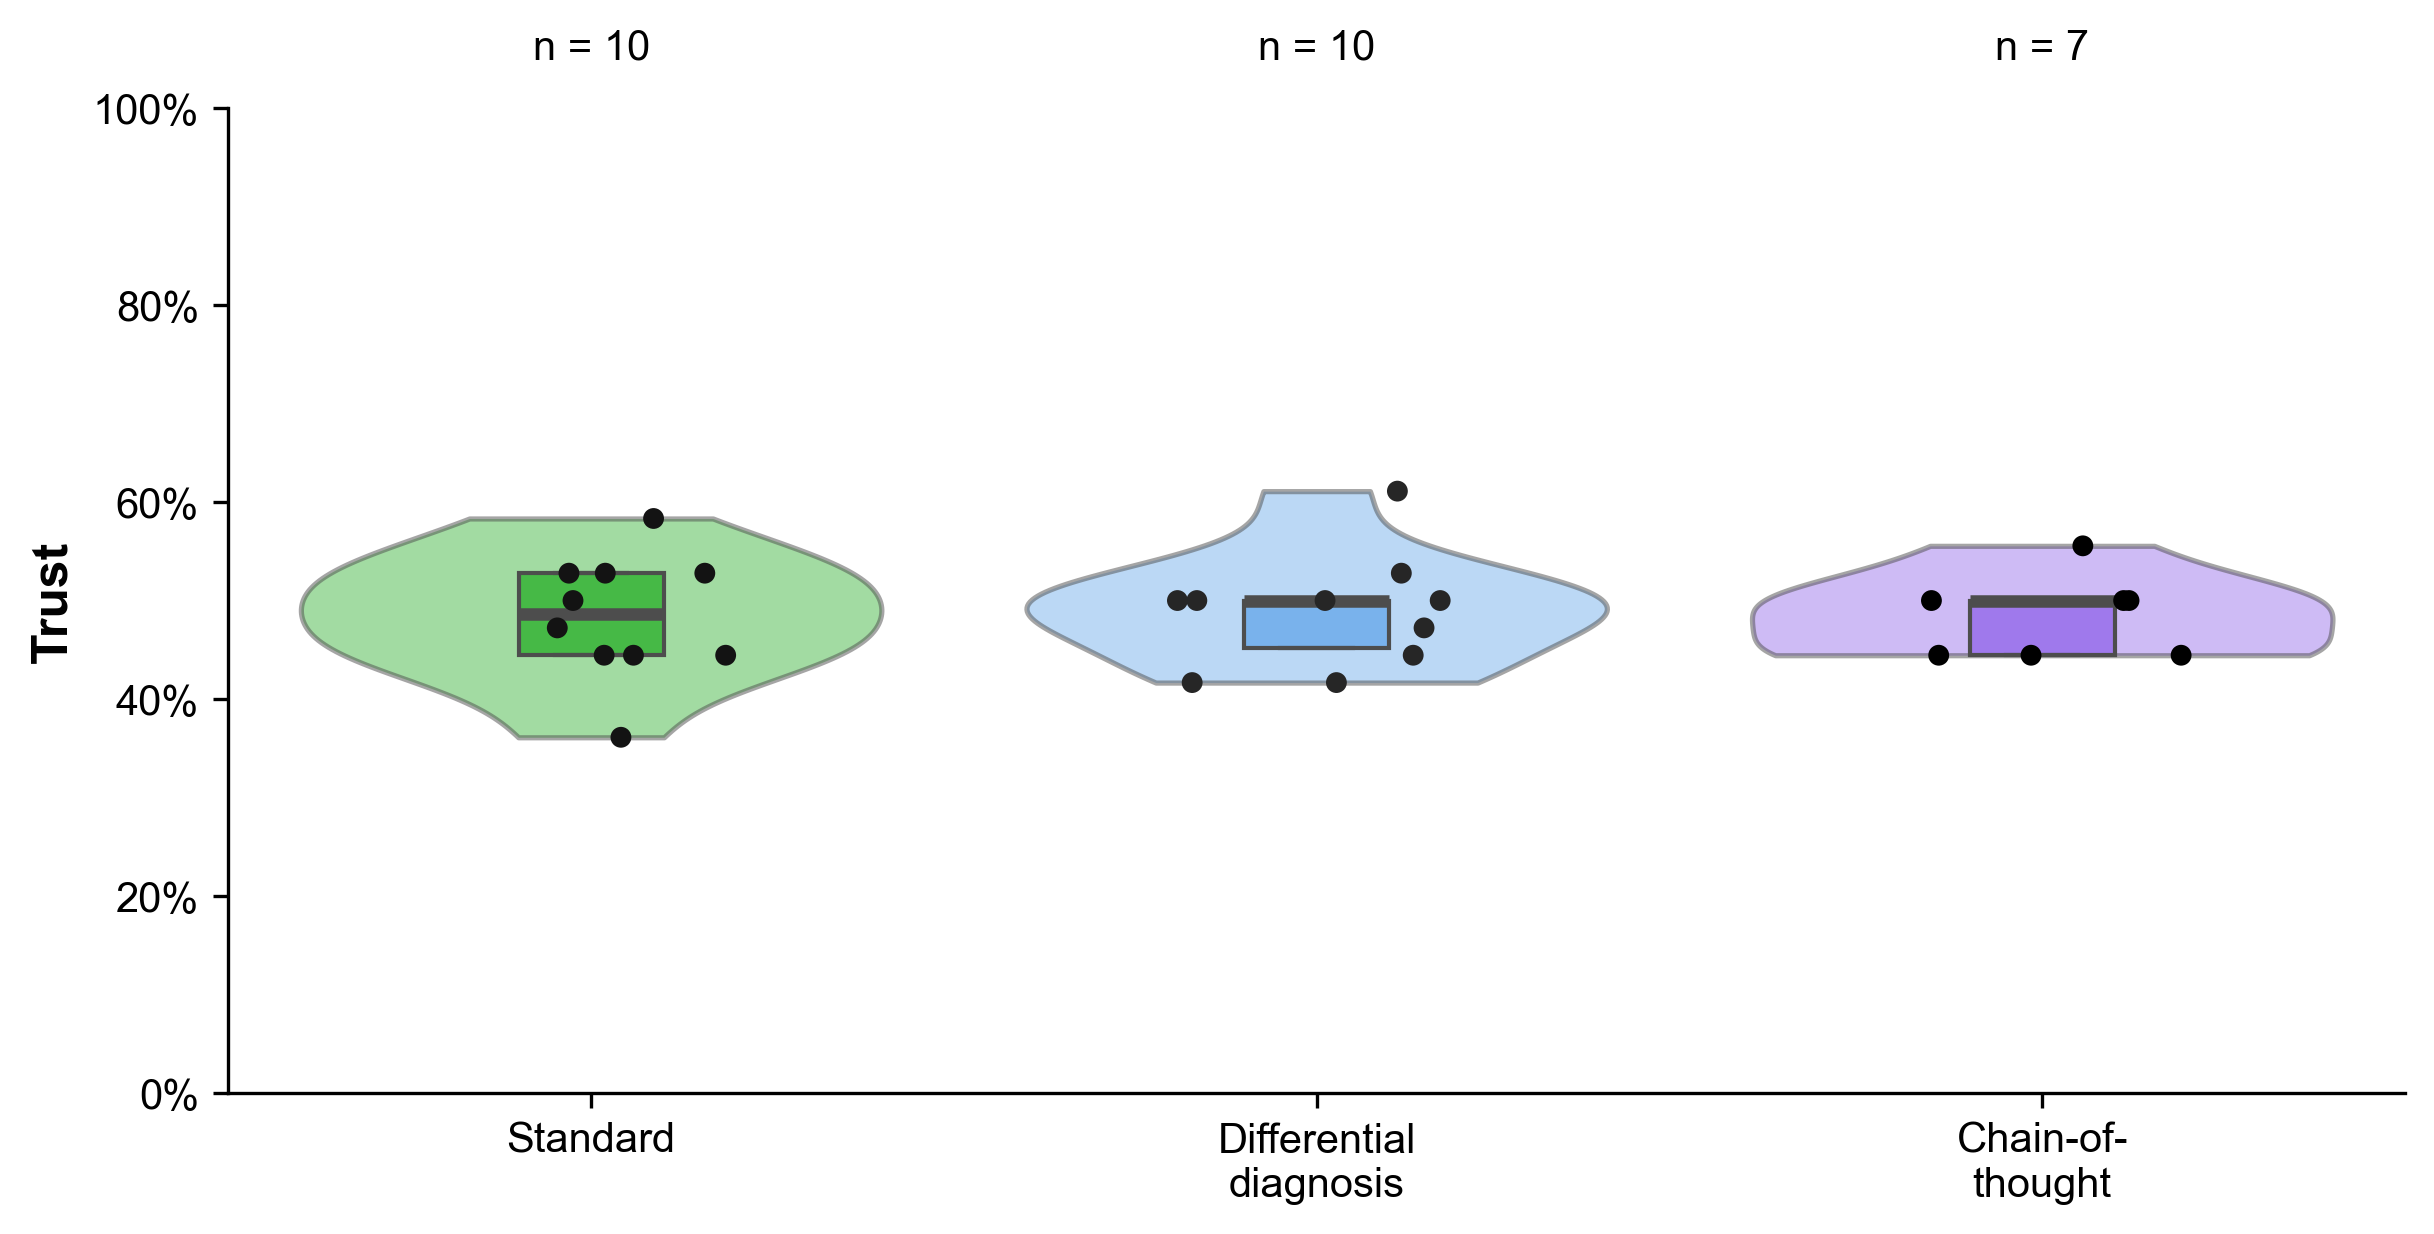

In [67]:
target = 'trust'
plot_dist(df_reg,target,skip_control=True, ylim=(0,100))
save_plot(target)

In [68]:
# control = df.query('condition == "control"')[target].to_list()
standard = df_reg.query('condition == "standard"')[target].dropna().to_list()
cot = df_reg.query('condition == "chain-of-thought"')[target].dropna().to_list()
dd = df_reg.query('condition == "differential"')[target].dropna().to_list()

fvalue, pvalue = stats.f_oneway(standard, cot, dd)
print(f"ANOVA results: F-value = {fvalue:.3f}, p-value = {pvalue:.3f}")

# Standard vs. CoT
t_statistic, p_value = one_sided_ttest(standard, cot)
print(f"Standard vs. CoT: t-statistic = {t_statistic:.3f}, p-value = {p_value:.3f}")

# DD vs. CoT
t_statistic, p_value = one_sided_ttest(dd, cot)
print(f"DD vs. CoT: t-statistic = {t_statistic:.3f}, p-value = {p_value:.3f}")

# Standard vs. DD
t_statistic, p_value = one_sided_ttest(standard, dd)
print(f"Standard vs. DD: t-statistic = {t_statistic:.3f}, p-value = {p_value:.3f}")

ANOVA results: F-value = 0.028, p-value = 0.973
Standard vs. CoT: t-statistic = -0.031, p-value = 0.488
DD vs. CoT: t-statistic = 0.198, p-value = 0.577
Standard vs. DD: t-statistic = -0.206, p-value = 0.420


# Adherence

In [69]:
map_values = {'less':'yes','more':'yes'}
# df_adh = prepare_adh_df(df,map_values)

In [70]:
# standard = df_adh.query('condition == "standard"')['Adherence'].to_list()
# cot = df_adh.query('condition == "chain-of-thought"')['Adherence'].to_list()
# dd = df_adh.query('condition == "differential"')['Adherence'].to_list()
# p_values = {}

# # Perform ANOVA
# fvalue, pvalue = stats.f_oneway(standard, cot, dd)
# print(f"ANOVA results: F-value = {fvalue:.3f}, p-value = {pvalue:.3f}")

# # Standard vs. CoT 
# t_statistic, p_value = one_sided_ttest(standard,cot)
# p_values[('standard', 'chain-of-thought')] = (t_statistic, p_value)
# print(f"CoT vs. Standard: t-statistic = {t_statistic:.3f}, p-value = {p_value:.3f}")

# # CoT vs. DD 
# t_statistic, p_value = one_sided_ttest(cot, dd)
# p_values[('differential', 'chain-of-thought')] = t_statistic,p_value
# print(f"DD vs. CoT: t-statistic = {t_statistic:.3f}, p-value = {p_value:.3f}")

# # Standard vs. DD
# t_statistic, p_value = one_sided_ttest(standard, dd)
# p_values[('standard', 'differential')] = t_statistic,p_value
# print(f"Standard vs. DD: t-statistic = {t_statistic:.3f}, p-value = {p_value:.3f}")

In [71]:
# def plot_adherence(df_adh,name):
#     standard = df_adh.query('condition == "standard"')['Adherence'].to_list()
#     cot = df_adh.query('condition == "chain-of-thought"')['Adherence'].to_list()
#     dd = df_adh.query('condition == "differential"')['Adherence'].to_list()
    
#     p_values = {}
#     p_values[('standard', 'chain-of-thought')] = one_sided_ttest(standard,cot)
#     p_values[('differential', 'chain-of-thought')] = one_sided_ttest(cot, dd)
#     p_values[('standard', 'differential')] = one_sided_ttest(standard, dd)

#     fig, ax = plt.subplots(1,1,figsize=(5,5))
#     sns.violinplot(df_adh, y='Adherence', x='condition',hue='condition',order=order[1:], hue_order=order[1:], ax=ax,cut=0, alpha=0.5, inner=None,palette=pal)
#     sns.boxplot(df_adh, y='Adherence', x='condition',hue='condition',order=order[1:], hue_order=order[1:], ax=ax,showfliers=False, width=0.3, whis=0,palette=pal)

#     ax.set_xlabel('')
#     ax.set_ylim(0,1)
#     ax.set_xticklabels([_.get_text().capitalize() for _ in ax.get_xticklabels()])
#     ax.grid(visible=True,which='major',axis='x')
#     ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
#     labels = [textwrap.fill(map_condition_label(tick.get_text()), width=12) for tick in ax.get_xticklabels()]
#     ax.set_xticklabels(labels, rotation=0)
#     # Add statistical annotations (e.g., p-values or significance stars)
#     for i, ((group1, group2), (t_val, p_val)) in enumerate(p_values.items()):
#         # Choose the positions for the annotations 
#         x1 = order[1:].index(group1)
#         x2 = order[1:].index(group2)
#         y_max = max(df_agg['correctness']) + 0.1 + i * 0.07  # some padding
        
#         # Annotate with a significance star based on the p-value
#         if p_val < 0.001: annotation = '***'
#         elif p_val < 0.01: annotation = '**'
#         elif p_val < 0.05: annotation = '*'
#         else: annotation = ''  # Not significant
        
#         # Add the annotation to the plot
#         if i < 3:
#             ax.plot([x1, x1, x2, x2], [y_max, y_max + 0.01,y_max+ 0.01, y_max], linewidth=0.5,color='black', clip_on=False)
#             ax.text((x1 + x2) / 2, y_max + 0.015, f'$P = {p_val:.3f}${annotation}', ha='center', va='bottom', fontsize=8)

#     plt.tight_layout()
#     ax.get_figure().savefig(f'../Results/Plots/adherence_{name}.pdf')

In [72]:
# map_values = {'less':'yes','more':'yes'}
# df_adh = prepare_adh_df(df,map_values)
# plot_adherence(df_adh,name="less_more_as_yes");

In [73]:
# map_values = {'less':'no','more':'no'}
# df_adh = prepare_adh_df(df,map_values)
# plot_adherence(df_adh,name="less_more_as_no");

In [74]:
df_adh_map = pd.read_excel('../Data/adherence_summary.xlsx',).rename({'answer_participant':'answer'},axis=1)
df_adh = df[~(df.condition=='control')]
df_adh = pd.merge(df_adh.reset_index(),df_adh_map,how='left',on=['question','answer','condition'])

map_values = {'less':'no','more':'no'}
df_adh['Adherence'] = df_adh['Adherence'].replace(map_values).map({'yes':1,'no':0})
df_adh['LLM correct'] = (df_adh[['Diagnosis correctness','Explanation correctness']] == 'Yes').all(axis=1)
df_adh['Overriding'] = 1 - df_adh['Adherence']
# df_adh.groupby('condition')['Adherence'].mean(), df_adh.groupby('condition')['Overriding'].mean()

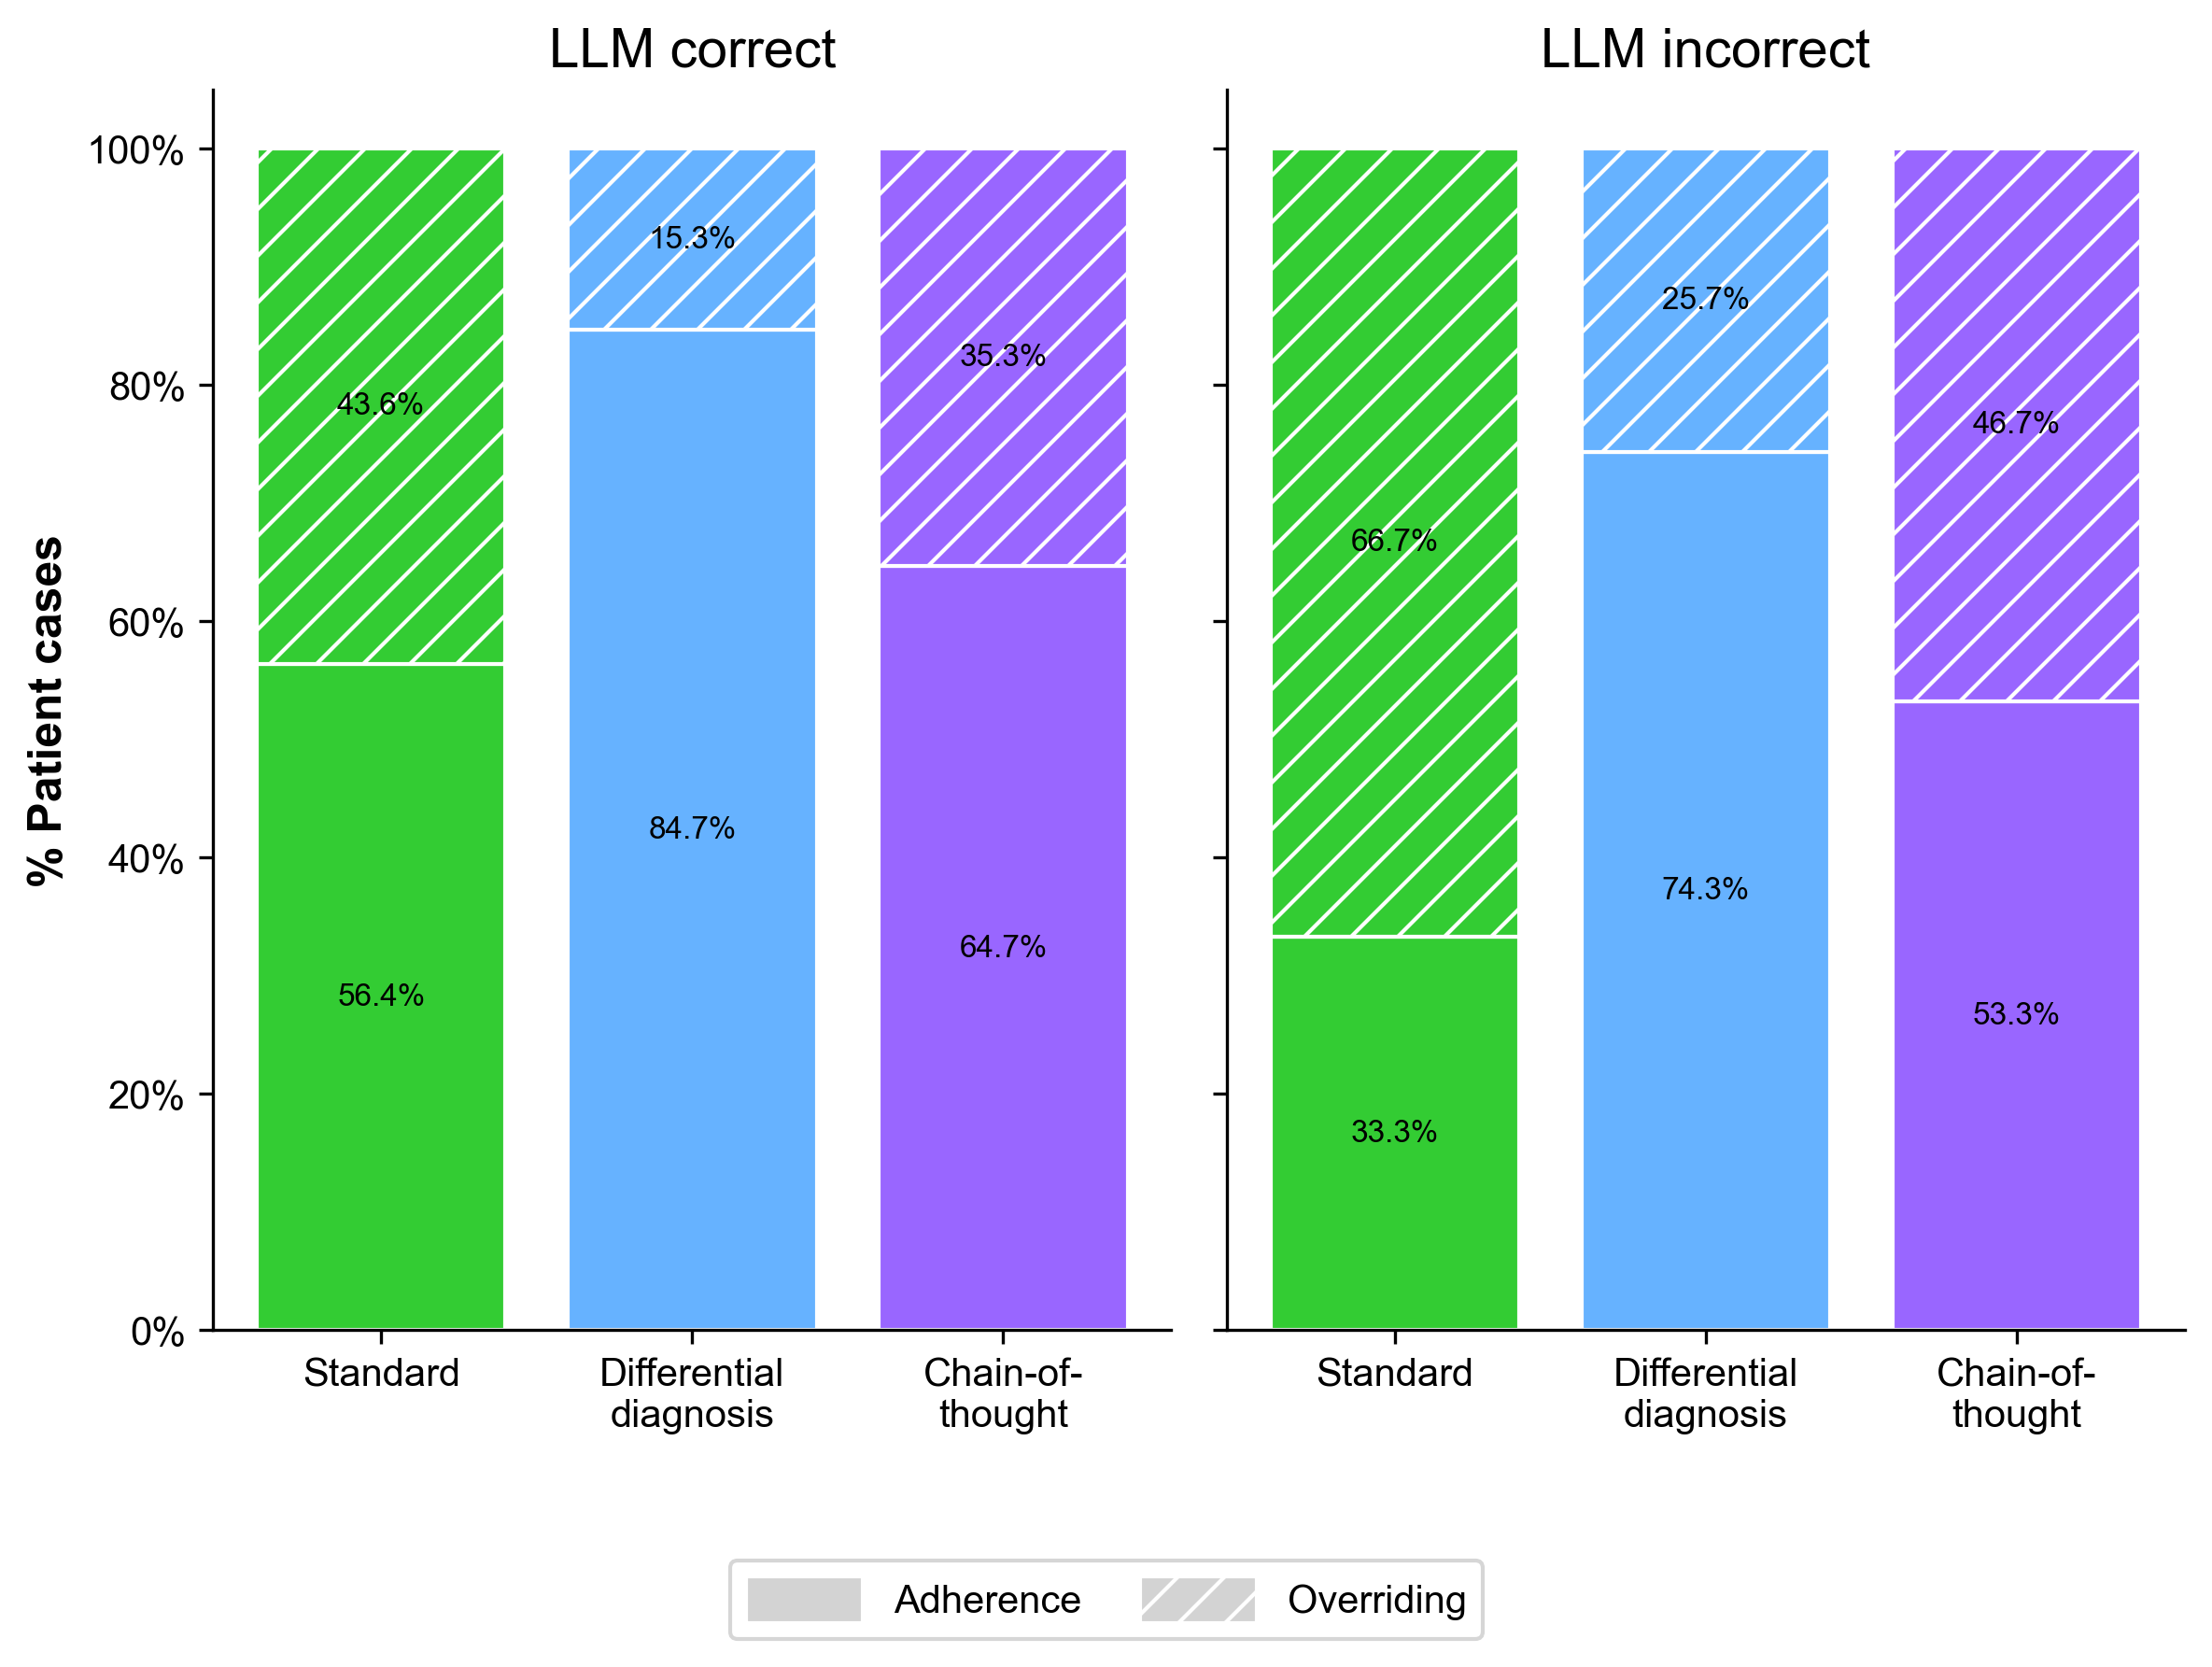

In [75]:
import matplotlib.patches as mpatches
import matplotlib.ticker as mtick

fig, axes = plt.subplots(1, 2, sharey=True, figsize=(8,6))
palette = ['#33cc33', '#66b2ff', '#9966ff', '#ff9900']
hatches = ['', '//']
    
for count, (ax, llm_correct) in enumerate(zip(axes, [True, False])):
    subset = df_adh[df_adh['LLM correct'] == llm_correct]
    
    # Group by condition
    df_plot = subset.groupby('condition')[['Adherence', 'Overriding']].mean()
    
    # Reindex to ensure proper order based on your 'order' variable
    # Exclude the last element if that's what your original code intended
    df_plot = df_plot.reindex(order[1:])
    
    bottoms = [0] * len(df_plot)
    for i, column in enumerate(df_plot.columns):
        bars = ax.bar(df_plot.index, df_plot[column], 
                      bottom=bottoms, color=palette, 
                      hatch=hatches[i], edgecolor='white', label=column)
        bottoms = [bottoms[j] + df_plot[column][j] for j in range(len(df_plot))]
        
        # Annotate the bars
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2, 
                    f'{height * 100:.1f}%', ha='center', va='center', color='black', fontsize=8)
        
    if llm_correct:
        ax.set_title(f"LLM correct")
    else:
        ax.set_title(f"LLM incorrect")
    ax.set_xticklabels([_.get_text().capitalize() for _ in ax.get_xticklabels()])
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
    labels = [textwrap.fill(map_condition_label(tick.get_text()), width=12) for tick in ax.get_xticklabels()]
    ax.set_xticklabels(labels, rotation=0)
    ax.set_xlabel('')
    
    if count == 0:
        ax.set_ylabel('% Patient cases')
        
    # Annotate the plots
    #ax.text(-0.1, 1.05, 'a' if count == 0 else 'b', transform=ax.transAxes, fontsize=12, fontweight='bold', va='top', ha='right')

# Create custom legend for hatches - outside the loop
legend_handles = [
    mpatches.Patch(facecolor='lightgrey', hatch=hatches[0], edgecolor='white', label="Adherence"),
    mpatches.Patch(facecolor='lightgrey', hatch=hatches[1], edgecolor='white', label="Overriding")
]

# Add the legend to the figure, not to a specific axis
fig.legend(
    handles=legend_handles, 
    loc='lower center',
    bbox_to_anchor=(0.5, -0.0),
    ncol=2, 
    fontsize=10,
    handlelength=3.0, 
    handleheight=1.5
)

# Add some extra space at the bottom for the legend
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)

try:
    fig.savefig(f'../Results/Plots/adherence_by_advice.pdf')
except FileNotFoundError:
    warnings.warn('Create "../Results/Plots folder" to save figure files')

In [76]:
df_adh[df_adh['LLM correct'] == True].condition.value_counts()#.sum()

condition
standard            312
differential        300
chain-of-thought    184
Name: count, dtype: int64

In [77]:
for llm_correct in [True, False]:
    print(f"LLM {llm_correct}")
    subset = df_adh[df_adh['LLM correct'] == llm_correct]

    standard = subset.query('condition == "standard"')['Adherence'].to_list()
    cot = subset.query('condition == "chain-of-thought"')['Adherence'].to_list()
    dd = subset.query('condition == "differential"')['Adherence'].to_list()
    p_values = {}

    # Perform ANOVA
    fvalue, pvalue = stats.f_oneway(standard, cot, dd)
    print(f"ANOVA results: F-value = {fvalue:.3f}, p-value = {pvalue:.3f}")

    # Standard vs. CoT 
    t_statistic, p_value = one_sided_ttest(standard,cot)
    p_values[('standard', 'chain-of-thought')] = (t_statistic, p_value)
    print(f"CoT vs. Standard: t-statistic = {t_statistic:.3f}, p-value = {p_value:.3f}")

    # CoT vs. DD 
    t_statistic, p_value = one_sided_ttest(cot, dd)
    p_values[('differential', 'chain-of-thought')] = t_statistic,p_value
    print(f"DD vs. CoT: t-statistic = {t_statistic:.3f}, p-value = {p_value:.3f}")

    # Standard vs. DD
    t_statistic, p_value = one_sided_ttest(standard, dd)
    p_values[('standard', 'differential')] = t_statistic,p_value
    print(f"Standard vs. DD: t-statistic = {t_statistic:.3f}, p-value = {p_value:.3f}")

LLM True
ANOVA results: F-value = 31.812, p-value = 0.000
CoT vs. Standard: t-statistic = -1.830, p-value = 0.034
DD vs. CoT: t-statistic = -4.874, p-value = 0.000
Standard vs. DD: t-statistic = -8.074, p-value = 0.000
LLM False
ANOVA results: F-value = 42.670, p-value = 0.000
CoT vs. Standard: t-statistic = -4.214, p-value = 0.000
DD vs. CoT: t-statistic = -5.364, p-value = 0.000
Standard vs. DD: t-statistic = -9.240, p-value = 0.000


In [78]:
def map_adherence(o):
    try: 
        o = int(o)
        return 1
    except ValueError: 
        return 0

adh_dd_top5 = pd.read_excel('../Data/adherence_eval_dd-top5.xlsx',usecols=['question','answer','condition','Adherence'])
adh_dd_top5['Adherence'] = adh_dd_top5.Adherence.map(map_adherence)#.value_counts(dropna=False)

df_adh_top5 = df[df.condition=='differential']
df_adh_top5 = pd.merge(df_adh_top5.reset_index(),adh_dd_top5,how='left',on=['question','answer','condition'])
df_adh_top5['LLM correct'] = (df_adh_top5[['Diagnosis correctness','Explanation correctness']] == 'Yes').all(axis=1)
df_adh_top5['Overriding'] = 1 - df_adh_top5['Adherence']

df_adh_top5 = pd.concat([
    df_adh[df_adh.condition!='differential'],
    df_adh_top5,   
], axis=0)

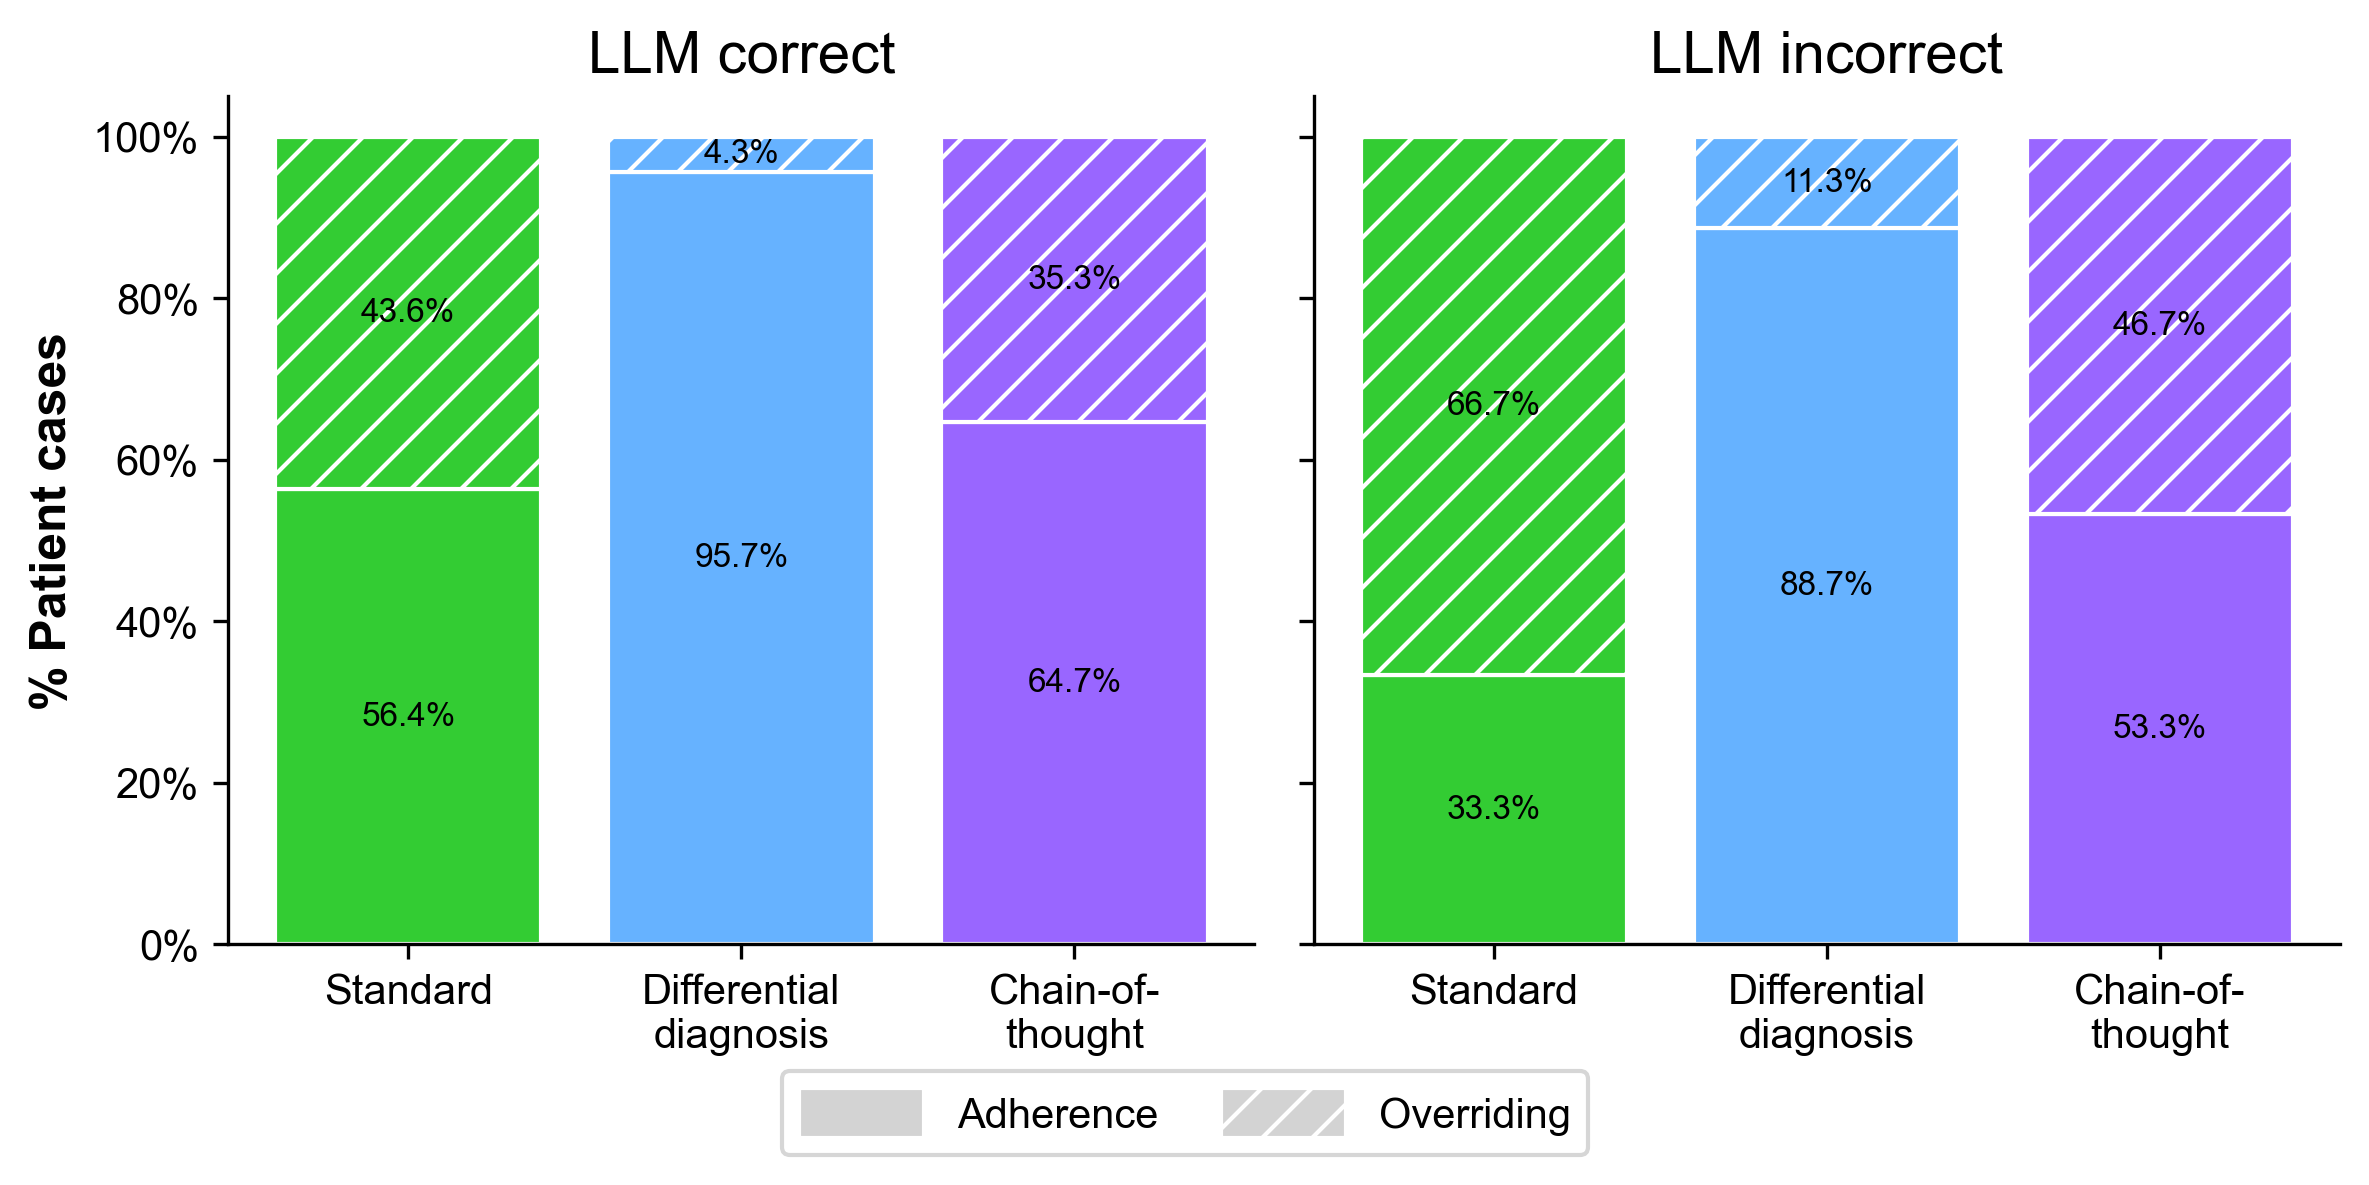

In [79]:
fig, axes = plt.subplots(1, 2, sharey=True)
palette = ['#33cc33', '#66b2ff', '#9966ff', '#ff9900']
hatches = ['', '//']

for count, (ax, llm_correct) in enumerate(zip(axes, [True, False])):
    subset = df_adh_top5[df_adh_top5['LLM correct'] == llm_correct]
    
    # Group by condition
    df_plot = subset.groupby('condition')[['Adherence', 'Overriding']].mean()
    
    # Reindex to ensure proper order based on your 'order' variable
    # Exclude the last element if that's what your original code intended
    df_plot = df_plot.reindex(order[1:])
    
    bottoms = [0] * len(df_plot)
    for i, column in enumerate(df_plot.columns):
        bars = ax.bar(df_plot.index, df_plot[column], 
                      bottom=bottoms, color=palette, 
                      hatch=hatches[i], edgecolor='white', label=column)
        bottoms = [bottoms[j] + df_plot[column][j] for j in range(len(df_plot))]
        
        # Annotate the bars
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2, 
                    f'{height * 100:.1f}%', ha='center', va='center', color='black', fontsize=8)
        
    if llm_correct:
        ax.set_title(f"LLM correct")
    else:
        ax.set_title(f"LLM incorrect")
    ax.set_xticklabels([_.get_text().capitalize() for _ in ax.get_xticklabels()])
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
    labels = [textwrap.fill(map_condition_label(tick.get_text()), width=12) for tick in ax.get_xticklabels()]
    ax.set_xticklabels(labels, rotation=0)
    ax.set_xlabel('')
    
    if count == 0:
        ax.set_ylabel('% Patient cases')
        
    # Annotate the plots
    # ax.text(-0.1, 1.05, 'a' if count == 0 else 'b', transform=ax.transAxes, fontsize=12, fontweight='bold', va='top', ha='right')

# Create custom legend for hatches - outside the loop
legend_handles = [
    mpatches.Patch(facecolor='lightgrey', hatch=hatches[0], edgecolor='white', label="Adherence"),
    mpatches.Patch(facecolor='lightgrey', hatch=hatches[1], edgecolor='white', label="Overriding")
]

# Add the legend to the figure, not to a specific axis
fig.legend(
    handles=legend_handles, 
    loc='lower center',
    bbox_to_anchor=(0.5, -0.0),
    ncol=2, 
    fontsize=10,
    handlelength=3.0, 
    handleheight=1.5
)

# Add some extra space at the bottom for the legend
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)

try:
    fig.savefig(f'../Results/Plots/adherence_by_advice_dd-top5.pdf')
except FileNotFoundError:
    warnings.warn('Create "../Results/Plots folder" to save figure files')

# Time analysis

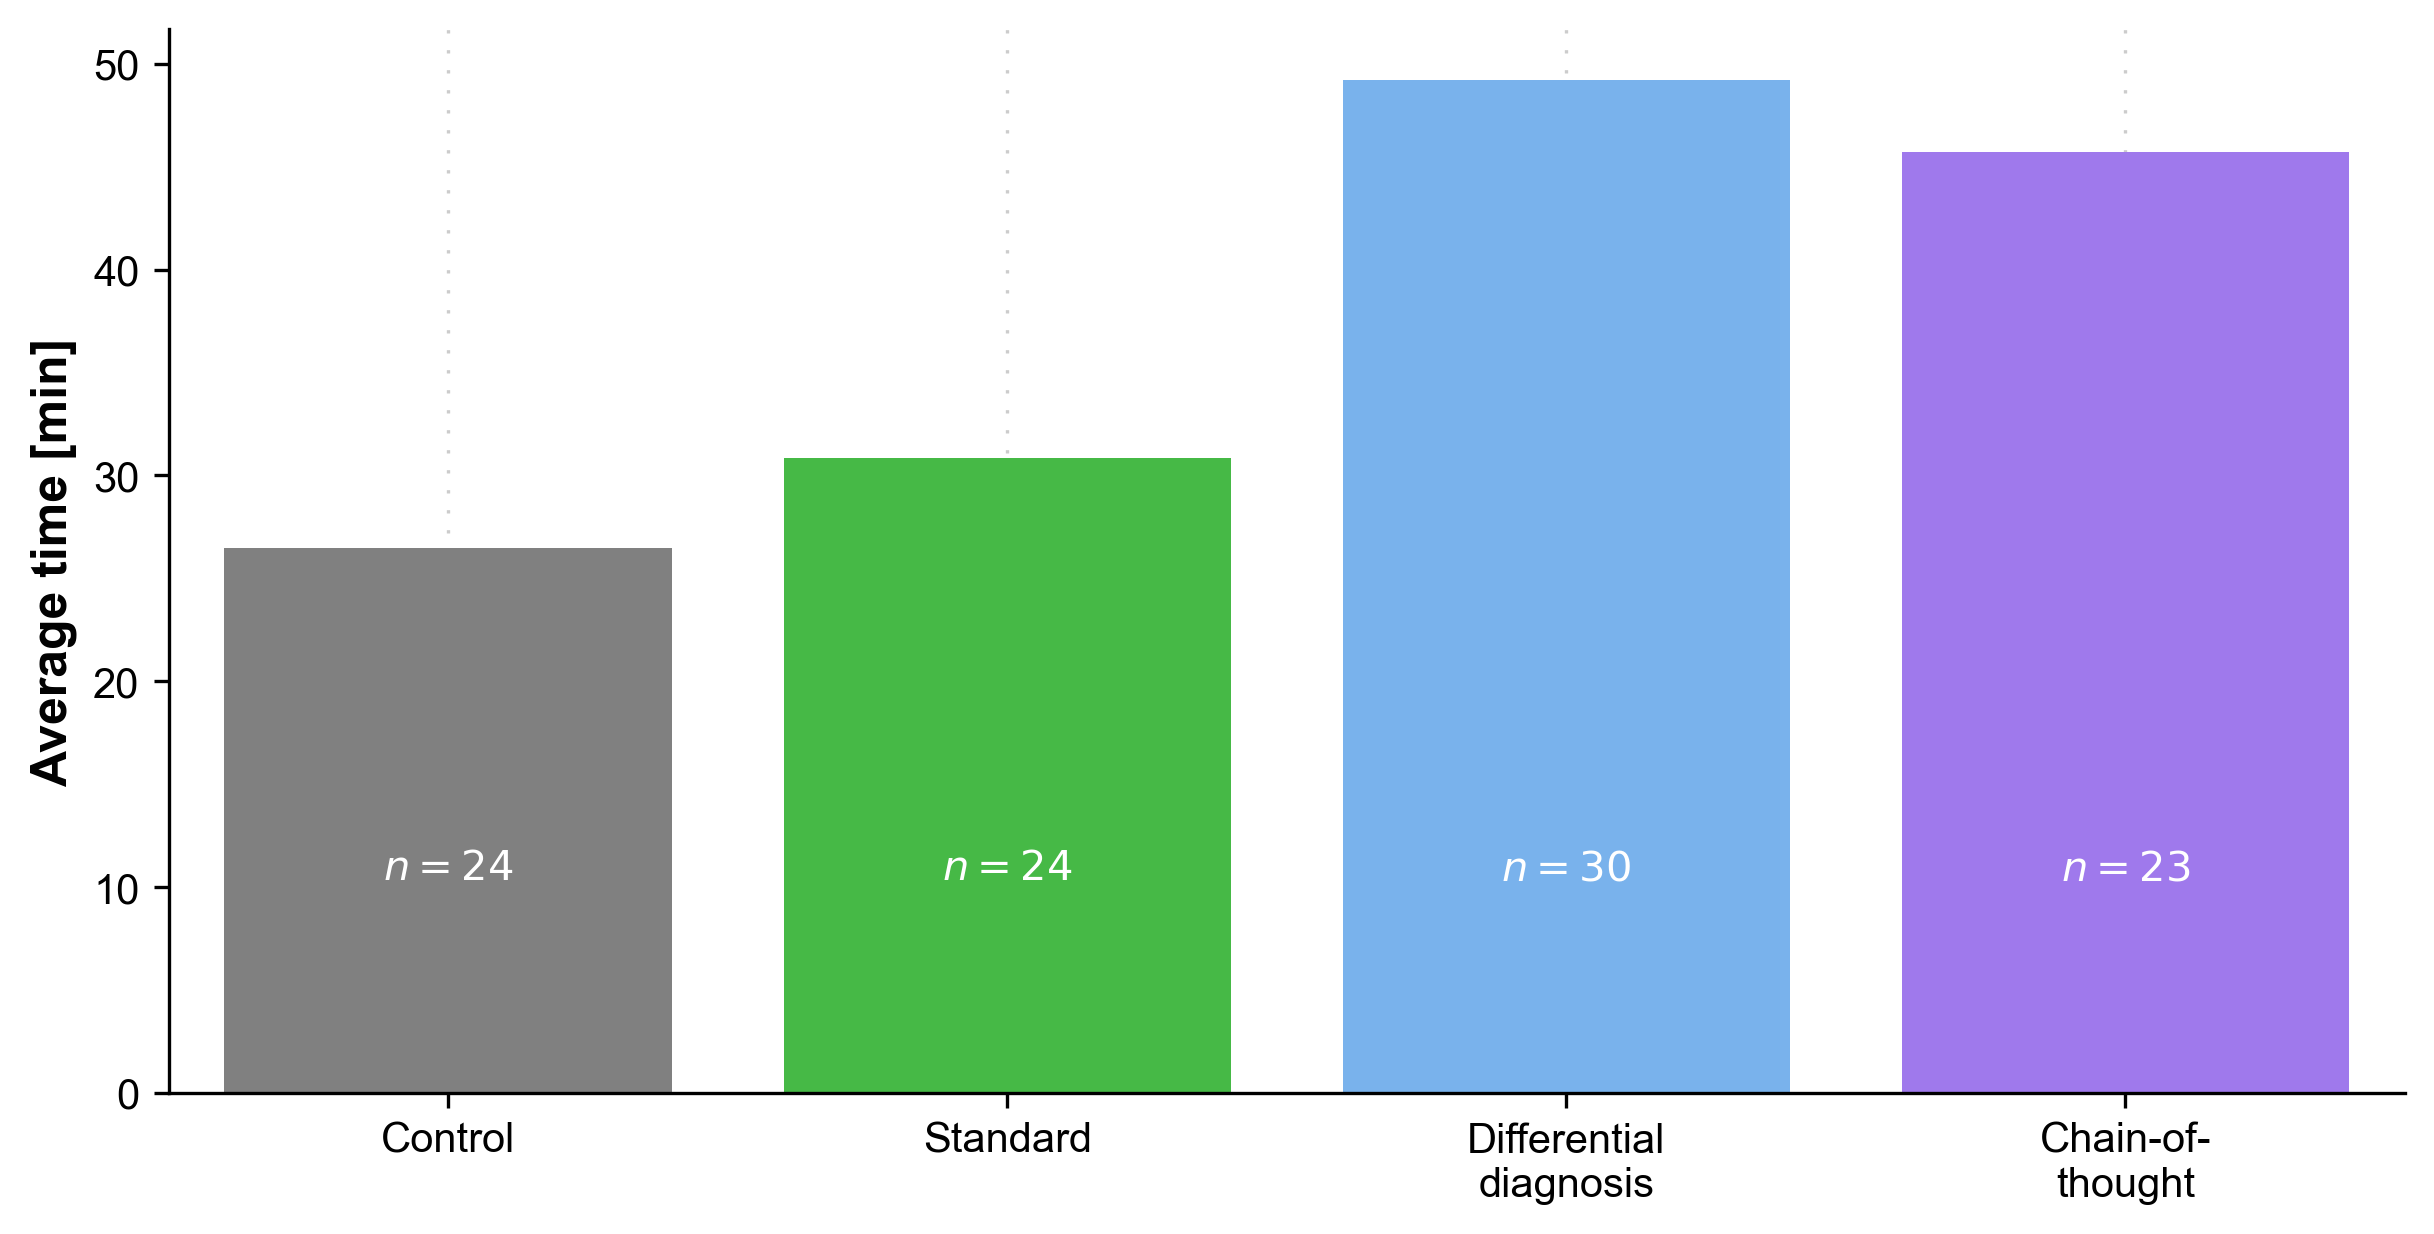

In [80]:
target = 'total-time'
ax = sns.barplot(data=df_reg, x='condition', y=target, errorbar=None,order=order,hue='condition',hue_order=order)

ax.set_xlabel(''); ax.set_ylabel('Average time [min]')
ax.set_xticklabels([_.get_text().capitalize() for _ in ax.get_xticklabels()])
ax.set_ylim(0,)
ax.grid(visible=True,which='major',axis='x')
labels = [textwrap.fill(map_condition_label(tick.get_text()), width=12) for tick in ax.get_xticklabels()]
ax.set_xticklabels(labels, rotation=0)

# Calculate sample sizes
sample_sizes = df_reg.dropna(subset=[target])['condition'].value_counts().reindex(order)

# Annotate bars with sample sizes
for bar, n in zip(ax.patches, sample_sizes):
    x = bar.get_x() + bar.get_width() / 2
    y = 10 #bar.get_height() - 10  # Add some padding to the height
    ax.text(x, y, f'$n={n}$', ha='center', va='bottom', fontsize=10, fontdict={'color': 'white'})

# Show and save plot
plt.show()

try:
    ax.get_figure().savefig(f'../Results/Plots/{target}.pdf')
except FileNotFoundError:
    warnings.warn('Create "../Results/Plots folder" to save figure files')

In [81]:
control = df_reg.query('condition == "control"')['total-time'].dropna().to_list()
standard = df_reg.query('condition == "standard"')['total-time'].dropna().to_list()
cot = df_reg.query('condition == "chain-of-thought"')['total-time'].dropna().to_list()
dd = df_reg.query('condition == "differential"')['total-time'].dropna().to_list()

# Perform ANOVA
fvalue, pvalue = stats.f_oneway(control, standard, cot, dd)
print(f"ANOVA results: F-value = {fvalue:.3f}, p-value = {pvalue:.3f}")

# Control vs. Standard
t_statistic, p_value = one_sided_ttest(control, standard)
print(f"Control vs. Standard: t-statistic = {t_statistic:.3f}, p-value = {p_value:.3f}")

# Control vs. DD
t_statistic, p_value = one_sided_ttest(control, dd)
print(f"Control vs. DD: t-statistic = {t_statistic:.3f}, p-value = {p_value:.3f}")

# Control vs. CoT
t_statistic, p_value = one_sided_ttest(control, cot)
print(f"Control vs. CoT: t-statistic = {t_statistic:.3f}, p-value = {p_value:.3f}")

# Standard vs. CoT
t_statistic, p_value = one_sided_ttest(standard, cot)
print(f"Standard vs. CoT: t-statistic = {t_statistic:.3f}, p-value = {p_value:.3f}")

# DD vs. CoT
t_statistic, p_value = one_sided_ttest(dd, cot)
print(f"DD vs. CoT: t-statistic = {t_statistic:.3f}, p-value = {p_value:.3f}")

# Standard vs. DD
t_statistic, p_value = one_sided_ttest(standard, dd)
print(f"Standard vs. DD: t-statistic = {t_statistic:.3f}, p-value = {p_value:.3f}")

ANOVA results: F-value = 0.743, p-value = 0.529
Control vs. Standard: t-statistic = -0.496, p-value = 0.312
Control vs. DD: t-statistic = -1.299, p-value = 0.102
Control vs. CoT: t-statistic = -1.246, p-value = 0.112
Standard vs. CoT: t-statistic = -0.870, p-value = 0.195
DD vs. CoT: t-statistic = 0.153, p-value = 0.561
Standard vs. DD: t-statistic = -0.968, p-value = 0.169


In [82]:
df_reg.groupby('condition')['total-time'].describe()

count       mean        std       min        25%        50%  \
condition                                                                       
chain-of-thought   23.0  45.731393  72.350877  7.571117  15.479367  19.699383   
control            24.0  26.456247  16.784756  7.965500  17.444946  23.458033   
differential       30.0  49.233742  94.198108  6.804783  15.112292  21.474558   
standard           24.0  30.828483  39.815680  4.180283  11.807375  17.912100   

                        75%         max  
condition                                
chain-of-thought  32.263258  333.790033  
control           30.215842   80.294350  
differential      35.403833  521.063550  
standard          37.883692  194.281533

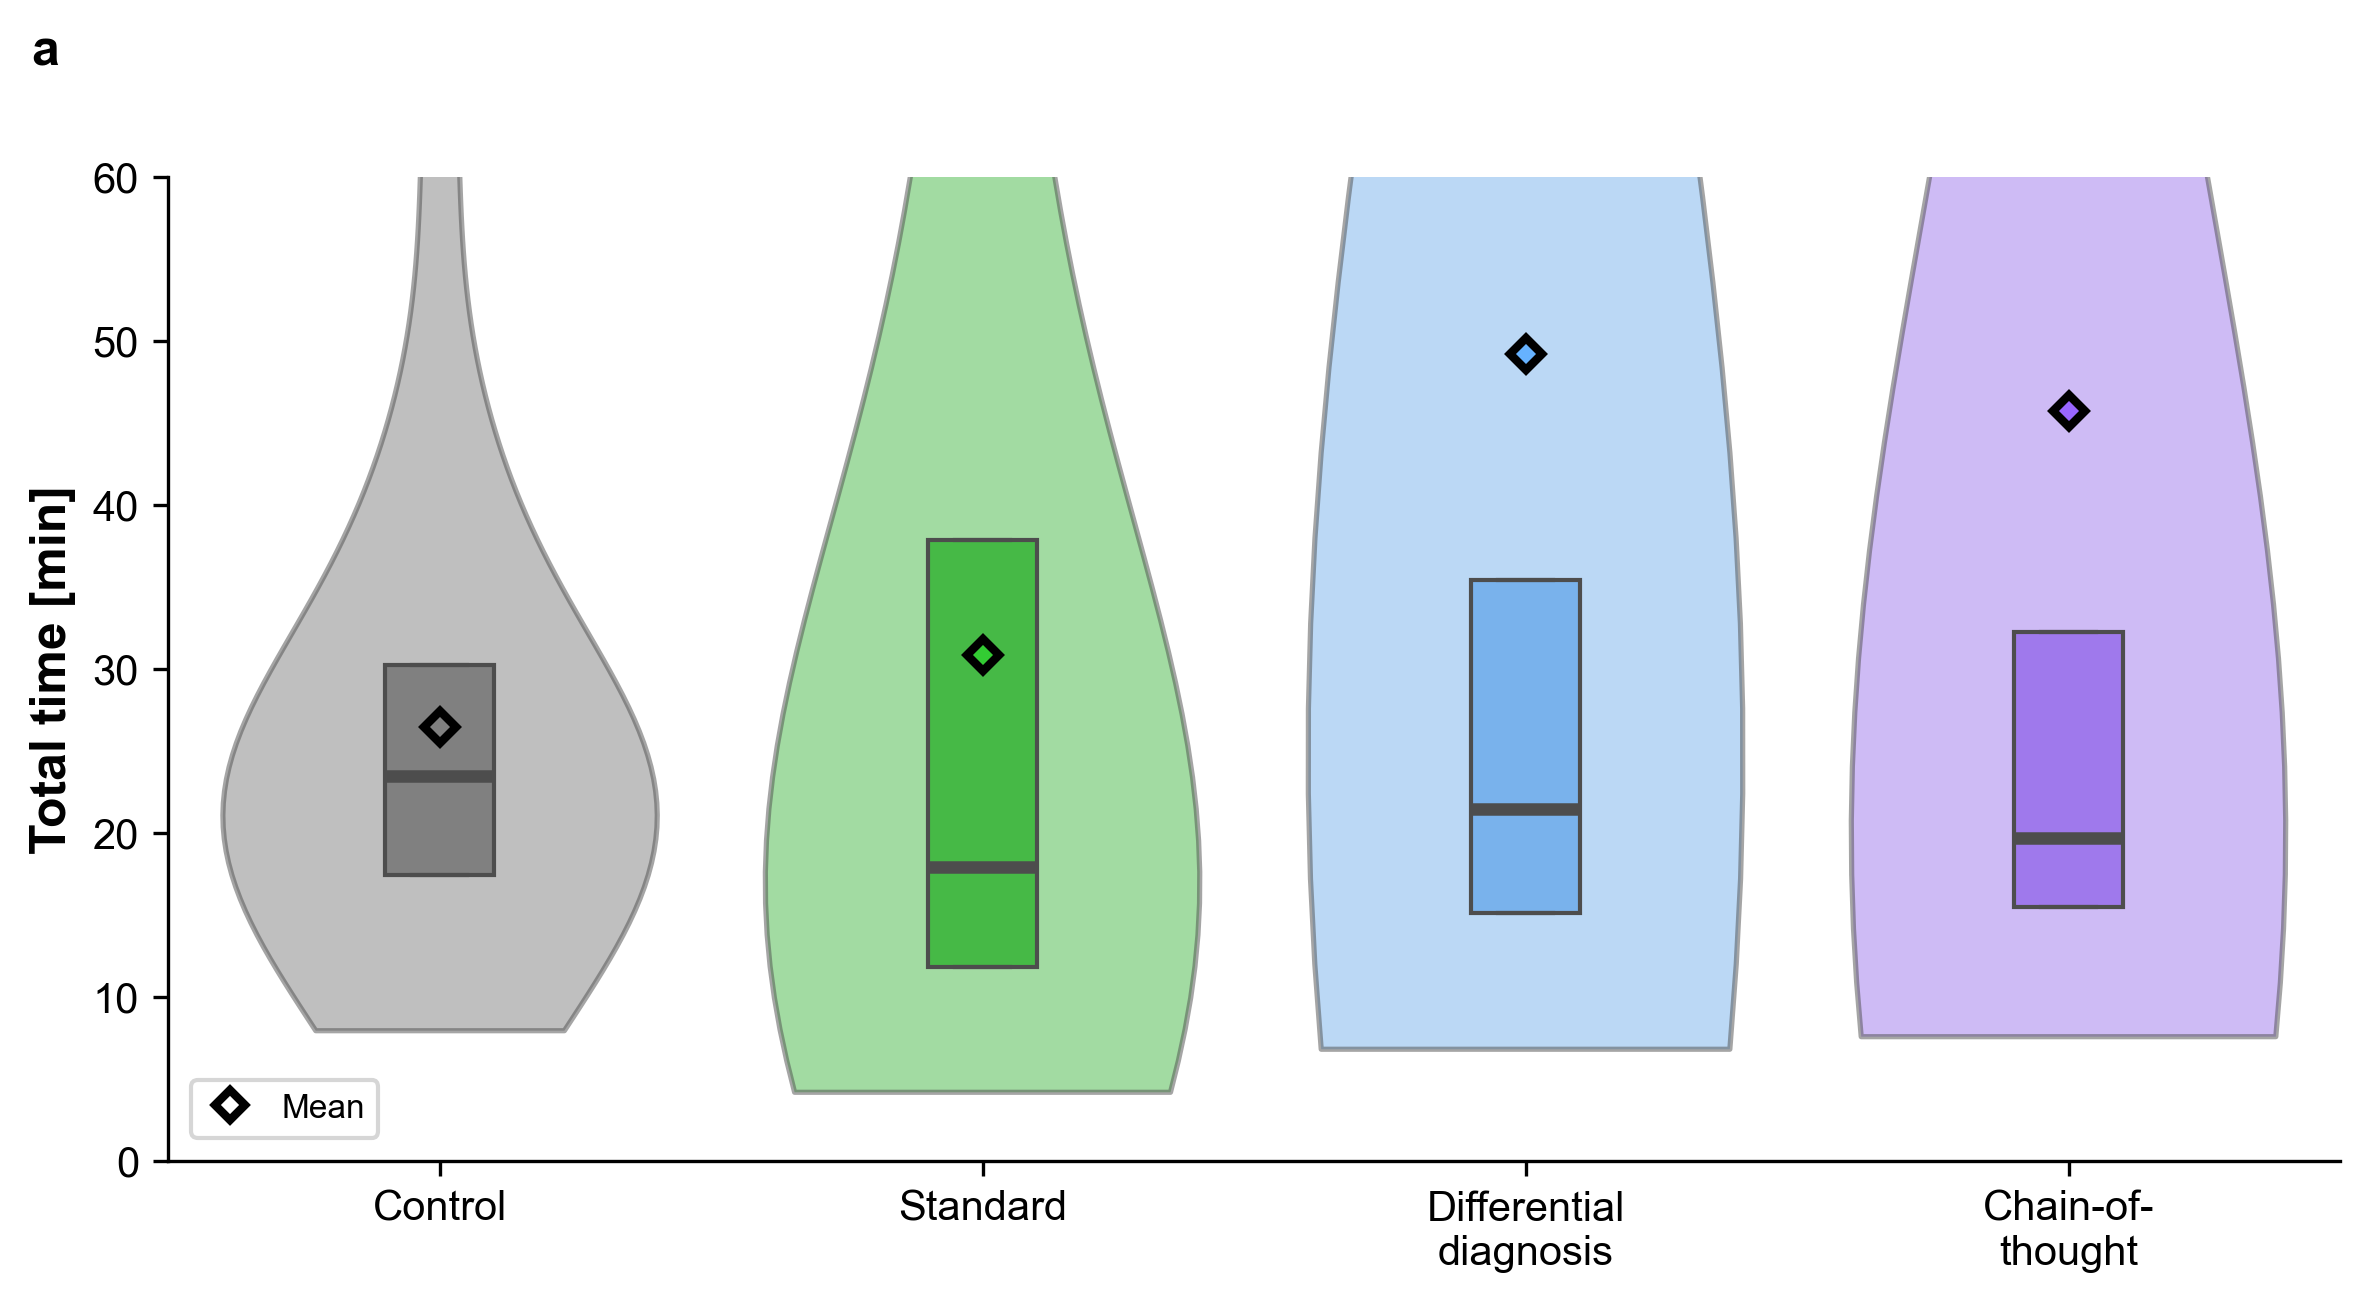

In [83]:
control = df_reg.query('condition == "control"')['total-time'].dropna().to_list()
standard = df_reg.query('condition == "standard"')['total-time'].dropna().to_list()
cot = df_reg.query('condition == "chain-of-thought"')['total-time'].dropna().to_list()
dd = df_reg.query('condition == "differential"')['total-time'].dropna().to_list()

p_values = {
    ('control', 'standard'): one_sided_ttest(control, standard),
    ('control', 'differential'): one_sided_ttest(control, dd),
    ('control', 'chain-of-thought'): one_sided_ttest(control, cot),
    ('standard', 'chain-of-thought'): one_sided_ttest(standard, cot),
    ('differential', 'chain-of-thought'): one_sided_ttest(dd, cot),
}

# select data and create plot
fig, ax = plt.subplots(1,1, )
box = sns.boxplot(data=df_reg, x='condition', y='total-time', order=order, hue='condition', hue_order=order,width=.2, showfliers=False, ax=ax, whis=0,medianprops={'linewidth': 3})
vio = sns.violinplot(data=df_reg, x='condition', y='total-time',alpha=0.5, hue='condition', hue_order=order, order=order, ax=ax, inner=None, cut=0)
for violin in vio.collections: violin.set_alpha(0.5) 
# gpt_performance_df = pd.DataFrame(list(gpt_performance.items()), columns=['condition', 'accuracy'])

sns.pointplot(data=df_reg, x='condition', y='total-time', estimator=np.mean,markers='D',scale=1,ax=ax, linestyles='',hue='condition',order=order,hue_order=order,errorbar=None)

# sns.pointplot(data=gpt_performance_df, x='condition', y='accuracy', markers='o', join=False, ax=ax, hue='condition', hue_order=order, order=order,)
# annotate_tests(p_values=p_values,order=order,ymax=max(df_reg['total-time']))
format_labs(xlab='',ylab='Total time [min]',ylim=(0,60),perc=None)
# ax.set_yscale('log')
# # Show and save plot
plt.legend(handles=[
    # plt.Line2D([0], [0], marker='o', color='gray', markerfacecolor='none', label='Mean LLM performance', markersize=7, markeredgewidth=2, linestyle='None'), 
    plt.Line2D([0], [0], marker='D', color='gray', markerfacecolor='none', label='Mean', markersize=5, markeredgewidth=2, linestyle='None')
    ], loc='lower left', title_fontsize=8, prop={'size': 8});
plt.tight_layout()
plt.text(-0.05, 1.15, 'a', transform=ax.transAxes, fontsize=12, fontweight='bold', va='top', ha='right')
# # save_plot(f'performance_partial_as_{map_partical_to}')

try:
    ax.get_figure().savefig(f'../Results/Plots/total-time.pdf')
except FileNotFoundError:
    warnings.warn('Create "../Results/Plots folder" to save figure files')

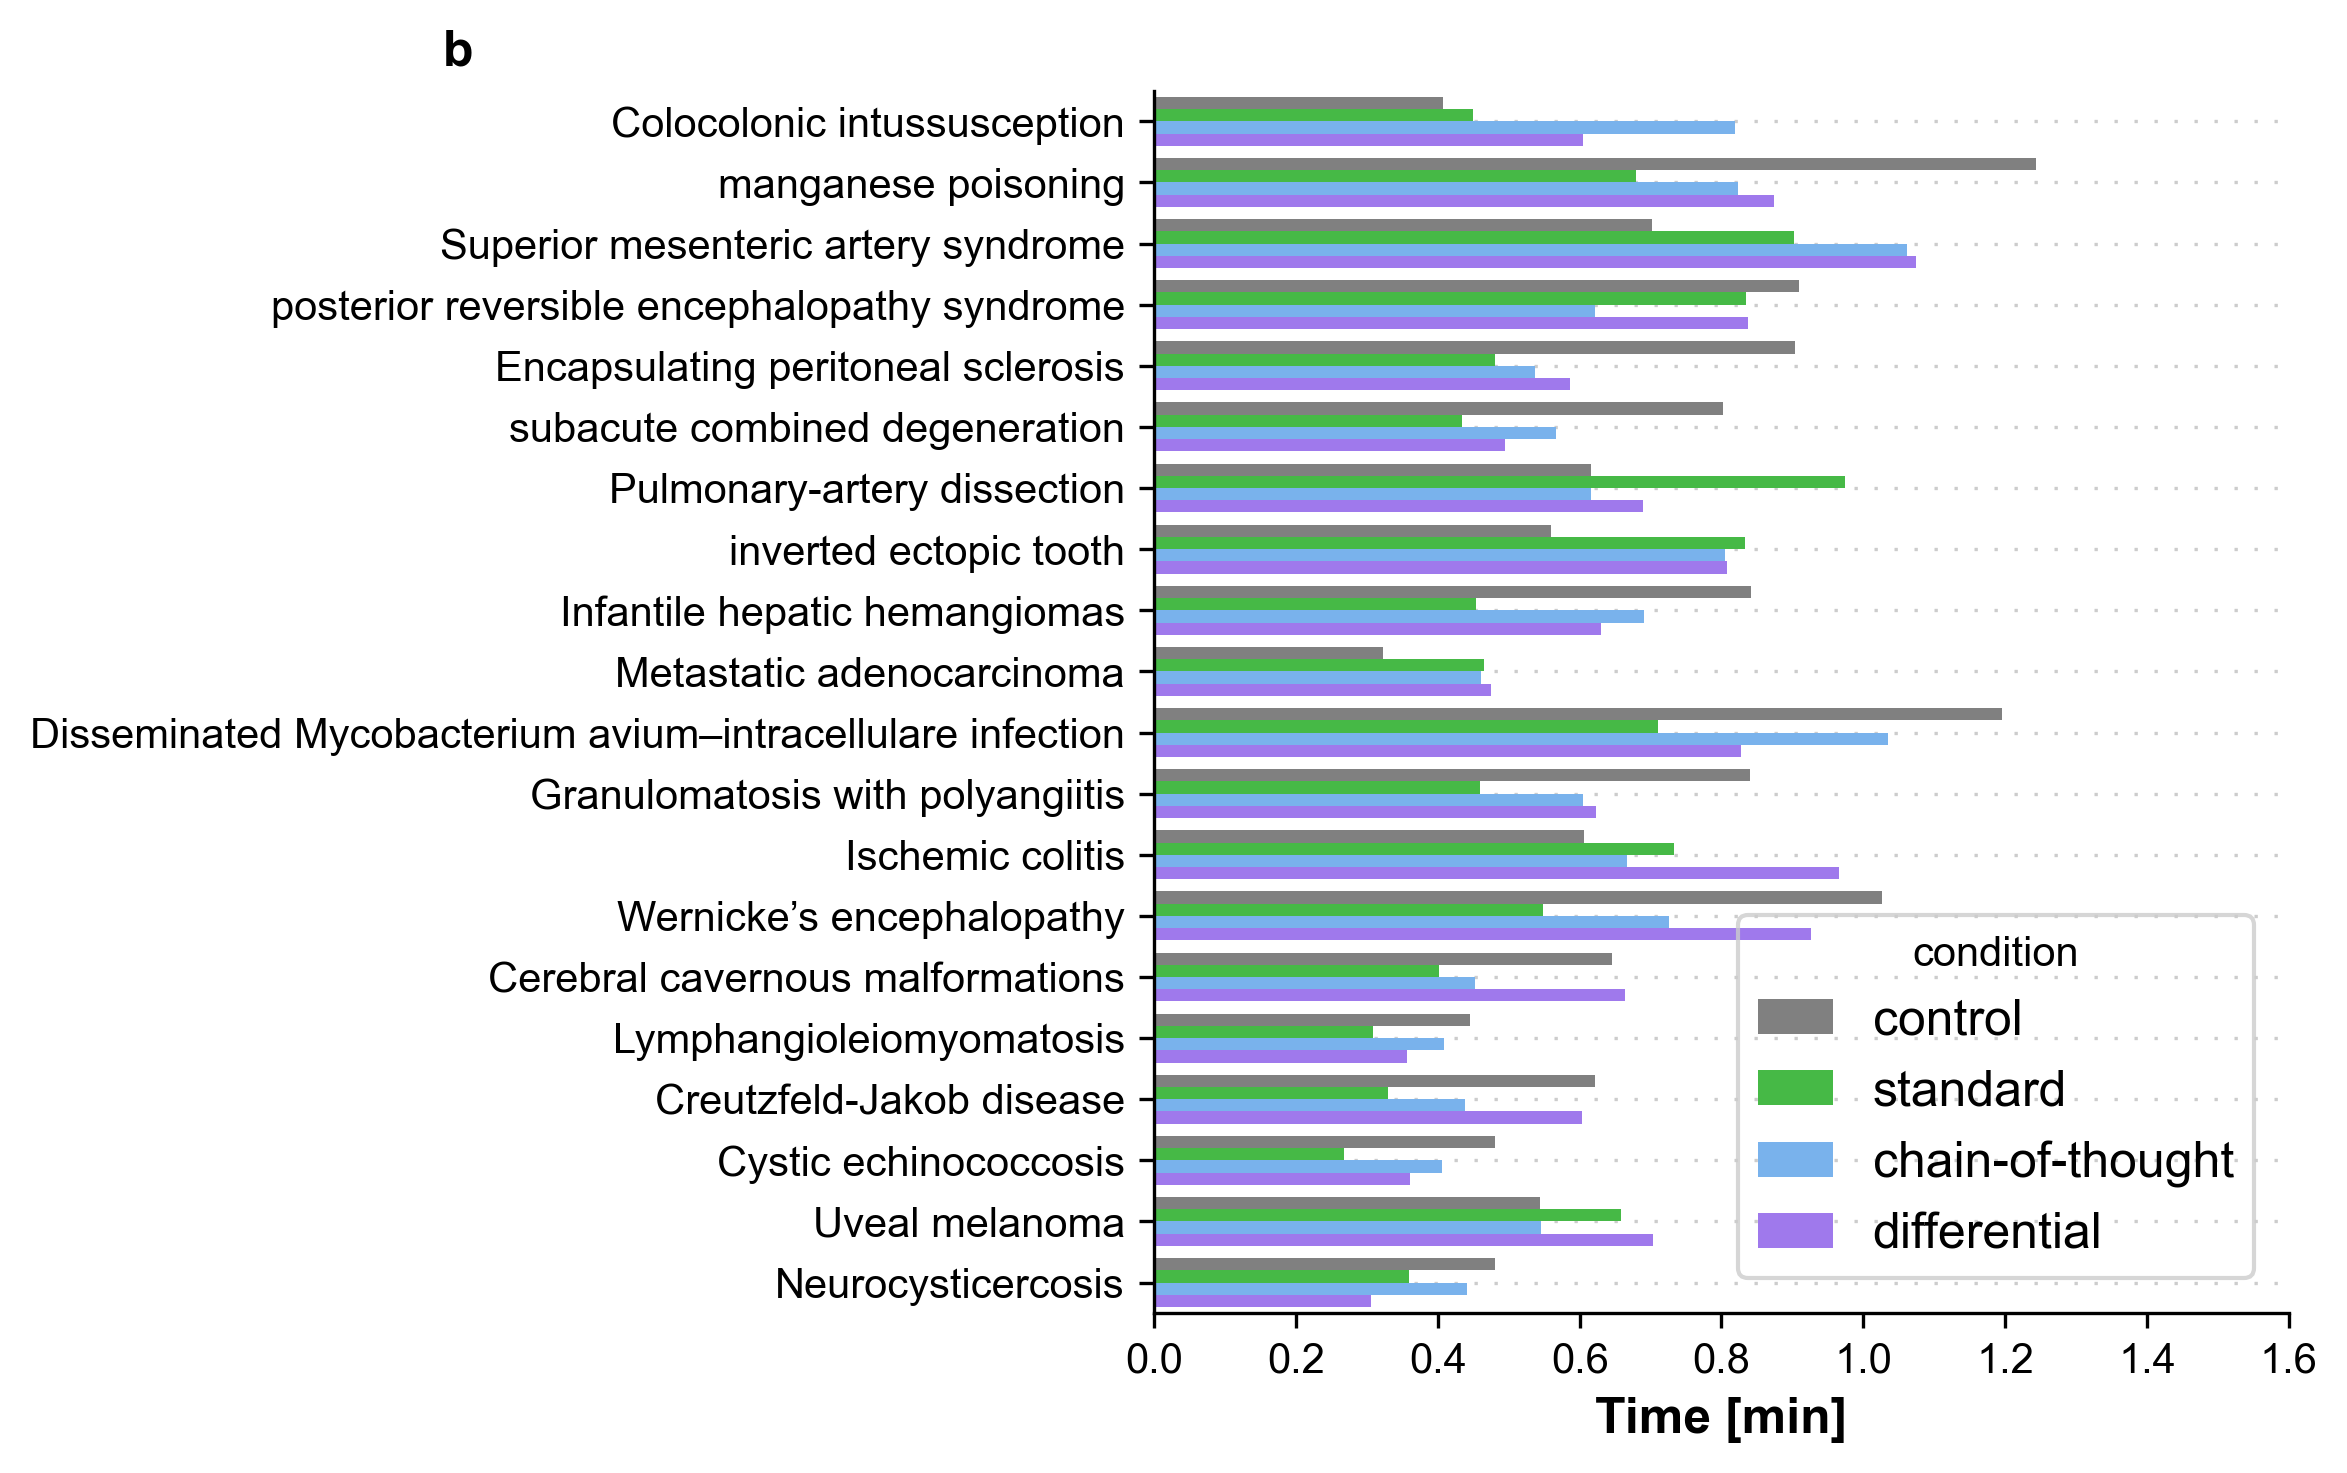

In [84]:
# control = df.query('condition == "control"')['time-per-case'].dropna().to_list()
# standard = df.query('condition == "standard"')['time-per-case'].dropna().to_list()
# cot = df.query('condition == "chain-of-thought"')['time-per-case'].dropna().to_list()
# dd = df.query('condition == "differential"')['time-per-case'].dropna().to_list()

# p_values = {
#     ('control', 'standard'): one_sided_ttest(control, standard),
#     ('control', 'differential'): one_sided_ttest(control, dd),
#     ('control', 'chain-of-thought'): one_sided_ttest(control, cot),
#     ('standard', 'chain-of-thought'): one_sided_ttest(standard, cot),
#     ('differential', 'chain-of-thought'): one_sided_ttest(dd, cot),
# }

# select data and create plot
fig, ax = plt.subplots(1,1, figsize=(8,5))
# box = sns.boxplot(data=df, y='question', x='time-per-case', width=.2, showfliers=False, ax=ax, whis=0)
# vio = sns.violinplot(data=df, y='question', x='time-per-case',alpha=0.5, ax=ax, inner=None, cut=0)
# for violin in vio.collections: violin.set_alpha(0.5) 
# gpt_performance_df = pd.DataFrame(list(gpt_performance.items()), columns=['condition', 'accuracy'])

sns.barplot(data=df, y='question', x='time-per-case', hue='condition',estimator=np.median,ax=ax,errorbar=None)

# sns.pointplot(data=gpt_performance_df, x='condition', y='accuracy', markers='o', join=False, ax=ax, hue='condition', hue_order=order, order=order,)
# annotate_tests(p_values=p_values,order=order,ymax=max(df['total-time']))
format_labs(ylab='',xlab='Time [min]',ylim=None,perc=None)
ax.set_xlim(0,2)
sns.move_legend(ax,loc='lower right')

# Change the x-axis tick labels by mapping the GROUND_TRUTHS dict to it
ax.set_yticklabels([GROUND_TRUTHS.get(tick.get_text(), tick.get_text()) for tick in ax.get_yticklabels()])
ax.grid(visible=True,which='major',axis='y')
plt.text(-0.6, 1.05, 'b', transform=ax.transAxes, fontsize=12, fontweight='bold', va='top', ha='right')
# ax.set_yscale('log')
# # Show and save plot
# plt.legend(handles=[
    # plt.Line2D([0], [0], marker='o', color='gray', markerfacecolor='none', label='Mean LLM performance', markersize=7, markeredgewidth=2, linestyle='None'), 
    # plt.Line2D([0], [0], marker='D', color='gray', markerfacecolor='none', label='Mean completion time', markersize=5, markeredgewidth=2, linestyle='None')
    #], loc='lower left', title_fontsize=8, prop={'size': 8});
plt.tight_layout()
# # save_plot(f'performance_partial_as_{map_partical_to}')
try:
    ax.get_figure().savefig(f'../Results/Plots/time-per-case.pdf')
except FileNotFoundError:
    warnings.warn('Create "../Results/Plots folder" to save figure files')


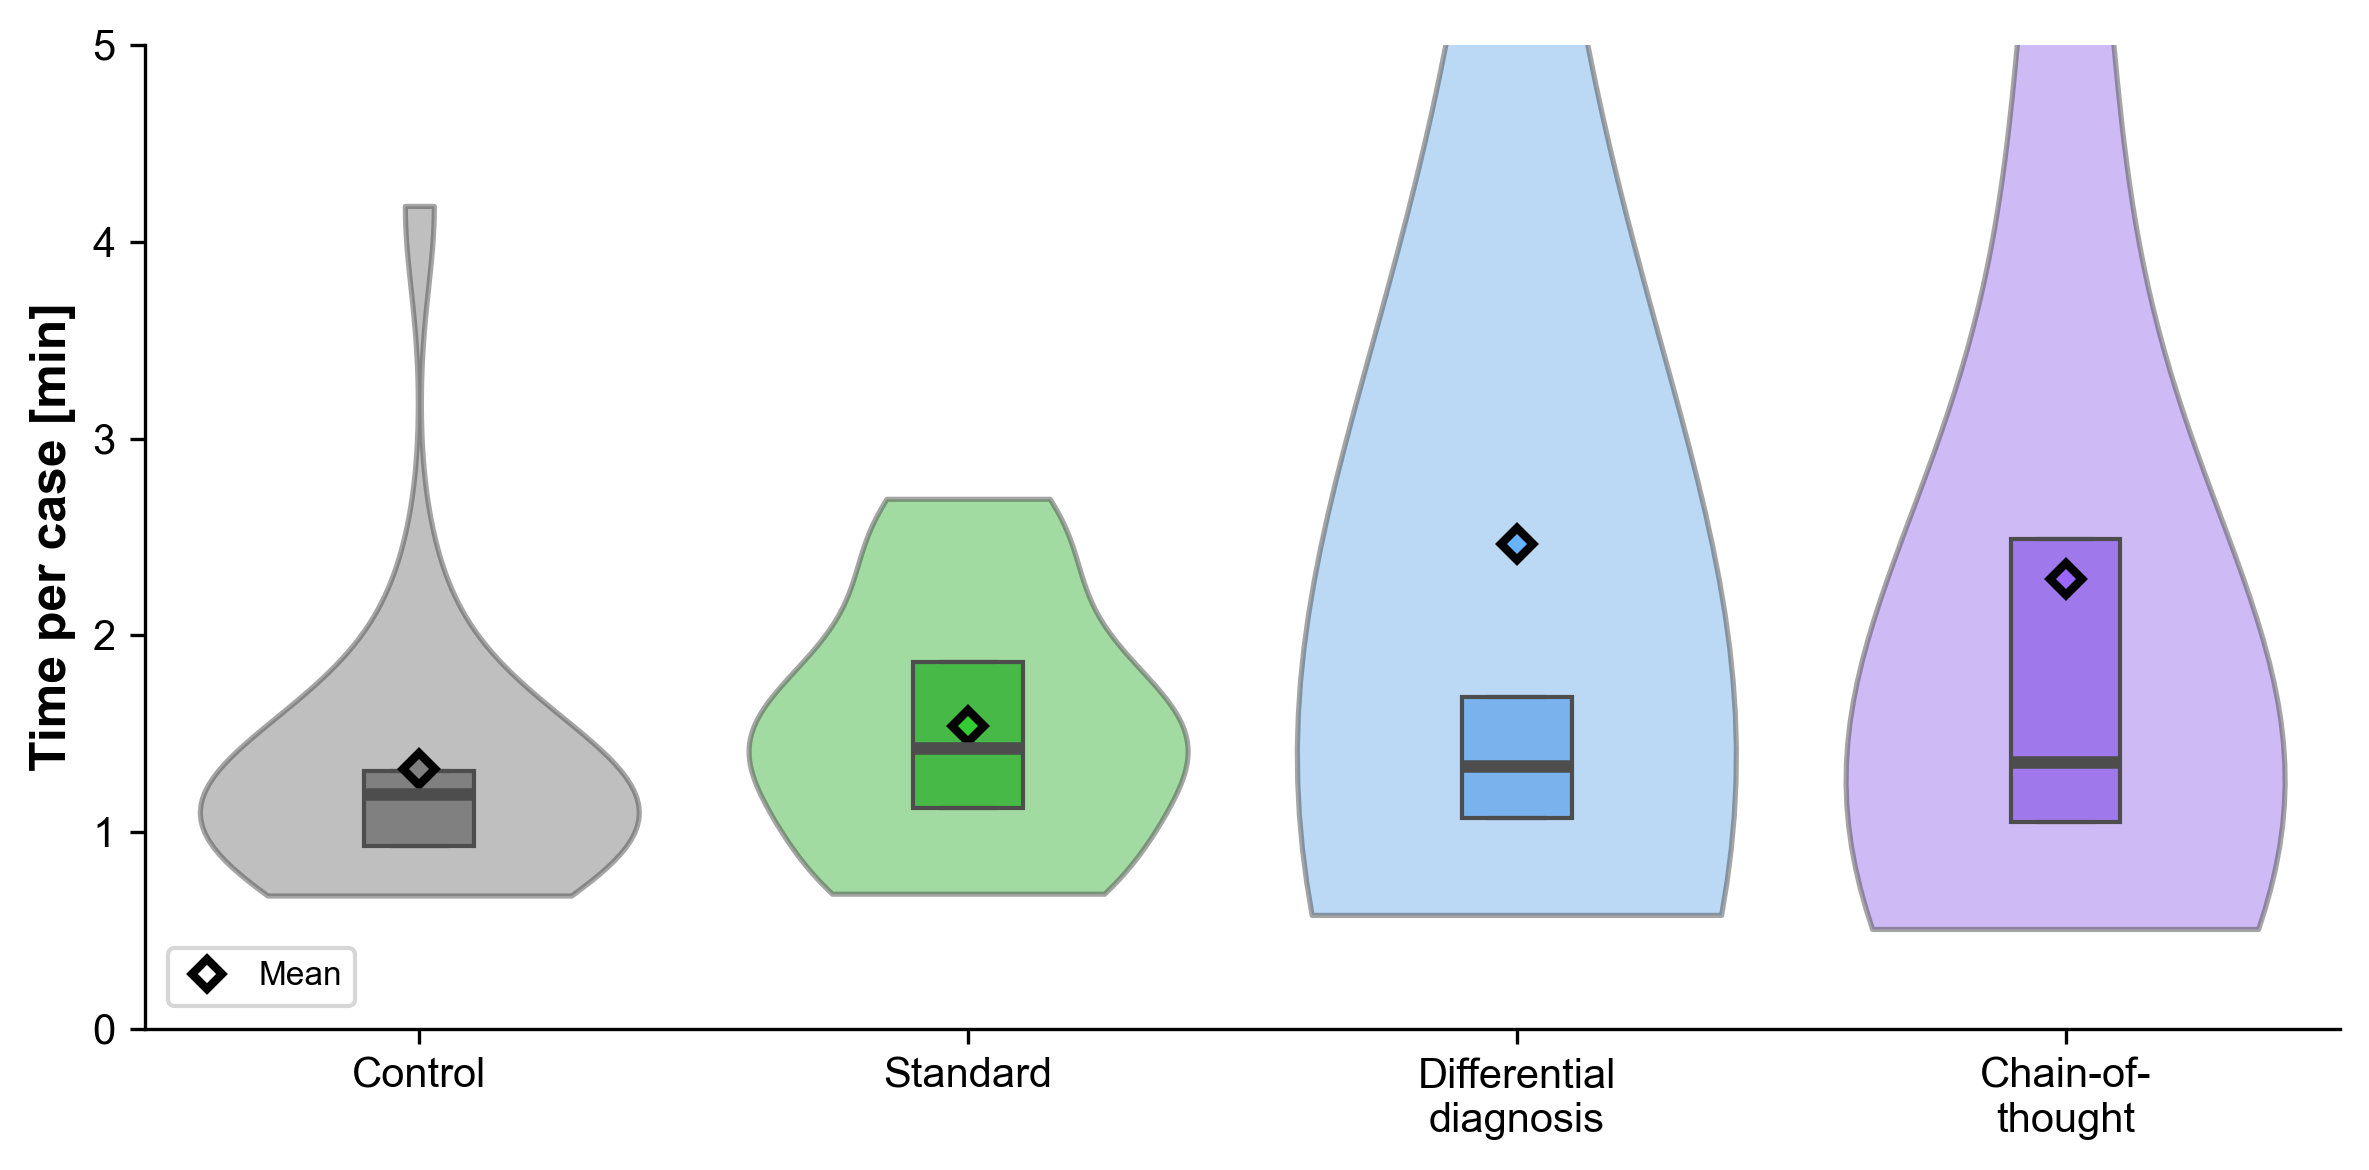

In [85]:
# select data and create plot
fig, ax = plt.subplots(1,1,)
df_plot = df.groupby(['question','condition']).agg({'time-per-case':'mean'}).reset_index()
box = sns.boxplot(data=df_plot, x='condition', y='time-per-case', order=order, hue='condition', hue_order=order,
                  width=.2, showfliers=False, ax=ax, whis=0, medianprops={'linewidth': 3})

vio = sns.violinplot(data=df_plot, x='condition', y='time-per-case',alpha=0.5, 
                     hue='condition', hue_order=order, order=order, ax=ax, inner=None, cut=0)
for violin in vio.collections: violin.set_alpha(0.5) 

sns.pointplot(data=df_plot, x='condition', y='time-per-case', estimator=np.mean,markers='D',scale=1,ax=ax, linestyles='',hue='condition',order=order,hue_order=order,errorbar=None)

format_labs(xlab='',ylab='Time per case [min]',ylim=(0,5),perc=None)

plt.legend(handles=[
    plt.Line2D([0], [0], marker='D', color='gray', markerfacecolor='none', label='Mean', markersize=5, markeredgewidth=2, linestyle='None')
    ], loc='lower left', title_fontsize=8, prop={'size': 8})

plt.tight_layout()
# plt.text(-0.05, 1.15, 'b', transform=ax.transAxes, fontsize=12, fontweight='bold', va='top', ha='right')
plt.tight_layout()

try:
    ax.get_figure().savefig(f'../Results/Plots/time-per-case.pdf')
except FileNotFoundError:
    warnings.warn('Create "../Results/Plots folder" to save figure files')

In [86]:
df_plot.condition.value_counts()

condition
chain-of-thought    20
control             20
differential        20
standard            20
Name: count, dtype: int64

In [87]:
df_stats = df_plot.copy()
df_stats['time-per-case'] = df_stats['time-per-case'] * 60
df_stats.groupby('condition')['time-per-case'].describe()

count        mean         std        min        25%  \
condition                                                               
chain-of-thought   20.0  137.194178  148.685841  30.301435  63.196424   
control            20.0   79.368740   45.441419  40.650417  55.715542   
differential       20.0  147.701225  222.545922  34.587433  64.173392   
standard           20.0   92.485448   38.044602  41.203542  67.457844   

                        50%         75%          max  
condition                                             
chain-of-thought  81.447935  149.331913   655.293478  
control           71.660375   78.545219   250.929917  
differential      80.047783  101.187650  1043.900133  
standard          85.522333  111.965948   161.625625

In [88]:
df_reg_time = df_plot.copy()

In [89]:
# fig, ax = plt.subplots(1,1, figsize=(8,5))
# # sns.histplot(data=df.groupby('question')[['time-per-case']].mean(), x='time-per-case',ax=ax,bins=10)

# box = sns.boxplot(data=df, y='time-per-case', x='condition',width=.2, showfliers=False, ax=ax, whis=0, medianprops={'linewidth': 3},)
# vio = sns.violinplot(data=df, y='time-per-case', x='condition', alpha=0.5, ax=ax, inner=None, cut=0,)
    
# for violin in vio.collections: violin.set_alpha(0.5)
# # sns.pointplot(data=gpt_performance_df, x='condition', y='accuracy', markers='o', join=False, ax=ax, hue='condition', hue_order=order, order=order,)
# # annotate_tests(p_values=p_values,order=order,ymax=max(df['total-time']))
# format_labs(ylab='',xlab='Time per patient case [min]',ylim=None,perc=None)
# # ax.set_ylim(0,10)
# # sns.move_legend(ax,loc='lower right')

# # Change the x-axis tick labels by mapping the GROUND_TRUTHS dict to it
# # ax.set_yticklabels([GROUND_TRUTHS.get(tick.get_text(), tick.get_text()) for tick in ax.get_yticklabels()])
# # ax.grid(visible=True,which='major',axis='y')
# plt.text(-0.05, 1.05, 'b', transform=ax.transAxes, fontsize=12, fontweight='bold', va='top', ha='right')
# # ax.set_yscale('log')
# # # Show and save plot
# # plt.legend(handles=[
#     # plt.Line2D([0], [0], marker='o', color='gray', markerfacecolor='none', label='Mean LLM performance', markersize=7, markeredgewidth=2, linestyle='None'), 
#     # plt.Line2D([0], [0], marker='D', color='gray', markerfacecolor='none', label='Mean completion time', markersize=5, markeredgewidth=2, linestyle='None')
#     #], loc='lower left', title_fontsize=8, prop={'size': 8});
# plt.tight_layout()
# # # save_plot(f'performance_partial_as_{map_partical_to}')
# ax.get_figure().savefig(f'../Results/Plots/time-per-case.pdf')

# Regression for pure LLM performances

In [90]:
# np.mean(llm_performance_standard+[1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1]+llm_performance_chain_of_thought)

In [91]:
# Define the lists
llm_performance_standard = [1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1]
# llm_performance_differential_diagnosis = [1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1] # top-1
llm_performance_differential_diagnosis = [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1] # top-5
llm_performance_chain_of_thought = [1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1]

# Create a dataframe
data = {
    'performance': llm_performance_standard + llm_performance_differential_diagnosis + llm_performance_chain_of_thought,
    'condition': ['standard'] * len(llm_performance_standard) + 
                 ['differential_diagnosis'] * len(llm_performance_differential_diagnosis) + 
                 ['chain_of_thought'] * len(llm_performance_chain_of_thought),
    'task_number': list(range(1, len(llm_performance_standard) + 1)) * 3
}


df_performance = pd.DataFrame(data)
df_performance['condition'] = pd.Categorical(df_performance['condition'], categories=['chain_of_thought', 'standard', 'differential_diagnosis'])

X = pd.get_dummies(df_performance[['condition']], drop_first=True)
X = sm.add_constant(X).astype(float)
y = df_performance['performance'].astype(float)
logit_model = sm.Logit(y, X)
model = logit_model.fit()

odds_ratios = np.exp(model.params)
print("Odds Ratios:\n", odds_ratios)
print(model.summary())
save_tex(fn='LLM performance comparison',model=model,
         caption=r'\textbf{Logistic regression on diagnostic accuracy of the LLM by conditions.} The standard group has a negative but non-significant effect (coeff = -0.288, \(95\%\) CI = \([-1.779, 1.204]\), \(P = 0.705\)). The differential diagnosis group has no effect (coeff = 0.000, (95%) CI = ([-1.549, 1.549]), (P = 1.000)). The odds ratios computed based on the coefficients are 0.750 for the standard condition and 1.000 for the differential diagnosis condition. The chain of thought condition is used as the reference category.',)

Optimization terminated successfully.
         Current function value: 0.521047
         Iterations 5
Odds Ratios:
 const                               4.00
condition_standard                  0.75
condition_differential_diagnosis    1.00
dtype: float64
                           Logit Regression Results                           
Dep. Variable:            performance   No. Observations:                   60
Model:                          Logit   Df Residuals:                       57
Method:                           MLE   Df Model:                            2
Date:                Mon, 10 Mar 2025   Pseudo R-squ.:                0.003080
Time:                        08:34:09   Log-Likelihood:                -31.263
converged:                       True   LL-Null:                       -31.359
Covariance Type:            nonrobust   LLR p-value:                    0.9079
                                       coef    std err          z      P>|z|      [0.025      0.975]
-------------

# Regressions on performance

## Conditions only

In [92]:
df_reg['condition'] = pd.Categorical(df_reg['condition'], categories=['control', 'standard', 'differential','chain-of-thought'])
model = fit(df_reg,'correctness','condition')
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:            correctness   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                     4.650
Date:                Mon, 10 Mar 2025   Prob (F-statistic):            0.00443
Time:                        08:34:09   Log-Likelihood:                 73.417
No. Observations:                 101   AIC:                            -138.8
Df Residuals:                      97   BIC:                            -128.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [93]:
save_tex(fn='OLS regression of diagnostic accuracy on conditions', 
         caption=r'\textbf{OLS regression of diagnostic accuracy on conditions.} The intercept is estimated at 0.617 with a significant P-value (P < 0.001). The standard group is similar to the control group (difference = 5.0 percentage points, \(95\%\) CI = \([-1.8, 11.8]\), P = 0.150). The differential diagnosis group is also similar to the control group (difference = 2.5 percentage points, \(95\%\) CI = \([-4.0, 9.0]\), P = 0.446). In contrast, the chain-of-thought intervention group outperformed the control group (difference = 12.2 percentage points, \(95\%\) CI = \([5.3, 19.2.8]\), P = 0.001).', 
         model=model,)


## CoT as baseline

In [94]:
df_reg['condition'] = pd.Categorical(df_reg['condition'], categories=['chain-of-thought', 'control', 'standard', 'differential'])
model = fit(df_reg,'correctness','condition')
print(model.summary())

save_tex('OLS regression of diagnostic accuracy on conditions with CoT as baseline',model, 
         caption=r'\textbf{OLS regression of diagnostic accuracy on conditions with chain-of-thought as baseline.} The intercept is estimated at 0.739 with a highly significant P-value (P < 0.001). The control condition shows a negative effect (difference = -12.2 percentage points, (95\%) CI = ([-19.2; -5.3]), (P = 0.001)). The standard condition also has a negative effect (difference = -7.2 percentage points, (95\%) CI = ([-14.2; -0.3]), (P = 0.040)). Similarly, the differential condition shows a negative effect (difference = -9.7 percentage points, (95\%) CI = ([-16.3; -3.2]), (P = 0.004)). These results suggest that all three conditions perform worse than chain-of-thought group, with significant differences.')

# reverse baseline for following regressions
df_reg['condition'] = pd.Categorical(df_reg['condition'], categories=['control', 'standard', 'differential','chain-of-thought'])

                            OLS Regression Results                            
Dep. Variable:            correctness   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                     4.650
Date:                Mon, 10 Mar 2025   Prob (F-statistic):            0.00443
Time:                        08:34:09   Log-Likelihood:                 73.417
No. Observations:                 101   AIC:                            -138.8
Df Residuals:                      97   BIC:                            -128.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0

## Controlling for personal factors

In [95]:
df_reg['IT-skills'].unique()

['Good', 'Very Good', 'Advanced', 'Basic', NaN, 'Expert']
Categories (5, object): ['Basic', 'Good', 'Very Good', 'Advanced', 'Expert']

In [96]:
treatment = ['condition']

controls = [
    'medical-experience',
    'radiology-experience', 
    'weekly-inspection-time',
    'IT-skills',
    'medical-AI-experience',
    ]
    
target = ['correctness']

df_reg['condition'] = pd.Categorical(df_reg['condition'], categories=['control', 'standard', 'differential','chain-of-thought'])

df_encoded = pd.get_dummies(
    df_reg[target + treatment + controls].dropna(axis=0), 
    drop_first=True,)

# change order of columns 
first_cols = df_encoded[['condition_standard','condition_differential','condition_chain-of-thought']]
df_encoded.drop(['condition_standard','condition_differential','condition_chain-of-thought'], axis=1,inplace=True)
df_encoded = pd.concat([first_cols,df_encoded],axis=1)

X = df_encoded.drop(target, axis=1)
Y = df_encoded[target]
X = sm.add_constant(X)

model = sm.OLS(Y, X.astype(float)).fit()
print(model.summary())
save_tex('Regression on participant level of diagnostic acucracy on conditions with control for personal factors', model,
    caption=r'\textbf{Extended OLS regression of diagnostic accuracy on conditions, medical experience, radiology experience, weekly inspection time of radiology images, IT skills, and medical-AI experience.} The intercept is estimated at 0.527 with a highly significant P-value (P < 0.001). The standard condition has a positive effect (difference = 7.0 percentage points, (95\%) CI = ([-0.9, 14.9]), (P = 0.081)) but does not reach significance. The differential condition has a small positive effect (difference = 3.9 percentage points, (95\%) CI = ([-3.9, 11.7]), (P = 0.325)) and is not significant. In contrast, the chain-of-thought condition has a positive and significant effect (difference = 15.1, (95\%) CI = ([7.0, 23.2]), (P < 0.001)), suggesting an improvement in performance.')

                            OLS Regression Results                            
Dep. Variable:            correctness   R-squared:                       0.195
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     1.241
Date:                Mon, 10 Mar 2025   Prob (F-statistic):              0.256
Time:                        08:34:09   Log-Likelihood:                 75.104
No. Observations:                  99   AIC:                            -116.2
Df Residuals:                      82   BIC:                            -72.09
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

## Controlling for study factors

In [97]:
treatment = ['condition']

controls = ['total-time',
            'advice-length', 
            'answer-length',
            ]

target = ['correctness']

df_reg['condition'] = pd.Categorical(df_reg['condition'], categories=['control', 'standard', 'differential','chain-of-thought'])

df_encoded = pd.get_dummies(
    df_reg[target + treatment + controls].dropna(axis=0), 
    drop_first=True,)

# change order of columns 
first_cols = df_encoded[['condition_standard','condition_differential','condition_chain-of-thought']]
df_encoded.drop(['condition_standard','condition_differential','condition_chain-of-thought'], axis=1,inplace=True)
df_encoded = pd.concat([first_cols,df_encoded],axis=1)

target = 'correctness'
X = df_encoded.drop(target, axis=1)
Y = df_encoded[target]
X = sm.add_constant(X)

model = sm.OLS(Y, X.astype(float)).fit()
print(model.summary())
save_tex('Regression on participant level of diagnostic acucracy on conditions with control for study factors', model,
    caption=r'\textbf{Extended OLS regression of diagnostic accuracy on conditions, total time, advice length, and answer length.} The intercept coefficient is 0.544 with a P-value of \(<0.001\). The standard group has an effect (difference = 2.1 percentage points, \(95\%\) CI = \([-3.5, 7.6]\), \(P = 0.467\)) but is not significant. The differential diagnosis group shows a negative effect (difference = -4.8 percentage points, \(95\%\) CI = \([8.1, 1.5]\), \(P = 0.005\)). The chain-of-thought group has a positive and significant effect (difference = 4.6 percentage points, \(95\%\) CI = \([1.0, 8.1]\), \(P = 0.012\)).')

                            OLS Regression Results                            
Dep. Variable:            correctness   R-squared:                       0.179
Model:                            OLS   Adj. R-squared:                  0.136
Method:                 Least Squares   F-statistic:                     4.145
Date:                Mon, 10 Mar 2025   Prob (F-statistic):            0.00189
Time:                        08:34:09   Log-Likelihood:                 76.598
No. Observations:                 101   AIC:                            -141.2
Df Residuals:                      95   BIC:                            -125.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

## Groupped by IT skills

In [98]:
def tests(df):
    control_performance = df.query('condition == "control"')['correctness'].to_list()
    standard_performance = df.query('condition == "standard"')['correctness'].to_list()
    cot_performance = df.query('condition == "chain-of-thought"')['correctness'].to_list()
    dd_performance = df.query('condition == "differential"')['correctness'].to_list()

    # Perform ANOVA
    fvalue, pvalue = stats.f_oneway(control_performance, standard_performance, cot_performance, dd_performance)
    print(f"ANOVA results: F-value = {fvalue:.3f}, p-value = {pvalue:.3f}")

    # Control vs. Standard
    t_statistic, p_value = one_sided_ttest(control_performance, standard_performance)
    print(f"Control vs. Standard: t-statistic = {t_statistic:.3f}, p-value = {p_value:.3f}")

    # Control vs. DD
    t_statistic, p_value = one_sided_ttest(control_performance, dd_performance)
    print(f"Control vs. DD: t-statistic = {t_statistic:.3f}, p-value = {p_value:.3f}")

    # Control vs. CoT
    t_statistic, p_value = one_sided_ttest(control_performance, cot_performance)
    print(f"Control vs. CoT: t-statistic = {t_statistic:.3f}, p-value = {p_value:.3f}")

    # Standard vs. CoT
    t_statistic, p_value = one_sided_ttest(standard_performance, cot_performance)
    print(f"Standard vs. CoT: t-statistic = {t_statistic:.3f}, p-value = {p_value:.3f}")

    # DD vs. CoT
    t_statistic, p_value = one_sided_ttest(dd_performance, cot_performance)
    print(f"DD vs. CoT: t-statistic = {t_statistic:.3f}, p-value = {p_value:.3f}")

    # Standard vs. DD
    t_statistic, p_value = one_sided_ttest(standard_performance, dd_performance)
    print(f"Standard vs. DD: t-statistic = {t_statistic:.3f}, p-value = {p_value:.3f}")
    
    return {
        ('control', 'standard'): one_sided_ttest(control_performance, standard_performance),
        ('control', 'differential'): one_sided_ttest(control_performance, dd_performance),
        ('control', 'chain-of-thought'): one_sided_ttest(control_performance, cot_performance),
        ('standard', 'chain-of-thought'): one_sided_ttest(standard_performance, cot_performance),
        ('differential', 'chain-of-thought'): one_sided_ttest(dd_performance, cot_performance),
    }

In [99]:
df_subgroup_left = df_reg[df_reg['IT-skills'].isin(['Beginner', 'Novice', 'Basic', 'Good'])]
df_subgroup_right = df_reg[df_reg['IT-skills'].isin(['Very Good','Advanced','Expert'])]

In [100]:
df_subgroup_left.shape, df_subgroup_right.shape

((43, 607), (56, 607))

In [101]:
_ = tests(df_subgroup_left)

ANOVA results: F-value = 4.533, p-value = 0.008
Control vs. Standard: t-statistic = -0.374, p-value = 0.356
Control vs. DD: t-statistic = -1.814, p-value = 0.047
Control vs. CoT: t-statistic = -3.439, p-value = 0.002
Standard vs. CoT: t-statistic = -2.682, p-value = 0.010
DD vs. CoT: t-statistic = -2.742, p-value = 0.007
Standard vs. DD: t-statistic = -1.207, p-value = 0.124


In [102]:
_ = tests(df_subgroup_right)

ANOVA results: F-value = 2.991, p-value = 0.039
Control vs. Standard: t-statistic = -1.518, p-value = 0.075
Control vs. DD: t-statistic = 0.295, p-value = 0.614
Control vs. CoT: t-statistic = -1.780, p-value = 0.047
Standard vs. CoT: t-statistic = -0.612, p-value = 0.274
DD vs. CoT: t-statistic = -3.169, p-value = 0.002
Standard vs. DD: t-statistic = 2.955, p-value = 0.997


ANOVA results: F-value = 4.533, p-value = 0.008
Control vs. Standard: t-statistic = -0.374, p-value = 0.356
Control vs. DD: t-statistic = -1.814, p-value = 0.047
Control vs. CoT: t-statistic = -3.439, p-value = 0.002
Standard vs. CoT: t-statistic = -2.682, p-value = 0.010
DD vs. CoT: t-statistic = -2.742, p-value = 0.007
Standard vs. DD: t-statistic = -1.207, p-value = 0.124
ANOVA results: F-value = 2.991, p-value = 0.039
Control vs. Standard: t-statistic = -1.518, p-value = 0.075
Control vs. DD: t-statistic = 0.295, p-value = 0.614
Control vs. CoT: t-statistic = -1.780, p-value = 0.047
Standard vs. CoT: t-statistic = -0.612, p-value = 0.274
DD vs. CoT: t-statistic = -3.169, p-value = 0.002
Standard vs. DD: t-statistic = 2.955, p-value = 0.997


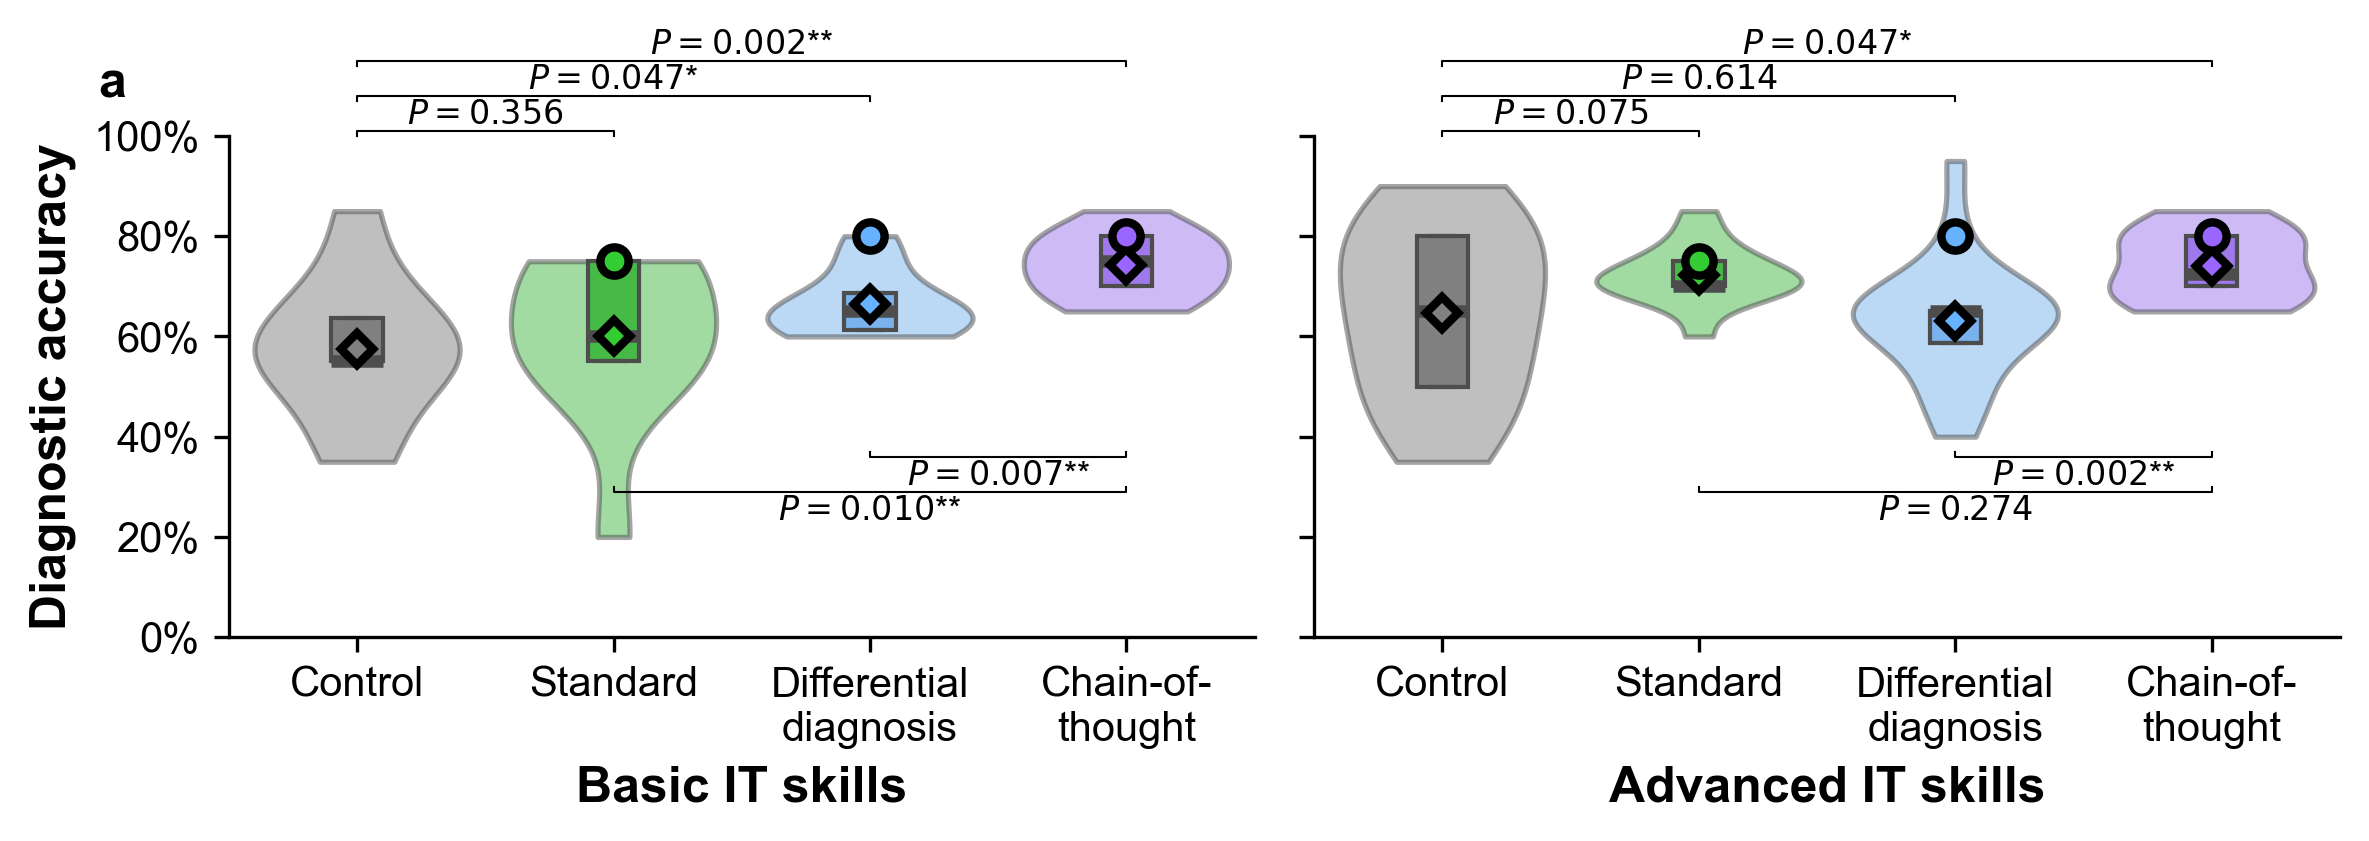

In [103]:
# select data and create plot
fig, axs = plt.subplots(1,2, figsize=(8,3),sharey=True)
# order = ['control', 'standard', 'differential', 'chain-of-thought',]
kwargs_plot = dict(x='condition', y='correctness', order=order, hue='condition', hue_order=order)

for count,(ax,d,title) in enumerate(zip(axs,[df_subgroup_left,df_subgroup_right],['Basic IT skills','Advanced IT skills'])):
    box = sns.boxplot(data=d,width=.2, showfliers=False, ax=ax, whis=0, medianprops={'linewidth': 3}, **kwargs_plot)
    vio = sns.violinplot(data=d, alpha=0.5, ax=ax, inner=None, cut=0, **kwargs_plot)
    for violin in vio.collections: violin.set_alpha(0.5) 

    # Some adjustments
    ax.set_xlabel(title); ax.set_ylabel('Diagnostic accuracy')
    from textwrap import fill
    ax.set_xticklabels([fill(_.get_text().capitalize(),width=12) for _ in ax.get_xticklabels()],)
    ax.set_ylim(0,1)
    ax.grid(visible=False)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
    labels = [textwrap.fill(map_condition_label(tick.get_text()), width=12) for tick in ax.get_xticklabels()]
    ax.set_xticklabels(labels, rotation=0)
    
    # Annotate sample sizes
    # n = len(d)
    # ax.text(0.95, 0.95, f'$n={n}$', ha='right', va='top', transform=ax.transAxes, fontsize=8, fontdict={'color': 'black'})
    annotate_tests(p_values=tests(d),order=order,ymax=1,ax=ax,low_test_margin=0.07,high_test_margin=0.01,low_offset=-0.1)
    if count == 0: ax.text(-0.1, 1.15, 'a', transform=ax.transAxes, fontsize=12, fontweight='bold', va='top', ha='right')
    
    gpt_performance_df = pd.DataFrame(list(gpt_performance.items()), columns=['condition', 'accuracy'])
    
    sns.pointplot(data=d, x='condition', y='correctness', estimator=np.mean,markers='D',scale=1,ax=ax, linestyles='',
                  hue='condition',errorbar=None,order=order,hue_order=order, zorder=10)
    
    sns.pointplot(data=gpt_performance_df, x='condition', y='accuracy', markers='o', join=False, ax=ax, hue='condition', hue_order=order, order=order, zorder=10)

# plt.legend(handles=[
#     plt.Line2D([0], [0], marker='o', color='gray', markerfacecolor='none', label='LLM-only', markersize=5, markeredgewidth=2, linestyle='None'), 
#     plt.Line2D([0], [0], marker='D', color='gray', markerfacecolor='none', label='Physicians with LLM support', markersize=3, markeredgewidth=2, linestyle='None')
#     ], loc='lower left', title_fontsize=6, prop={'size': 6}, title='Diagnostic accuracy (mean)');
    
# Show and save plot
plt.tight_layout()

try:
    ax.get_figure().savefig(f'../Results/Plots/performance_subgroup_IT_skills.pdf')
except FileNotFoundError:
    warnings.warn('Create "../Results/Plots folder" to save figure files')

In [104]:
df_subgroup_left.condition.value_counts()

condition
chain-of-thought    12
standard            11
control             10
differential        10
Name: count, dtype: int64

In [105]:
model_left = fit(df_subgroup_left,'correctness','condition')
print(model_left.summary())

save_tex('OLS regression for subgroup with low IT skills',model_left,
         caption=r'\textbf{OLS regression of diagnostic accuracy on conditions with a subgroup of participants that have poor IT skills (lower or equal to "Good").} The intercept coefficient is 0.575 with a P-value of \(< 0.001\) and a \(95\%\) confidence interval of \([0.500, 0.650]\). The standard group has an effect (difference = 2.5 percentage points, \(95\%\) CI = \([-7.9, 12.9]\), \(P = 0.628\)) but is not statistically significant. The differential diagnosis group shows an effect (difference = 9.0 percentage points, \(95\%\) CI = \([-1.6, 19.6]\), \(P = 0.094\)) but does not reach statistical significance. The chain-of-thought group has a positive and statistically significant effect (difference = 16.7 percentage points, \(95\%\) CI = \([6.5, 26.8]\), \(P = 0.002\)).')

                            OLS Regression Results                            
Dep. Variable:            correctness   R-squared:                       0.259
Model:                            OLS   Adj. R-squared:                  0.201
Method:                 Least Squares   F-statistic:                     4.533
Date:                Mon, 10 Mar 2025   Prob (F-statistic):            0.00806
Time:                        08:34:10   Log-Likelihood:                 33.273
No. Observations:                  43   AIC:                            -58.55
Df Residuals:                      39   BIC:                            -51.50
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [106]:
df_subgroup_right.condition.value_counts()

condition
differential        20
control             13
standard            13
chain-of-thought    10
Name: count, dtype: int64

In [107]:
model_right = fit(df_subgroup_right,'correctness','condition')
print(model_right.summary())

save_tex('OLS regression for subgroup with high IT skills',model_right,
         caption=r'\textbf{OLS regression of diagnostic accuracy on conditions with a subgroup of participants that have good IT skills (better than "Good").} The intercept coefficient is 0.646 with a P-value of \(< 0.001\). The standard group has an effect (difference = 7.7 percentage points, \(95\%\) CI = \([-1.5, 16.9]\), \(P = 0.101\)) but does not reach statistical significance. The differential diagnosis group shows a small negative effect (difference = -1.6 percentage points, \(95\%\) CI = \([-10.0, 6.8]\), \(P = 0.701\)) and is not significant. The chain-of-thought group has a positive effect (difference = 9.4 percentage points, \(95\%\) CI = \([-0.5, 19.3]\), \(P = 0.063\)) but does not reach statistical significance.')

                            OLS Regression Results                            
Dep. Variable:            correctness   R-squared:                       0.147
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     2.991
Date:                Mon, 10 Mar 2025   Prob (F-statistic):             0.0392
Time:                        08:34:10   Log-Likelihood:                 42.588
No. Observations:                  56   AIC:                            -77.18
Df Residuals:                      52   BIC:                            -69.08
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

## Groupped by experience in radiology

In [108]:
experience_cutoff = df_reg['medical-experience'].median()
print(experience_cutoff)

df_subgroup_left = df_reg[df_reg['medical-experience']< experience_cutoff]
df_subgroup_right = df_reg[df_reg['medical-experience']>= experience_cutoff]
# df_subgroup = df_reg[df_reg['IT-skills' == ]]

12.0


In [109]:
df_subgroup_left.shape, df_subgroup_right.shape

((46, 607), (53, 607))

ANOVA results: F-value = 2.697, p-value = 0.058
Control vs. Standard: t-statistic = -1.274, p-value = 0.116
Control vs. DD: t-statistic = -0.687, p-value = 0.256
Control vs. CoT: t-statistic = -1.917, p-value = 0.042
Standard vs. CoT: t-statistic = -1.111, p-value = 0.141
DD vs. CoT: t-statistic = -2.624, p-value = 0.010
Standard vs. DD: t-statistic = 1.307, p-value = 0.896
ANOVA results: F-value = 2.469, p-value = 0.073
Control vs. Standard: t-statistic = -0.511, p-value = 0.307
Control vs. DD: t-statistic = -0.120, p-value = 0.453
Control vs. CoT: t-statistic = -2.865, p-value = 0.005
Standard vs. CoT: t-statistic = -2.112, p-value = 0.026
DD vs. CoT: t-statistic = -2.754, p-value = 0.008
Standard vs. DD: t-statistic = 0.398, p-value = 0.653


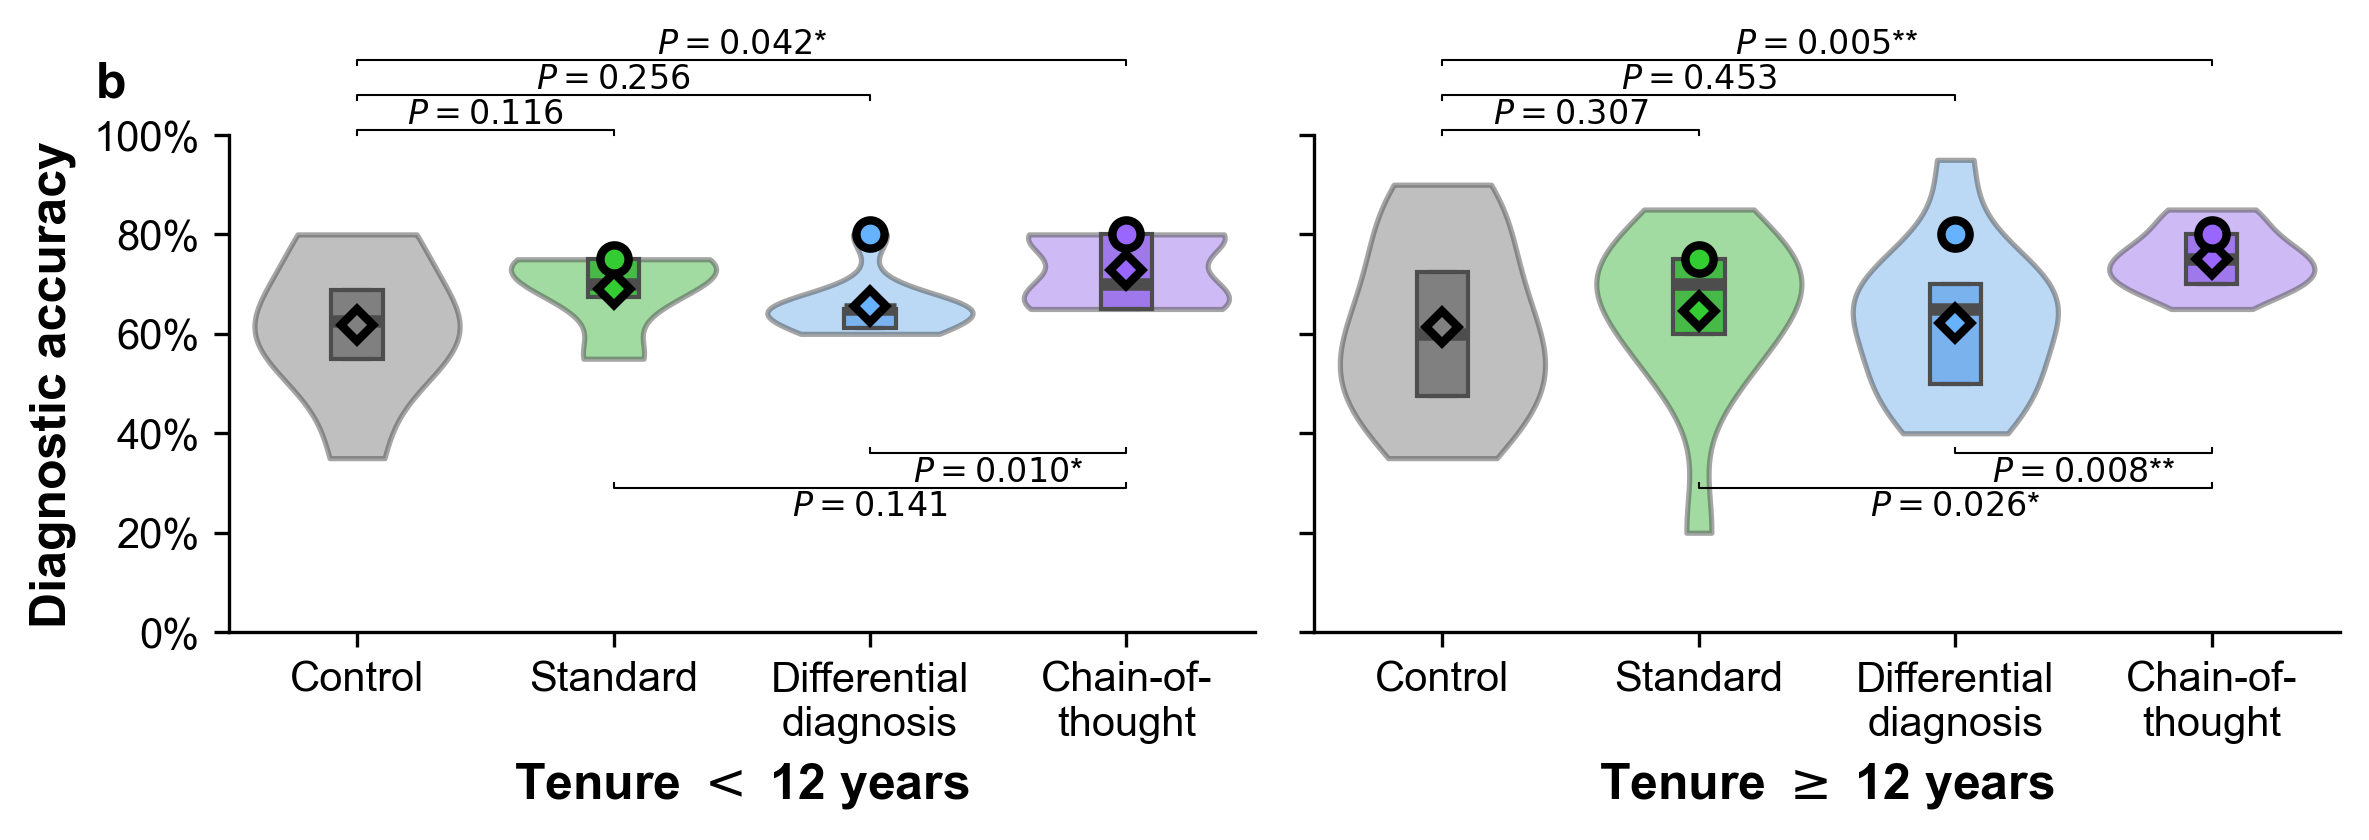

In [110]:
# select data and create plot
fig, axs = plt.subplots(1,2, figsize=(8,3),sharey=True)
# order = ['control', 'standard', 'differential', 'chain-of-thought',]
kwargs_plot = dict(x='condition', y='correctness', order=order, hue='condition', hue_order=order)

for count,(ax,d,title) in enumerate(zip(axs,[df_subgroup_left,df_subgroup_right],['Tenure $<$ 12 years','Tenure $\geq$ 12 years'])):
    box = sns.boxplot(data=d,width=.2, showfliers=False, ax=ax, whis=0,medianprops={'linewidth': 3}, **kwargs_plot)
    vio = sns.violinplot(data=d, alpha=0.5, ax=ax, inner=None, cut=0, **kwargs_plot)
    for violin in vio.collections: violin.set_alpha(0.5) 
    
    # Some adjustments
    ax.set_xlabel(title); ax.set_ylabel('Diagnostic accuracy')
    from textwrap import fill
    ax.set_xticklabels([fill(_.get_text().capitalize(),width=12) for _ in ax.get_xticklabels()],)
    ax.set_ylim(0,1)
    ax.grid(visible=False)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
    labels = [textwrap.fill(map_condition_label(tick.get_text()), width=12) for tick in ax.get_xticklabels()]
    ax.set_xticklabels(labels, rotation=0)
    annotate_tests(p_values=tests(d),order=order,ymax=1,ax=ax,low_test_margin=0.07,high_test_margin=0.01,low_offset=-0.10)
    
    if count == 0: ax.text(-0.1, 1.15, 'b', transform=ax.transAxes, fontsize=12, fontweight='bold', va='top', ha='right')
    # Annotate sample sizes
    # n = len(d)
    # ax.text(0.95, 0.95, f'$n={n}$', ha='right', va='top', transform=ax.transAxes, fontsize=8, fontdict={'color': 'black'})
    gpt_performance_df = pd.DataFrame(list(gpt_performance.items()), columns=['condition', 'accuracy'])
    
    sns.pointplot(data=d, x='condition', y='correctness', estimator=np.mean,markers='D',scale=1,ax=ax, linestyles='',
                  hue='condition',errorbar=None,order=order,hue_order=order, zorder=10)
    
    sns.pointplot(data=gpt_performance_df, x='condition', y='accuracy', markers='o', join=False, ax=ax, hue='condition', hue_order=order, order=order, zorder=10)

    # if count == 0: ax.legend(handles=[
    #     plt.Line2D([0], [0], marker='o', color='gray', markerfacecolor='none', label='LLM-only', markersize=5, markeredgewidth=2, linestyle='None'), 
    #     plt.Line2D([0], [0], marker='D', color='gray', markerfacecolor='none', label='Physicians with LLM support', markersize=3, markeredgewidth=2, linestyle='None')
    #     ], loc='lower left', title_fontsize=6, prop={'size': 6}, title='Diagnostic accuracy (mean)')

# Show and save plot
plt.tight_layout()

try:
    ax.get_figure().savefig(f'../Results/Plots/performance_subgroup_experience_radiology.pdf')
except FileNotFoundError:
    warnings.warn('Create "../Results/Plots folder" to save figure files')

In [111]:
tests(df_subgroup_left)

ANOVA results: F-value = 2.697, p-value = 0.058
Control vs. Standard: t-statistic = -1.274, p-value = 0.116
Control vs. DD: t-statistic = -0.687, p-value = 0.256
Control vs. CoT: t-statistic = -1.917, p-value = 0.042
Standard vs. CoT: t-statistic = -1.111, p-value = 0.141
DD vs. CoT: t-statistic = -2.624, p-value = 0.010
Standard vs. DD: t-statistic = 1.307, p-value = 0.896


{('control', 'standard'): (np.float64(-1.2735801535048956),
  np.float64(0.11606740844181883)),
 ('control', 'differential'): (np.float64(-0.6873537347547506),
  np.float64(0.25560200664414456)),
 ('control', 'chain-of-thought'): (np.float64(-1.9165284830366012),
  np.float64(0.04232735625355458)),
 ('standard', 'chain-of-thought'): (np.float64(-1.1113995234549683),
  np.float64(0.1406433038775337)),
 ('differential', 'chain-of-thought'): (np.float64(-2.6240351018418204),
  np.float64(0.010150057197271436))}

In [112]:
tests(df_subgroup_right)

ANOVA results: F-value = 2.469, p-value = 0.073
Control vs. Standard: t-statistic = -0.511, p-value = 0.307
Control vs. DD: t-statistic = -0.120, p-value = 0.453
Control vs. CoT: t-statistic = -2.865, p-value = 0.005
Standard vs. CoT: t-statistic = -2.112, p-value = 0.026
DD vs. CoT: t-statistic = -2.754, p-value = 0.008
Standard vs. DD: t-statistic = 0.398, p-value = 0.653


{('control', 'standard'): (np.float64(-0.5114811827974227),
  np.float64(0.3066923231501247)),
 ('control', 'differential'): (np.float64(-0.12011764463886945),
  np.float64(0.4526799350106787)),
 ('control', 'chain-of-thought'): (np.float64(-2.8648314379473554),
  np.float64(0.005165442058375506)),
 ('standard', 'chain-of-thought'): (np.float64(-2.111567094915594),
  np.float64(0.025844236158603734)),
 ('differential', 'chain-of-thought'): (np.float64(-2.753991528958496),
  np.float64(0.007652334467923431))}

In [113]:
df_subgroup_left.condition.value_counts()

condition
differential        18
standard            11
chain-of-thought     9
control              8
Name: count, dtype: int64

In [114]:
model_left = fit(df_subgroup_left,'correctness','condition')
print(model_left.summary())
save_tex('OLS regression for subgroup with low medical experience',model_left,
         caption=r'\textbf{OLS regression of diagnostic accuracy on conditions with a subgroup of unexperienced radiologists (less than 12.0 years).} The intercept coefficient is 0.619 with a P-value of \(<0.001\). The standard group has an effect (difference = 7.2 percentage points, \(95\%\) CI = \([-0.8, 15.3]\), \(P = 0.077\)) but does not reach statistical significance. The differential diagnosis group shows an effect (difference = 3.7 percentage points, \(95\%\) CI = \([-3.7, 11.0]\), \(P = 0.318\)) and is not significant. The chain-of-thought group has a positive and statistically significant effect (difference = 10.9 percentage points, \(95\%\) CI = \([2.5, 19.3]\), \(P = 0.012\)).')

                            OLS Regression Results                            
Dep. Variable:            correctness   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     2.697
Date:                Mon, 10 Mar 2025   Prob (F-statistic):             0.0579
Time:                        08:34:10   Log-Likelihood:                 49.816
No. Observations:                  46   AIC:                            -91.63
Df Residuals:                      42   BIC:                            -84.32
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [115]:
df_subgroup_right.condition.value_counts()

condition
control             15
standard            13
chain-of-thought    13
differential        12
Name: count, dtype: int64

In [116]:
model_right = fit(df_subgroup_right,'correctness','condition')
print(model_right.summary())
save_tex('OLS regression for subgroup with high medical experience',model_right,
         caption=r'\textbf{OLS regression of diagnostic accuracy on conditions with a subgroup of experienced radiologists (more than or equal to 12.0 years).} The intercept coefficient is 0.613 with a P-value of \(<0.001\) and a \(95\%\) confidence interval of \([0.537, 0.689]\). The standard group has an effect (difference = 3.3 percentage points, \(95\%\) CI = \([-7.8, 14.4]\), \(P = 0.556\)) but is not statistically significant. The differential diagnosis group shows a small effect (difference = 0.8 percentage points, \(95\%\) CI = \([-10.6, 12.1]\), \(P = 0.895\)) and is not significant. The chain-of-thought group has a positive and statistically significant effect (difference = 13.7 percentage points, \(95\%\) CI = \([2.5, 24.8]\), \(P = 0.017\)).')

                            OLS Regression Results                            
Dep. Variable:            correctness   R-squared:                       0.131
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     2.469
Date:                Mon, 10 Mar 2025   Prob (F-statistic):             0.0730
Time:                        08:34:10   Log-Likelihood:                 28.794
No. Observations:                  53   AIC:                            -49.59
Df Residuals:                      49   BIC:                            -41.71
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

## Low and high performing participants

In [117]:
correctness_cutoff = df_reg['correctness'].mean()
print(correctness_cutoff)

df_subgroup_left = df_reg[df_reg['correctness']< correctness_cutoff]
df_subgroup_right = df_reg[df_reg['correctness']>= correctness_cutoff]

0.6638613861386138


ANOVA results: F-value = 3.603, p-value = 0.020
Control vs. Standard: t-statistic = 0.057, p-value = 0.522
Control vs. DD: t-statistic = -2.500, p-value = 0.010
Control vs. CoT: t-statistic = -4.798, p-value = 0.000
Standard vs. CoT: t-statistic = -2.546, p-value = 0.019
DD vs. CoT: t-statistic = -3.140, p-value = 0.002
Standard vs. DD: t-statistic = -1.501, p-value = 0.085
ANOVA results: F-value = 1.685, p-value = 0.183
Control vs. Standard: t-statistic = 2.016, p-value = 0.964
Control vs. DD: t-statistic = 0.521, p-value = 0.694
Control vs. CoT: t-statistic = 1.257, p-value = 0.882
Standard vs. CoT: t-statistic = -1.254, p-value = 0.109
DD vs. CoT: t-statistic = 0.372, p-value = 0.640
Standard vs. DD: t-statistic = -0.945, p-value = 0.188


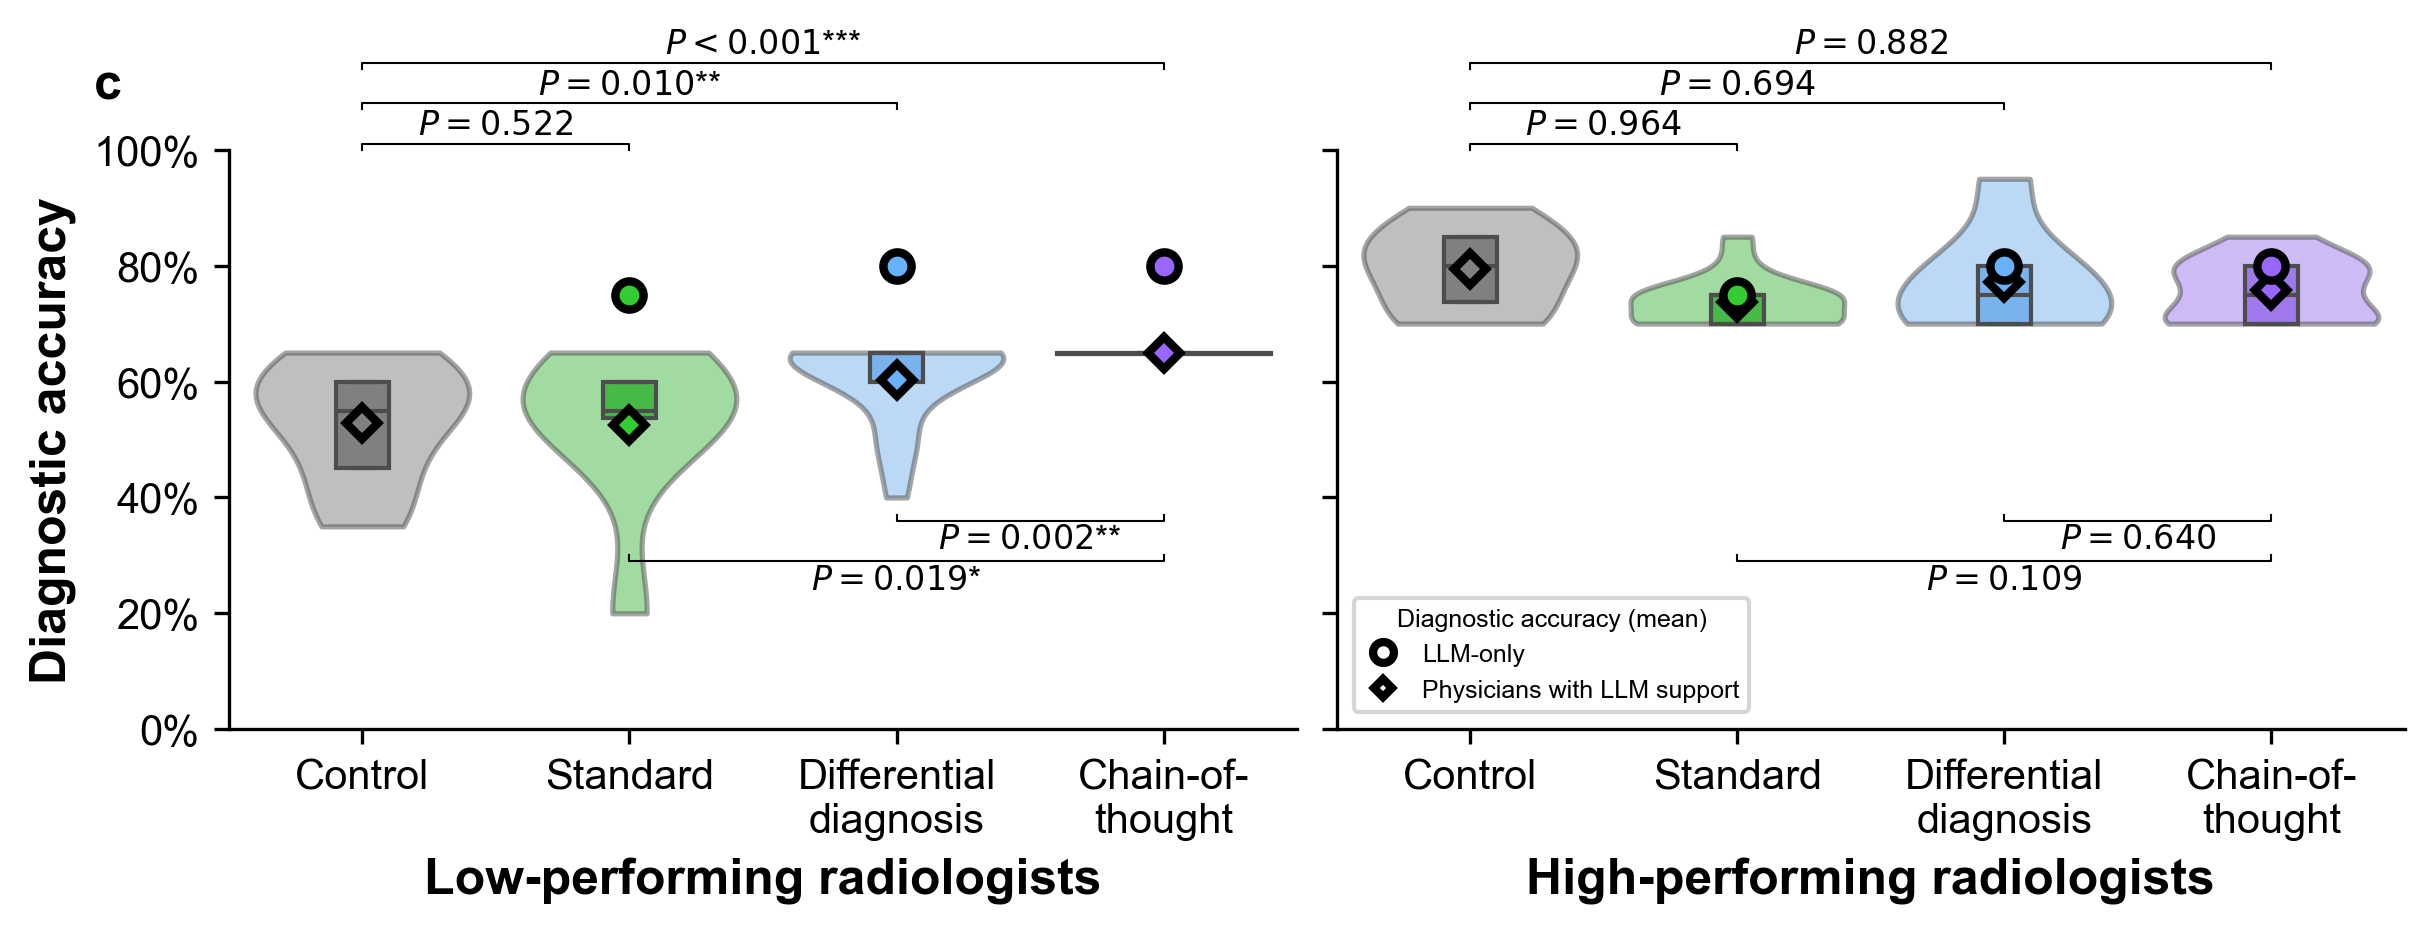

In [118]:
# select data and create plot
fig, axs = plt.subplots(1,2, figsize=(8,3),sharey=True)
kwargs_plot = dict(x='condition', y='correctness', order=order, hue='condition', hue_order=order)

for count,(ax,d,title) in enumerate(zip(axs,[df_subgroup_left,df_subgroup_right],['Low-performing radiologists','High-performing radiologists'])):
    box = sns.boxplot(data=d,width=.2, showfliers=False, ax=ax, whis=0, **kwargs_plot)
    vio = sns.violinplot(data=d, alpha=0.5, ax=ax, inner=None, cut=0, **kwargs_plot)
    for violin in vio.collections: violin.set_alpha(0.5) 
    
    # Some adjustments
    ax.set_xlabel(title); ax.set_ylabel('Diagnostic accuracy')
    ax.set_xticklabels([fill(_.get_text().capitalize(),width=12) for _ in ax.get_xticklabels()],)
    ax.set_ylim(0,1)
    ax.grid(visible=False)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
    labels = [textwrap.fill(map_condition_label(tick.get_text()), width=12) for tick in ax.get_xticklabels()]
    ax.set_xticklabels(labels, rotation=0)
    
    annotate_tests(p_values=tests(d),order=order,ymax=1,ax=ax,low_test_margin=0.06,low_offset=-0.1)
    
    if count == 0: ax.text(-0.1, 1.15, 'c', transform=ax.transAxes, fontsize=12, fontweight='bold', va='top', ha='right')
    # Annotate sample sizes
    # n = len(d)
    # ax.text(0.95, 0.95, f'$n={n}$', ha='right', va='top', transform=ax.transAxes, fontsize=8, fontdict={'color': 'black'})
    gpt_performance_df = pd.DataFrame(list(gpt_performance.items()), columns=['condition', 'accuracy'])
    
    sns.pointplot(data=d, x='condition', y='correctness', estimator=np.mean,markers='D',scale=1,ax=ax, linestyles='',
                  hue='condition',errorbar=None,order=order,hue_order=order, zorder=10)
    
    sns.pointplot(data=gpt_performance_df, x='condition', y='accuracy', markers='o', join=False, ax=ax, hue='condition', hue_order=order, order=order, zorder=10)

plt.legend(handles=[
    plt.Line2D([0], [0], marker='o', color='gray', markerfacecolor='none', label='LLM-only', markersize=5, markeredgewidth=2, linestyle='None'), 
    plt.Line2D([0], [0], marker='D', color='gray', markerfacecolor='none', label='Physicians with LLM support', markersize=3, markeredgewidth=2, linestyle='None')
    ], loc='lower left', title_fontsize=6, prop={'size': 6}, title='Diagnostic accuracy (mean)');


# Show and save plot
# plt.tight_layout()

try:
    ax.get_figure().savefig(f'../Results/Plots/performance_subgroup_correctness_radiology.pdf')
except FileNotFoundError:
    warnings.warn('Create "../Results/Plots folder" to save figure files')

In [119]:
model_left = fit(df_subgroup_left,'correctness','condition')
print(model_left.summary())
# save_tex('OLS regression for subgroup with low diagnostic accuracy',model_left,
#          caption=r'\textbf{OLS regression of diagnostic accuracy on conditions with a subgroup of low-performing radiologists (less than 0.664 accuracy).} The intercept coefficient is 0.528 with a P-value of \(<0.001\) and a \(95\%\) confidence interval of \([0.481, 0.575]\). The standard group has an effect (difference = -0.3 percentage points, \(95\%\) CI = \([-8.4, 7.8]\), \(P = 0.939\)) and is not statistically significant. The differential diagnosis group shows a positive and statistically significant effect (difference = 7.4 percentage points, \(95\%\) CI = \([1.3, 13.5]\), \(P = 0.018\)). The chain-of-thought group has a positive and statistically significant effect (difference = 12.2 percentage points, \(95\%\) CI = \([1.7, 22.7]\), \(P = 0.023\)).')

                            OLS Regression Results                            
Dep. Variable:            correctness   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.135
Method:                 Least Squares   F-statistic:                     3.603
Date:                Mon, 10 Mar 2025   Prob (F-statistic):             0.0201
Time:                        08:34:11   Log-Likelihood:                 50.804
No. Observations:                  51   AIC:                            -93.61
Df Residuals:                      47   BIC:                            -85.88
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [120]:
model_right = fit(df_subgroup_right,'correctness','condition')
print(model_right.summary())
# save_tex('OLS regression for subgroup with high diagnostic accuracy',model_right,
#          caption=r'\textbf{OLS regression of diagnostic accuracy on conditions with a subgroup of low-performing radiologists (more or equal to 0.664 accuracy).} The intercept is estimated at 0.794 with a highly significant P-value (\(P < 0.001\)), indicating the baseline performance. The standard group has a negative effect (difference = -5.6 percentage points, \(95\%\) CI = \([-0.108, -0.004]\), \(P = 0.035\)) and is statistically significant. The differential diagnosis group has a small negative effect (difference = -2.2 percentage points, \(95\%\) CI = \([-0.085, 0.040]\), \(P = 0.475\)) and is not significant. Similarly, the chain-of-thought group has a negative effect (difference = -3.6 percentage points, \(95\%\) CI = \([-0.087, 0.015]\), \(P = 0.163\)) but does not reach statistical significance.')

                            OLS Regression Results                            
Dep. Variable:            correctness   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     1.685
Date:                Mon, 10 Mar 2025   Prob (F-statistic):              0.183
Time:                        08:34:11   Log-Likelihood:                 71.855
No. Observations:                  50   AIC:                            -135.7
Df Residuals:                      46   BIC:                            -128.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

## Easy and difficult tasks (based on accuracy in control group)

In [121]:
mean_perf_by_case = df.query("condition == 'control'").groupby('question')['correctness'].mean()
correctness_cutoff = df.query("condition == 'control'").groupby('question')['correctness'].mean().quantile(0.5)

complex_cases = mean_perf_by_case[mean_perf_by_case.lt(correctness_cutoff)].index.tolist()
basic_cases   = mean_perf_by_case[mean_perf_by_case.ge(correctness_cutoff)].index.tolist()

df_subgroup_left = df[df.question.isin(basic_cases)].groupby('ResponseId').agg(agg_fns)
df_subgroup_right = df[df.question.isin(complex_cases)].groupby('ResponseId').agg(agg_fns)

df_subgroup_left['condition'] = pd.Categorical(df_subgroup_left['condition'], categories=['control', 'standard', 'differential','chain-of-thought'])
df_subgroup_right['condition'] = pd.Categorical(df_subgroup_right['condition'], categories=['control', 'standard', 'differential','chain-of-thought'])

In [122]:
len(basic_cases)

10

In [123]:
len(complex_cases)

10

ANOVA results: F-value = 4.641, p-value = 0.004
Control vs. Standard: t-statistic = 0.906, p-value = 0.815
Control vs. DD: t-statistic = 1.807, p-value = 0.961
Control vs. CoT: t-statistic = -1.655, p-value = 0.053
Standard vs. CoT: t-statistic = -2.743, p-value = 0.005
DD vs. CoT: t-statistic = -4.499, p-value = 0.000
Standard vs. DD: t-statistic = 0.744, p-value = 0.770
ANOVA results: F-value = 7.690, p-value = 0.000
Control vs. Standard: t-statistic = -2.919, p-value = 0.003
Control vs. DD: t-statistic = -1.587, p-value = 0.061
Control vs. CoT: t-statistic = -4.024, p-value = 0.000
Standard vs. CoT: t-statistic = -1.249, p-value = 0.109
DD vs. CoT: t-statistic = -3.622, p-value = 0.000
Standard vs. DD: t-statistic = 1.971, p-value = 0.973


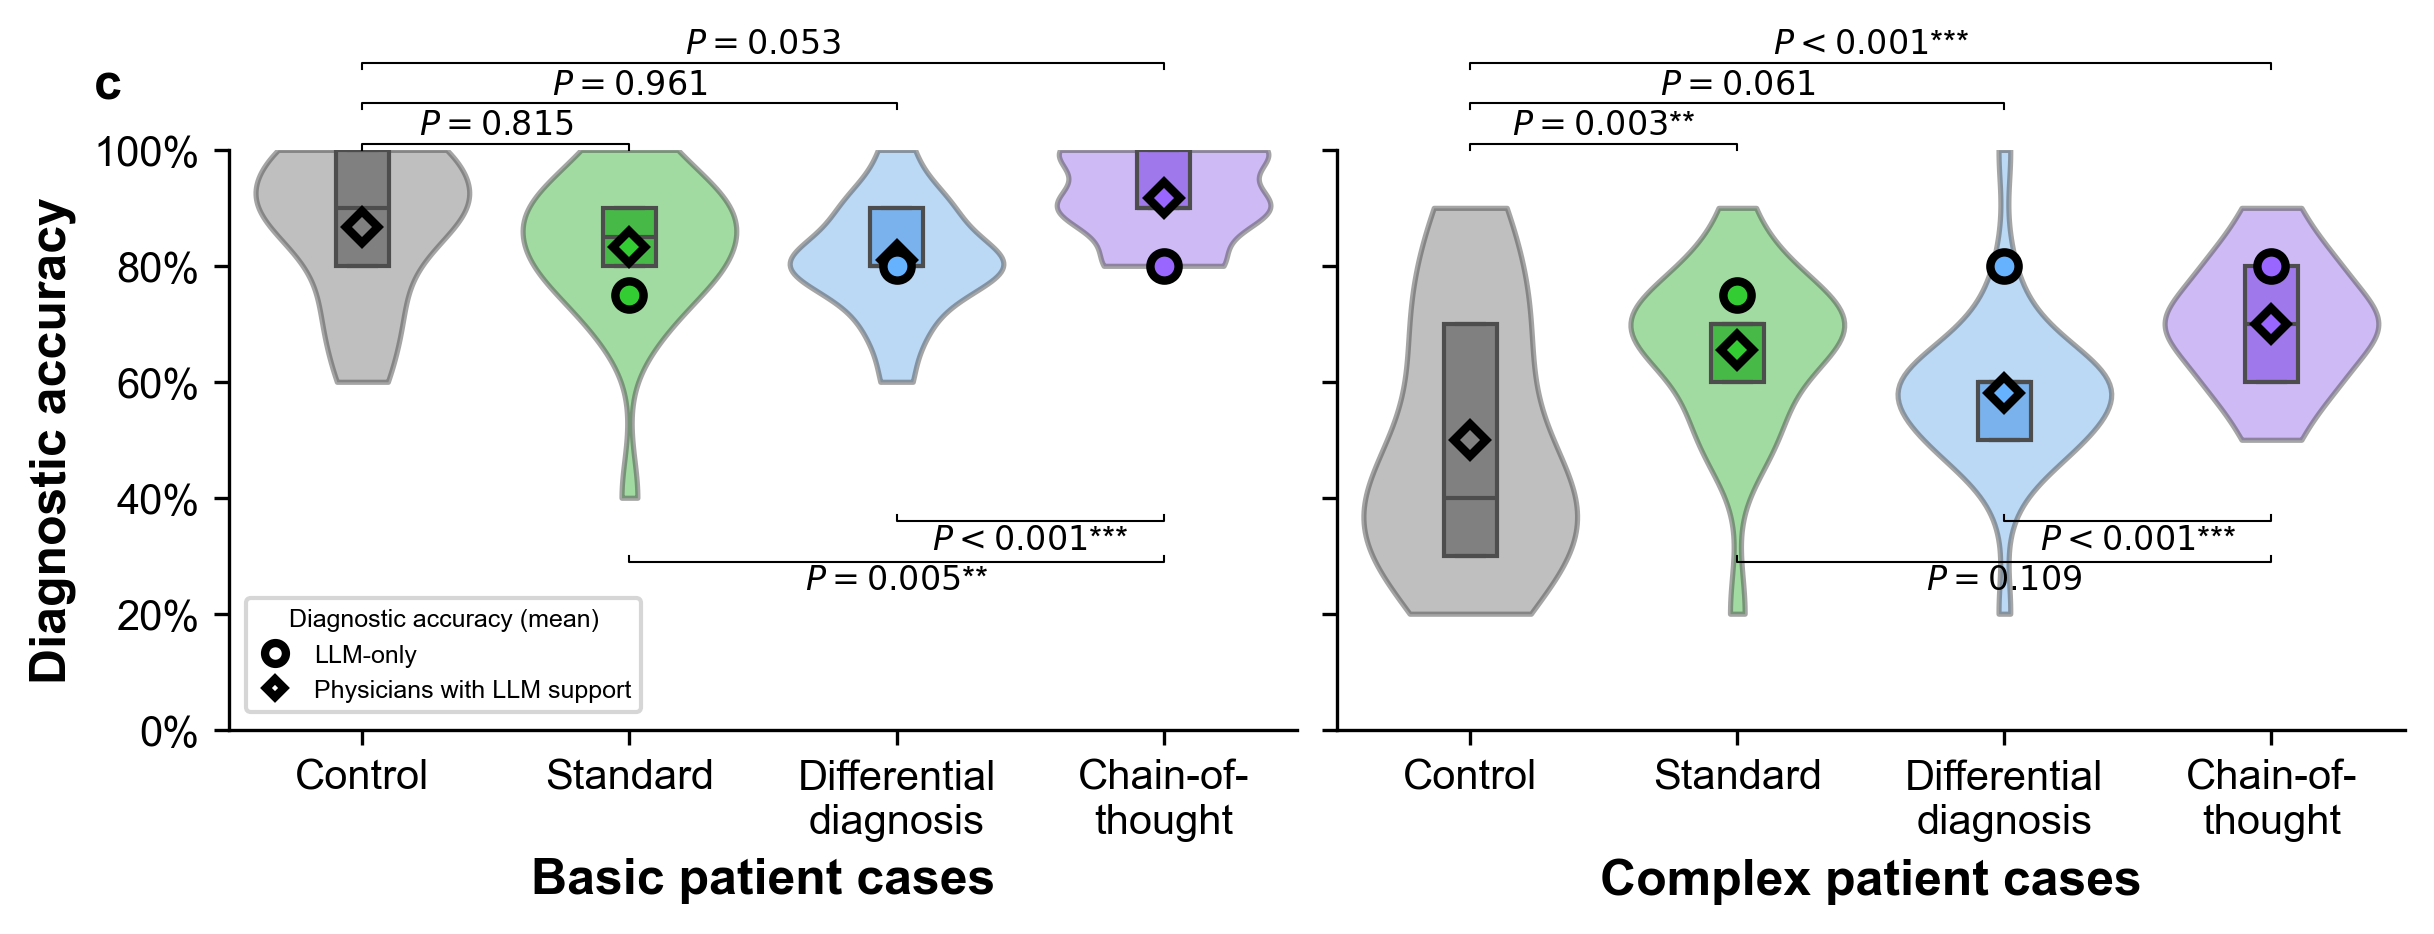

In [124]:
# select data and create plot
fig, axs = plt.subplots(1,2, figsize=(8,3),sharey=True)
kwargs_plot = dict(x='condition', y='correctness', order=order, hue='condition', hue_order=order)

for count,(ax,d,title) in enumerate(zip(axs,[df_subgroup_left,df_subgroup_right],['Basic patient cases','Complex patient cases'])):
    box = sns.boxplot(data=d,width=.2, showfliers=False, ax=ax, whis=0, **kwargs_plot)
    vio = sns.violinplot(data=d, alpha=0.5, ax=ax, inner=None, cut=0, **kwargs_plot)
    for violin in vio.collections: violin.set_alpha(0.5) 
    
    # Some adjustments
    ax.set_xlabel(title); ax.set_ylabel('Diagnostic accuracy')
    ax.set_xticklabels([fill(_.get_text().capitalize(),width=12) for _ in ax.get_xticklabels()],)
    ax.set_ylim(0,1)
    ax.grid(visible=False)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
    labels = [textwrap.fill(map_condition_label(tick.get_text()), width=12) for tick in ax.get_xticklabels()]
    ax.set_xticklabels(labels, rotation=0)
    
    annotate_tests(p_values=tests(d),order=order,ymax=1,ax=ax,low_test_margin=0.06,low_offset=-0.1)
    
    if count == 0: ax.text(-0.1, 1.15, 'c', transform=ax.transAxes, fontsize=12, fontweight='bold', va='top', ha='right')
    # Annotate sample sizes
    # n = len(d)
    # ax.text(0.95, 0.95, f'$n={n}$', ha='right', va='top', transform=ax.transAxes, fontsize=8, fontdict={'color': 'black'})
    gpt_performance_df = pd.DataFrame(list(gpt_performance.items()), columns=['condition', 'accuracy'])
    
    sns.pointplot(data=d, x='condition', y='correctness', estimator=np.mean,markers='D',scale=1,ax=ax, linestyles='',
                  hue='condition',errorbar=None,order=order,hue_order=order, zorder=10)
    
    sns.pointplot(data=gpt_performance_df, x='condition', y='accuracy', markers='o', join=False, ax=ax, hue='condition', hue_order=order, order=order, zorder=10)

    if count == 0: ax.legend(handles=[
        plt.Line2D([0], [0], marker='o', color='gray', markerfacecolor='none', label='LLM-only', markersize=5, markeredgewidth=2, linestyle='None'), 
        plt.Line2D([0], [0], marker='D', color='gray', markerfacecolor='none', label='Physicians with LLM support', markersize=3, markeredgewidth=2, linestyle='None')
        ], loc='lower left', title_fontsize=6, prop={'size': 6}, title='Diagnostic accuracy (mean)');

# Show and save plot
# plt.tight_layout()
try:
    ax.get_figure().savefig(f'../Results/Plots/performance_subgroup_difficulty_control_group.pdf')
except FileNotFoundError:
    warnings.warn('Create "../Results/Plots folder" to save figure files')

In [125]:
df_subgroup_left.condition.value_counts()

condition
differential        30
control             24
standard            24
chain-of-thought    23
Name: count, dtype: int64

In [126]:
model_left = fit(df_subgroup_left,'correctness','condition')
print(model_left.summary())
save_tex('OLS regression for basic patient cases',model_left,
         caption=r'\textbf{OLS regression of diagnostic accuracy by conditions with a subset of basic patient cases.} We split patient cases into basic and complex subsets based on the mean diagnostic accuracy of the control group for each case, with the median as the dividing line. We then performed OLS regression of diagnostic accuracy on case conditions separately for the basic and complex subgroups. The intercept is estimated at 0.867 with a highly significant $P$-value (\(P < 0.001\)). The standard group has a negligible effect (difference = -3.3 percentage points, \(95\%\) CI = \([-9.6, 2.9]\), \(P = 0.291\)) and is not significant. The differential diagnosis group has a negative and non-significant effect (difference = -5.7 percentage points, \(95\%\) CI = \([-11.6, 0.2]\), \(P = 0.060\)). The chain-of-thought group shows a positive but non-significant effect (difference = 5.1 percentage points, \(95\%\) CI = \([-1.2, 11.4]\), \(P = 0.113\)).')

                            OLS Regression Results                            
Dep. Variable:            correctness   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     4.641
Date:                Mon, 10 Mar 2025   Prob (F-statistic):            0.00448
Time:                        08:34:11   Log-Likelihood:                 82.837
No. Observations:                 101   AIC:                            -157.7
Df Residuals:                      97   BIC:                            -147.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [127]:
model_right = fit(df_subgroup_right,'correctness','condition')
print(model_right.summary())
save_tex('OLS regression for complex patient cases',model_right,
         caption=r'\textbf{OLS regression of diagnostic accuracy by conditions with a subset of complex cases.} We split patient cases into basic and complex subsets based on the mean diagnostic accuracy of the control group for each case, with the median as the dividing line. We then performed OLS regression of diagnostic accuracy on case conditions separately for the basic and complex subgroups. The intercept is estimated at 0.500 with a significant $P$-value ($P < 0.001$). The standard condition shows a positive and significant effect (difference = 15.4 percentage points, $95\%$ CI = [6.6, 24.3], $P = 0.001$). The differential condition has a positive but non-significant effect (difference = 8.0 percentage points, $95\%$ CI = [-0.4, 16.4], $P = 0.061$). The chain-of-thought condition demonstrates a positive significant effect (difference = 20.0 percentage points, $95\%$ CI = [11.1, 28.9], $P < 0.001$).')

                            OLS Regression Results                            
Dep. Variable:            correctness   R-squared:                       0.192
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     7.690
Date:                Mon, 10 Mar 2025   Prob (F-statistic):           0.000116
Time:                        08:34:11   Log-Likelihood:                 47.523
No. Observations:                 101   AIC:                            -87.05
Df Residuals:                      97   BIC:                            -76.58
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

## Winsorzied correctness

In [128]:
lower_quantile = df_reg['correctness'].quantile(0.05)
upper_quantile = df_reg['correctness'].quantile(0.95)
df_reg['correctness_winsorized'] = df_reg['correctness'].clip(lower=lower_quantile, upper=upper_quantile)

In [129]:
# df_reg['condition'] = pd.Categorical(df_reg['condition'], categories=['control','chain-of-thought', 'standard', 'differential'])
model = fit(df_reg,'correctness_winsorized','condition')
print(model.summary())

save_tex(fn='OLS regression of winsorized diagnostic accuracy on conditions', model=model,
         caption=r'\textbf{OLS regression of winsorized diagnostic accuracy on conditions.} The intercept is estimated at 0.625 with a highly significant P-value (\(P < 0.001\)). The standard group has a positive non-significant effect (difference = 5.2 percentage points, \(95\%\) CI = \([-0.6, 11.0]\), \(P = 0.079\)). The differential diagnosis group has a positive non-significant effect (difference = 1.5 percentage points, \(95\%\) CI = \([-4.0, 7.0]\), \(P = 0.591\)). In contrast, the chain-of-thought group has a positive significant effect (difference = 11.4 percentage points, \(95\%\) CI = \([5.5, 17.3]\), \(P < 0.001\)).')

                              OLS Regression Results                              
Dep. Variable:     correctness_winsorized   R-squared:                       0.157
Model:                                OLS   Adj. R-squared:                  0.131
Method:                     Least Squares   F-statistic:                     6.012
Date:                    Mon, 10 Mar 2025   Prob (F-statistic):           0.000844
Time:                            08:34:11   Log-Likelihood:                 89.666
No. Observations:                     101   AIC:                            -171.3
Df Residuals:                          97   BIC:                            -160.9
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

## Mixed effects regression

In [130]:
df['condition'] = pd.Categorical(df['condition'], categories=['control', 'standard', 'differential','chain-of-thought'])

In [131]:
df.rename(columns={'medical-experience': 'medicalexperience',
                                     'radiology-experience': 'radiologyexperience',
                                     'weekly-inspection-time': 'weeklyinspectiontime', 
                                     'IT-skills': 'ITskills', 
                                     'medical-AI-experience': 'medicalAIexperience'}).dropna(subset='medicalexperience') \
    .groupby('condition')['correctness'].count()

condition
control             460
standard            480
differential        600
chain-of-thought    440
Name: correctness, dtype: int64

In [132]:
from pymer4.models import Lmer
model = Lmer("correctness ~ C(condition) + medicalexperience + radiologyexperience + C(weeklyinspectiontime) + C(ITskills) + medicalAIexperience + (1|question) + (1|ResponseId)", 
             data=df.rename(columns={'medical-experience': 'medicalexperience',
                                     'radiology-experience': 'radiologyexperience',
                                     'weekly-inspection-time': 'weeklyinspectiontime', 
                                     'IT-skills': 'ITskills', 
                                     'medical-AI-experience': 'medicalAIexperience'}).dropna(subset='medicalexperience'), 
             family='binomial')

print(model.fit(maxiter=10000,))

Model failed to converge with max|grad| = 0.0177344 (tol = 0.002, component 1) 

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: correctness~C(condition)+medicalexperience+radiologyexperience+C(weeklyinspectiontime)+C(ITskills)+medicalAIexperience+(1|question)+(1|ResponseId)

Family: binomial	 Inference: parametric

Number of observations: 1980	 Groups: {'ResponseId': 99.0, 'question': 20.0}

Log-likelihood: -871.472 	 AIC: 1780.944

Random effects:

                   Name    Var    Std
ResponseId  (Intercept)  0.235  0.485
question    (Intercept)  2.276  1.509

No random effect correlations specified

Fixed effects:

                               Estimate  2.5_ci  97.5_ci     SE     OR  \
(Intercept)                       1.033  -0.581    2.646  0.823  2.808   
C(condition)standard              0.548   0.062    1.034  0.248  1.730   
C(condition)differential          0.095  -0.379    0.569  0.242  1.100   
C(condition)chain-of-thought      1.142   0.633    1.650  

In [133]:
summary_df = model.coefs[['Estimate','SE','P-val','2.5_ci','97.5_ci']]

ci = [f"[{low:.3f}; {high:.3f}]" for low, high in zip(summary_df['2.5_ci'], summary_df['97.5_ci'])]
summary_df['95 % CI'] = ci
summary_df = summary_df.drop(['2.5_ci','97.5_ci'],axis=1)
summary_df.columns = ['Coef.','s.e.','$P$-value','95 % CI']

summary_df['$P$-value'] = summary_df['$P$-value'].apply(lambda o: o if o >= 0.0005 else '$< 0.001$')
summary_df

Coef.      s.e.  $P$-value          95 % CI
(Intercept)                    1.032530  0.823291   0.209788  [-0.581; 2.646]
C(condition)standard           0.548055  0.247966   0.027091   [0.062; 1.034]
C(condition)differential       0.095258  0.241879   0.693712  [-0.379; 0.569]
C(condition)chain-of-thought   1.141635  0.259530  $< 0.001$   [0.633; 1.650]
medicalexperience              0.001068  0.011162   0.923758  [-0.021; 0.023]
radiologyexperience           -0.007618  0.006741   0.258434  [-0.021; 0.006]
C(weeklyinspectiontime)30-35h  0.740563  0.663340   0.264244  [-0.560; 2.041]
C(weeklyinspectiontime)35-40h  0.362824  0.610248   0.552143  [-0.833; 1.559]
C(weeklyinspectiontime)40-45h  0.551720  0.607401   0.363704  [-0.639; 1.742]
C(weeklyinspectiontime)45-50h  0.536725  0.590246   0.363178  [-0.620; 1.694]
C(weeklyinspectiontime)50-55h  0.300390  0.603962   0.618932  [-0.883; 1.484]
C(weeklyinspectiontime)>55h    0.315921  0.617824    0.60911  [-0.895; 1.527]
C(ITskills)Good                0.070370  0.284725   0.804791  [-0.488; 0.628]
C(ITskills)Very Good           0.554673  0.298653   0.063276  [-0.031; 1.140]
C(ITskills)Advanced            0.514797  0.316432   0.103763  [-0.105; 1.135]
C(ITskills)Expert              0.328690  0.451866   0.466977  [-0.557; 1.214]
medicalAIexperience           -0.003041  0.003028   0.315165  [-0.009; 0.003]

In [134]:
df['weekly-inspection-time'].unique()

['45-50h', '40-45h', '50-55h', NaN, '35-40h', '>55h', '30-35h', '<30h']
Categories (7, object): ['<30h', '30-35h', '35-40h', '40-45h', '45-50h', '50-55h', '>55h']

In [135]:
summary_df.index =  ["intercept", "condition_standard", "condition_differential", "condition_chain-of-thought", 
                     "medical experience", "radiology experience", 
                     "weekly inspection time: 30-35h", "weekly inspection time: 35-40h", "weekly inspection time: 40-45h",
                     "weekly inspection time: 45-50h", "weekly inspection time: 50-55h", "weekly inspection time: >55h",
                     "IT skills: Good", "IT skills: Very Good", "IT skills: Advanced", "IT skills: Expert",
                     "medical AI experience"]

o = {'AIC': model.AIC,'Obs ($N$)': int(model.data.shape[0])} | dict(zip(['Variance explained by ResponseId','Variance explained by Question'],model.ranef_var['Var'].values))
save_tex('Mixed effects model',summary_df=summary_df,add_info=o, 
         caption=r'\textbf{Mixed effects model on diagnostic accuracy.} The intercept is estimated at 1.035 with a non-significant $P$-value ($P = 0.209$). The standard condition shows a positive and statistically significant effect (coef = 0.548, \(95\%\) CI = \([0.062, 1.034]\), $P = 0.027$). The differential condition has a non-significant effect (coefficient = 0.095, \(95\%\) CI = \([-0.379, 0.569]\), $P = 0.695$). The chain-of-thought condition shows a positive significant effect (coefficient = 1.141, \(95\%\) CI = \([0.632, 1.649]\), $P < 0.001$). The model includes random intercepts for ResponseId and Question. The variance explained by ResponseId is 0.235, and the variance explained by Question is 2.275.')

## Quasi-binomial to control for assumption of OLS normal distribution

In [136]:
# model = smf.glm('correctness ~ C(condition)', data=df_reg, family=sm.families.Binomial()).fit()
# print(model.summary())

In [137]:
model = smf.glm('correctness ~ C(condition)', 
                data=df_reg, family=sm.families.Binomial()).fit(scale='X2')
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:            correctness   No. Observations:                  101
Model:                            GLM   Df Residuals:                       97
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                        0.062664
Method:                          IRLS   Log-Likelihood:                -43.682
Date:                 Mo, 10 Mär 2025   Deviance:                       6.3180
Time:                        08:34:19   Pearson chi2:                     6.08
No. Iterations:                     6   Pseudo R-squ. (CS):           0.008975
Covariance Type:            nonrobust                                         
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

In [138]:
save_tex(fn='Quasi-binomial model', model=model,
         caption=r'\textbf{Quasi-binomial regression on diagnostic accuracy by conditions.} The intercept is estimated at 0.4754 with a non-significant P-value (\(P = 0.257\)). The standard group has a small positive but non-significant effect (coef = 0.218, \(95\%\) CI = \([-0.964, 1.400]\), \(P = 0.718\)). The differential diagnosis group shows a positive but non-significant effect (coef = 0.107, \(95\%\) CI = \([-1.004, 1.218]\), \(P = 0.850\)). Similarly, the chain-of-thought group has a positive but non-significant effect (coef = 0.566, \(95\%\) CI = \([-0.676, 1.808]\), \(P = 0.372\)).')

# Regression on time

## Conditions only

In [139]:
df_reg.groupby('condition')['total-time'].describe().loc[:,['mean','std']]

mean        std
condition                             
control           26.456247  16.784756
standard          30.828483  39.815680
differential      49.233742  94.198108
chain-of-thought  45.731393  72.350877

In [140]:
model = fit(df_reg,'total-time','condition')
print(model.summary())
#save_tex('OLS regression of time on conditions',model, caption='OLS regression of time on conditions. The intercept coefficient is 26.456 with a P-value of 0.050 and a 95\% confidence interval of [-0.057; 52.969]. The standard condition arm has a coefficient of 4.372, a P-value of 0.817, and a confidence interval of [-33.123; 41.867]. The differential diagnosis intervention arm shows a coefficient of 22.777, a P-value of 0.207, and a confidence interval of [-12.793; 58.348]. The chain-of-thought intervention arm has a coefficient of 19.275, a P-value of 0.315, and a confidence interval of [-18.625; 57.175].')

                            OLS Regression Results                            
Dep. Variable:             total-time   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                    0.7433
Date:                 Mo, 10 Mär 2025   Prob (F-statistic):              0.529
Time:                        08:34:19   Log-Likelihood:                -563.57
No. Observations:                 101   AIC:                             1135.
Df Residuals:                      97   BIC:                             1146.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

## On a case basis

In [141]:
df_reg_time['time-per-case'] = df_reg_time['time-per-case'] * 60 
df_reg_time['condition'] = pd.Categorical(df_reg_time['condition'], categories=['control', 'standard', 'differential', 'chain-of-thought'])
model = fit(df_reg_time,'time-per-case','condition')
print(model.summary())
save_tex('OLS regression of time per case on conditions',model, 
         caption=r'\textbf{OLS regression of time per case on conditions.} The intercept is estimated at 79.369 with a significant $P$-value ($P = 0.012$). The standard group has a positive effect (difference = 13.117 seconds, $95\%$ CI = [-73.209, 99.443], $P = 0.763$) but is not significant. The differential diagnosis group shows a positive effect (difference = 68.332 seconds, $95\%$ CI = [-17.994, 154.659], $P = 0.119$) but does not reach statistical significance. Similarly, the chain-of-thought group has a positive effect (difference = 57.825 seconds, $95\%$ CI = [-28.501, 144.152], $P = 0.186$) but is not statistically significant.')

                            OLS Regression Results                            
Dep. Variable:          time-per-case   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     1.184
Date:                 Mo, 10 Mär 2025   Prob (F-statistic):              0.322
Time:                        08:34:19   Log-Likelihood:                -505.10
No. Observations:                  80   AIC:                             1018.
Df Residuals:                      76   BIC:                             1028.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [142]:
df_reg_time['condition'] = pd.Categorical(df_reg_time['condition'], categories=['standard', 'differential', 'chain-of-thought'])
model = fit(df_reg_time.dropna(subset='condition'),'time-per-case','condition')
print(model.summary())
save_tex('OLS regression of time per case on conditions and standard as control',model, 
         caption=r'\textbf{OLS regression of time per case on conditions.} The standard output group is set as the reference group. The intercept is estimated at 85.927 with a significant $P$-value ($P < 0.001$). The differential diagnosis group shows a positive effect (difference = 61.774 seconds, $95\%$ CI = [-12.529, 136.077], $P = 0.102$) but does not reach statistical significance. Similarly, the chain-of-thought group has a positive effect (difference = 51.267 seconds, $95\%$ CI = [-23.036, 125.570], $P = 0.173$) but is not statistically significant.')

                            OLS Regression Results                            
Dep. Variable:          time-per-case   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                    0.7058
Date:                 Mo, 10 Mär 2025   Prob (F-statistic):              0.498
Time:                        08:34:19   Log-Likelihood:                -386.62
No. Observations:                  60   AIC:                             779.2
Df Residuals:                      57   BIC:                             785.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

## Control variables included

In [143]:
treatment = ['condition']
target = ['correctness']
controls = ['total-time','medical-experience','radiology-experience', 'advice-length', 'answer-length',
            'weekly-inspection-time','IT-skills','medical-AI-experience','assistive-tools',]

# df['condition'] = pd.Categorical(df.condition, categories=['control', 'standard', 'differential','chain-of-thought',])

In [144]:
df_encoded = pd.get_dummies(
    df_reg[target + treatment + controls].dropna(axis=0), 
    drop_first=True,)

# change order of columns 
first_cols = df_encoded[['condition_standard','condition_differential','condition_chain-of-thought']]
df_encoded.drop(['condition_standard','condition_differential','condition_chain-of-thought'], axis=1,inplace=True)
df_encoded = pd.concat([first_cols,df_encoded],axis=1)

target = 'correctness'
X = df_encoded.drop(target, axis=1)
Y = df_encoded[target]
X = sm.add_constant(X)

model = sm.OLS(Y, X.astype(float)).fit()


print(model.summary())
# save_tex('OLS regression of time on conditions with controls',model)

                            OLS Regression Results                            
Dep. Variable:            correctness   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                     1.638
Date:                 Mo, 10 Mär 2025   Prob (F-statistic):             0.0671
Time:                        08:34:19   Log-Likelihood:                 80.811
No. Observations:                  99   AIC:                            -121.6
Df Residuals:                      79   BIC:                            -69.72
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

# Regression on adherence

## Conditions only

In [145]:
df_adh.groupby('condition')['Adherence'].describe().loc[:,['mean','std']]

mean       std
condition                           
chain-of-thought  0.578261  0.494375
differential      0.795000  0.404038
standard          0.483333  0.500244

In [146]:
df_adh['condition'] = pd.Categorical(df_adh['condition'], categories=['chain-of-thought','differential', 'standard'])

model = fit(df_adh,'Adherence','condition')
print(model.summary())
save_tex('OLS regression of adherence on conditions',model, 
         caption=r'\textbf{OLS regression of adherence on conditions.} The intercept is estimated at 0.578 with a highly significant P-value (\(P < 0.001\)). The differential diagnosis group has a positive and  significant effect (difference = 21.7 percentage points, \(95\%\) CI = \([16.0, 27.3]\), \(P < 0.001\)). In contrast, the standard group has a negative and significant effect (difference = -9.5 percentage points, \(95\%\) CI = \([-15.4, -3.6]\), \(P = 0.002\)).')

                            OLS Regression Results                            
Dep. Variable:              Adherence   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     64.95
Date:                 Mo, 10 Mär 2025   Prob (F-statistic):           8.33e-28
Time:                        08:34:19   Log-Likelihood:                -998.64
No. Observations:                1540   AIC:                             2003.
Df Residuals:                    1537   BIC:                             2019.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0

In [147]:
df_adh.condition.value_counts()

condition
differential        600
standard            480
chain-of-thought    460
Name: count, dtype: int64

## Control variables included

In [148]:
map_values = {'less':'yes','more':'yes'}
df_adh = prepare_adh_df(df,map_values)

In [149]:
treatment = ['condition']
target = ['Adherence']
controls = ['total-time',
            'medical-experience',
            'radiology-experience', 
            'advice-length', 'answer-length',
            'weekly-inspection-time',
            'IT-skills',
            'medical-AI-experience',
            'assistive-tools', 
            ]

# df_adh['condition'] = pd.Categorical(df.condition, categories=['standard', 'differential','chain-of-thought',])
df_adh['condition'] = pd.Categorical(df_adh['condition'], categories=['chain-of-thought','differential', 'standard'])

# df_adh = df_adh.reset_index()

In [150]:
# add control variables
df_adh = pd.merge(left=df_adh, right=participant_vars, how='left', 
                  validate='1:m', left_index=True, right_index=True)

df_adh.rename(col_name_changes, axis=1, inplace=True)

# add total time
df_adh['total-time'] = df_adh[times_cols].sum(axis=1) / 1000 / 60

# add advice length
df_adh = df_adh.reset_index()
df_adh = df_adh.merge(length_df.groupby('condition')['advice-length'].mean(), how='left',on='condition',validate='m:1')
df_adh['advice-length'] = df_adh['advice-length'].fillna(0)

# add answer length
df_adh = df_adh.merge(df.groupby('ResponseId').agg({'answer-length':'mean','condition':'first'}), how='left',on=['ResponseId','condition'],validate='1:1')
df_adh

ResponseId         condition  Adherence           StartDate  \
0   R_10vjyyr8j51riwX      differential       0.80 2024-11-23 21:07:26   
1   R_1CsZuXiqwalCXnP          standard       0.75 2024-11-24 15:55:16   
2   R_1D6DTqOxDt0JFsE      differential       0.95 2024-11-22 17:35:49   
3   R_1Hudm1jX6HBh0qg          standard       0.50 2024-11-30 01:08:58   
4   R_1QLj8WYs2NwUFks      differential       0.90 2024-11-27 01:06:58   
..                ...               ...        ...                 ...   
72  R_7hq7cbDopjMEUgN          standard       0.55 2024-11-22 18:17:31   
73  R_7iL6Hwb96uMer6Z  chain-of-thought       0.75 2024-11-21 16:30:33   
74  R_7rHK2aHSBzTB1oH      differential       0.80 2024-11-21 17:33:15   
75  R_7rqzoEZ4RgK2RAf          standard       0.70 2024-11-24 20:32:00   
76  R_7uOb4W2i0Xclv5D      differential       0.80 2024-11-27 15:11:48   

               EndDate  Status        IPAddress  Progress  \
0  2024-11-23 21:30:34       0      73.76.76.59       100   
1  2024-11-24 16:43:26       0    104.28.57.239       100   
2  2024-11-22 18:02:03       0    128.23.128.10       100   
3  2024-11-30 01:21:35       0    69.125.48.110       100   
4  2024-11-27 01:27:14       0    104.28.32.243       100   
..                 ...     ...              ...       ...   
72 2024-11-22 18:40:09       0   208.89.120.247       100   
73 2024-11-21 19:18:32       0   172.58.240.118       100   
74 2024-11-21 18:56:21       0  170.232.227.254       100   
75 2024-11-24 22:23:42       0    38.73.249.238       100   
76 2024-11-27 17:01:39       0    172.56.92.154       100   

    Duration (in seconds)  Finished  ...  t_dd14  t_dd15  t_dd16  t_dd17  \
0                    1388         1  ...  154022   42699   22213  117917   
1                    2889         1  ...       0       0       0       0   
2                    1573         1  ...  324137   53364   32760   63783   
3                     757         1  ...       0       0       0       0   
4                    1216         1  ...   29164   28513   18424   24007   
..                    ...       ...  ...     ...     ...     ...     ...   
72                   1357         1  ...       0       0       0       0   
73                  10078         1  ...       0       0       0       0   
74                   4985         1  ...   89367   38451   51843  628958   
75                   6701         1  ...       0       0       0       0   
76                   6591         1  ...   48023  286398   18151   45811   

    t_dd18  t_dd19  t_dd20  total-time advice-length answer-length  
0    32680   80499   24215   19.425050        208.60         10.25  
1        0       0       0   41.672917         62.65         17.85  
2    29455   43602   15992   16.875267        208.60         21.95  
3        0       0       0    8.120250         62.65         10.10  
4    32477   52386   43973   15.143667        208.60          3.45  
..     ...     ...     ...         ...           ...           ...  
72       0       0       0   18.834550         62.65         42.30  
73       0       0       0  147.614300        188.60         18.70  
74   36648  193285   28850   60.479933        208.60         29.25  
75       0       0       0   20.592267         62.65         23.50  
76   22524   40951   15465  105.986267        208.60         24.65  

[77 rows x 603 columns]

In [151]:
df_encoded = pd.get_dummies(
    df_adh[target + treatment + controls].dropna(axis=0), 
    drop_first=True,)

# change order of columns 
first_cols = df_encoded[['condition_standard','condition_differential']]
df_encoded.drop(['condition_standard','condition_differential'], axis=1,inplace=True)
df_encoded = pd.concat([first_cols,df_encoded],axis=1)

target = 'Adherence'
X = df_encoded.drop(target, axis=1)
Y = df_encoded[target]
X = sm.add_constant(X)

model = sm.OLS(Y, X.astype(float)).fit()


print(model.summary())
# save_tex('OLS regression of adherence on conditions with controls',model)
# save_tex(fn='OLS regression of diagnostic accuracy on conditions on observational level with controls',model=model,)

                            OLS Regression Results                            
Dep. Variable:              Adherence   R-squared:                       0.340
Model:                            OLS   Adj. R-squared:                  0.238
Method:                 Least Squares   F-statistic:                     3.346
Date:                 Mo, 10 Mär 2025   Prob (F-statistic):            0.00146
Time:                        08:34:19   Log-Likelihood:                 59.186
No. Observations:                  76   AIC:                            -96.37
Df Residuals:                      65   BIC:                            -70.73
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0

# Logistic regression on performance on the observation level

## Conditions only

In [152]:
df.condition.value_counts()

condition
differential        600
control             480
standard            480
chain-of-thought    460
Name: count, dtype: int64

In [153]:
df['condition'] = pd.Categorical(df['condition'], categories=['control', 'standard', 'differential','chain-of-thought'])
df_encoded = pd.get_dummies(df[['condition']], drop_first=True)
X = sm.add_constant(df_encoded).astype(float)
Y = df['correctness'].round()

model = sm.Logit(Y, X).fit()
print(model.summary())

save_tex(fn='Logistic regression on the observational level of diagnostic accuracy on conditions',model=model, 
         caption=r'\textbf{Logistic regression on the observational level of diagnostic accuracy on conditions.} The intercept is estimated at 0.769 with a highly significant P-value (\(P < 0.001\)), indicating the baseline diagnostic accuracy. The standard group has a positive and significant effect (coef = 0.296, \(95\%\) CI = \([0.015, 0.577]\), \(P = 0.039\)). The differential diagnosis group has a positive effect (coef = 0.054, \(95\%\) CI = \([-0.205, 0.314]\), \(P = 0.680\)) and is not significant. In contrast, the chain-of-thought group shows a strong positive and significant effect (coef = 0.672, \(95\%\) CI = \([0.371, 0.974]\), \(P < 0.001\)).')

Optimization terminated successfully.
         Current function value: 0.577426
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:            correctness   No. Observations:                 2020
Model:                          Logit   Df Residuals:                     2016
Method:                           MLE   Df Model:                            3
Date:                 Mo, 10 Mär 2025   Pseudo R-squ.:                 0.01050
Time:                        08:34:19   Log-Likelihood:                -1166.4
converged:                       True   LL-Null:                       -1178.8
Covariance Type:            nonrobust   LLR p-value:                 1.736e-05
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          0.7691      0.098      7.839      0.000      

In [154]:
# df['condition'] = pd.Categorical(df['condition'], categories=['control', 'standard', 'differential','chain-of-thought'])
# model = fit(df,'correctness','condition')
# print(model.summary())
# save_tex(fn='OLS regression of diagnostic accuracy on conditions on observational level',model=model,)

## Controlling for study factors

In [155]:
treatment = ['condition']
target = ['correctness']
controls = ['time-per-case',
            'advice-length', 
            'answer-length',
            ]

df['condition'] = pd.Categorical(df.condition, categories=['control','standard', 'differential','chain-of-thought'])

df_encoded = pd.get_dummies(
    df[target + treatment + controls].dropna(axis=0), 
    drop_first=True,)

# change order of columns 
first_cols = df_encoded[['condition_standard','condition_differential','condition_chain-of-thought']]
df_encoded.drop(['condition_standard','condition_differential','condition_chain-of-thought'], axis=1,inplace=True)
df_encoded = pd.concat([first_cols,df_encoded],axis=1)

X = sm.add_constant(df_encoded.drop('correctness',axis=1)).astype(float)
Y = df_encoded['correctness'].round()

model = sm.Logit(Y, X).fit()
print(model.summary())
#save_tex(fn='Logistic regression on observational level of diagnostic accuracy on conditions with control for study factors',model=model, caption='Logistic regression on observational level of diagnostic accuracy on conditions with control for study factors. The intercept coefficient is 0.875 with a P-value of <0.001 and a 95\% confidence interval of [0.638; 1.111]. The standard intervention arm has a coefficient of 0.828, a P-value of 0.001, and a confidence interval of [0.356; 1.300]. The differential diagnosis intervention arm shows a coefficient of 1.751, a P-value of 0.008, and a confidence interval of [0.465; 3.037]. The chain-of-thought intervention arm has a coefficient of 2.242, a P-value of <0.001, and a confidence interval of [1.053; 3.431]. Total-Time has a coefficient of 0.001, a P-value of 0.214, and a confidence interval of [-0.001; 0.003]. Advice-Length has a coefficient of -0.008, a P-value of 0.007, and a confidence interval of [-0.014; -0.002]. Answer-Length has a coefficient of -0.006, a P-value of 0.040, and a confidence interval of [-0.012; -0.000].')

Optimization terminated successfully.
         Current function value: 0.574337
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:            correctness   No. Observations:                 2020
Model:                          Logit   Df Residuals:                     2013
Method:                           MLE   Df Model:                            6
Date:                 Mo, 10 Mär 2025   Pseudo R-squ.:                 0.01580
Time:                        08:34:19   Log-Likelihood:                -1160.2
converged:                       True   LL-Null:                       -1178.8
Covariance Type:            nonrobust   LLR p-value:                 1.582e-06
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          0.9024      0.118      7.620      0.000      

## Controlling for personal factors

In [156]:
# treatment = ['condition']
# target = ['correctness']
# controls = [
#     'medical-experience',
#     'radiology-experience', 
#     'weekly-inspection-time',
#     'IT-skills',
#     'medical-AI-experience',
#     ]

# df['condition'] = pd.Categorical(df.condition, categories=['control','standard', 'differential','chain-of-thought'])

# df_encoded = pd.get_dummies(
#     df[target + treatment + controls].dropna(axis=0), 
#     drop_first=True,)

# # change order of columns 
# first_cols = df_encoded[['condition_standard','condition_differential','condition_chain-of-thought']]
# df_encoded.drop(['condition_standard','condition_differential','condition_chain-of-thought'], axis=1,inplace=True)
# df_encoded = pd.concat([first_cols,df_encoded],axis=1)

# X = sm.add_constant(df_encoded.drop('correctness',axis=1)).astype(float)
# Y = df_encoded['correctness'].round()

# model = sm.Logit(Y, X).fit()
# print(model.summary())
# #save_tex(fn='Logistic regression on observational level of diagnostic accuracy on conditions with control for personal factors',model=model, caption='Logistic regression on observational level of diagnostic accuracy on conditions with control for personal factors. The intercept coefficient is 1.160 with a P-value of 0.004 and a 95\% confidence interval of [0.365; 1.955]. The standard intervention arm has a coefficient of 0.314, a P-value of 0.035, and a confidence interval of [0.022; 0.606]. The differential diagnosis intervention arm shows a coefficient of 0.037, a P-value of 0.803, and a confidence interval of [-0.253; 0.327]. The chain-of-thought intervention arm has a coefficient of 0.711, a P-value of < 0.001, and a confidence interval of [0.390; 1.031]. Medical experience has a coefficient of 0.003, a P-value of 0.635, and a confidence interval of [-0.011; 0.017]. Radiology experience has a coefficient of -0.059, a P-value of 0.324, and a confidence interval of [-0.178; 0.059]. Weekly inspection time has a coefficient of -0.020, a P-value of 0.600, and a confidence interval of [-0.094; 0.054]. IT skills have a coefficient of 0.035, a P-value of 0.132, and a confidence interval of [-0.011; 0.081]. Medical AI experience has a coefficient of -0.029, a P-value of 0.282, and a confidence interval of [-0.081; 0.024].')

## Controlling for image information

In [157]:
image_df = pd.read_excel('../Data/image-analysis.xlsx', sheet_name='Tabelle1', 
              usecols=['modality','image_count','body_region','field'])

image_df['question'] = [f'question_{i}' for i in range(1,21)]

In [158]:
image_df = df.merge(image_df, on='question', validate='m:1')

In [159]:
treatment = ['condition']
target = ['correctness']
controls = ['modality','image_count','body_region']



In [160]:
df_encoded = pd.get_dummies(image_df[target + treatment + controls],drop_first=True,)

# change order of columns 
first_cols = df_encoded[['condition_standard','condition_differential','condition_chain-of-thought']]
df_encoded.drop(['condition_standard','condition_differential','condition_chain-of-thought'], axis=1,inplace=True)
df_encoded = pd.concat([first_cols,df_encoded],axis=1)

X = sm.add_constant(df_encoded.drop('correctness',axis=1)).astype(float)
X = df_encoded.drop('correctness',axis=1).astype(float)
Y = df_encoded['correctness'].round()



In [161]:
model = sm.Logit(Y, X).fit()
print(model.summary())
save_tex(fn='Logistic regression on observational level of diagnostic accuracy on conditions with control for image characteristics',model=model, caption='Logistic regression on observational level of diagnostic accuracy on conditions with control for image characteristics. The intercept coefficient is 0.875 with a P-value of <0.001 and a 95\% confidence interval of [0.638; 1.111]. The standard intervention arm has a coefficient of 0.828, a P-value of 0.001, and a confidence interval of [0.356; 1.300]. The differential diagnosis intervention arm shows a coefficient of 1.751, a P-value of 0.008, and a confidence interval of [0.465; 3.037]. The chain-of-thought intervention arm has a coefficient of 2.242, a P-value of <0.001, and a confidence interval of [1.053; 3.431]. Total-Time has a coefficient of 0.001, a P-value of 0.214, and a confidence interval of [-0.001; 0.003]. Advice-Length has a coefficient of -0.008, a P-value of 0.007, and a confidence interval of [-0.014; -0.002]. Answer-Length has a coefficient of -0.006, a P-value of 0.040, and a confidence interval of [-0.012; -0.000].')

Optimization terminated successfully.
         Current function value: 0.557357
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            correctness   No. Observations:                 2020
Model:                          Logit   Df Residuals:                     2012
Method:                           MLE   Df Model:                            7
Date:                 Mo, 10 Mär 2025   Pseudo R-squ.:                 0.04489
Time:                        08:34:19   Log-Likelihood:                -1125.9
converged:                       True   LL-Null:                       -1178.8
Covariance Type:            nonrobust   LLR p-value:                 6.698e-20
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
condition_standard             0.4699      0.137      3.429      0.001      

In [162]:
odds_ratios = np.exp(model.params)
print("Odds Ratios:\n", odds_ratios)

Odds Ratios:
 condition_standard            1.599900
condition_differential        1.240746
condition_chain-of-thought    2.367477
image_count                   1.046170
modality_mri                  2.072209
body_region_head              1.211917
body_region_spine             6.084780
body_region_thorax            2.053015
dtype: float64


# Robustness check for subset of tasks with equal LLM performance across conditions

In [163]:
# find all the cases where 
# 1) explanations from all conditions are equally correct/incorrect and
# 2) diagnoses from all conditions are equally correct/incorrect
indexes = pd.concat([
    advice_df[['differential diagnosis correct', 'chain-of-thought diagnosis correct', 'standard diagnosis correct']] \
        .apply(lambda row: row.nunique() == 1, axis=1),
    advice_df[['differential explanation correct', 'chain-of-thought explanation correct', 'standard explanation correct']] \
        .apply(lambda row: row.nunique() == 1, axis=1)
    ], axis=1).all(axis=1)

indexes[indexes].index


Index([2, 5, 7, 14, 17, 27, 29, 32], dtype='int64')

In [164]:
df[df.question.isin(advice_df[indexes]['question'])].shape

(808, 619)

In [165]:
df_subset_equal_correctness = df[df.question.isin(advice_df[indexes]['question'])]
df_subset_equal_correctness = df_subset_equal_correctness.set_index('ResponseId')

agg_fns = {'correctness': 'mean','task-load': 'mean', 'usefulness':'mean', 
           'ease-of-use': 'mean', 'trust':'mean','condition': 'first'}

df_subset_equal_correctness = df_subset_equal_correctness.groupby('ResponseId').agg(agg_fns)

df_subset_equal_correctness = pd.merge(left=df_subset_equal_correctness, right=participant_vars, 
                                       how='left', validate='1:m', left_index=True, right_index=True)

In [166]:
df_subset_equal_correctness.shape

(101, 603)

In [167]:
df_subset_equal_correctness.groupby('condition')['correctness'].mean()

condition
control             0.776042
standard            0.895833
differential        0.958333
chain-of-thought    0.940217
Name: correctness, dtype: float64

In [168]:
df_subset_equal_correctness.groupby('condition')['correctness'].unique()

condition
control              [0.625, 1.0, 0.75, 0.875, 0.5]
standard            [0.875, 0.625, 0.75, 1.0, 0.25]
differential                     [0.875, 1.0, 0.75]
chain-of-thought                       [1.0, 0.875]
Name: correctness, dtype: object

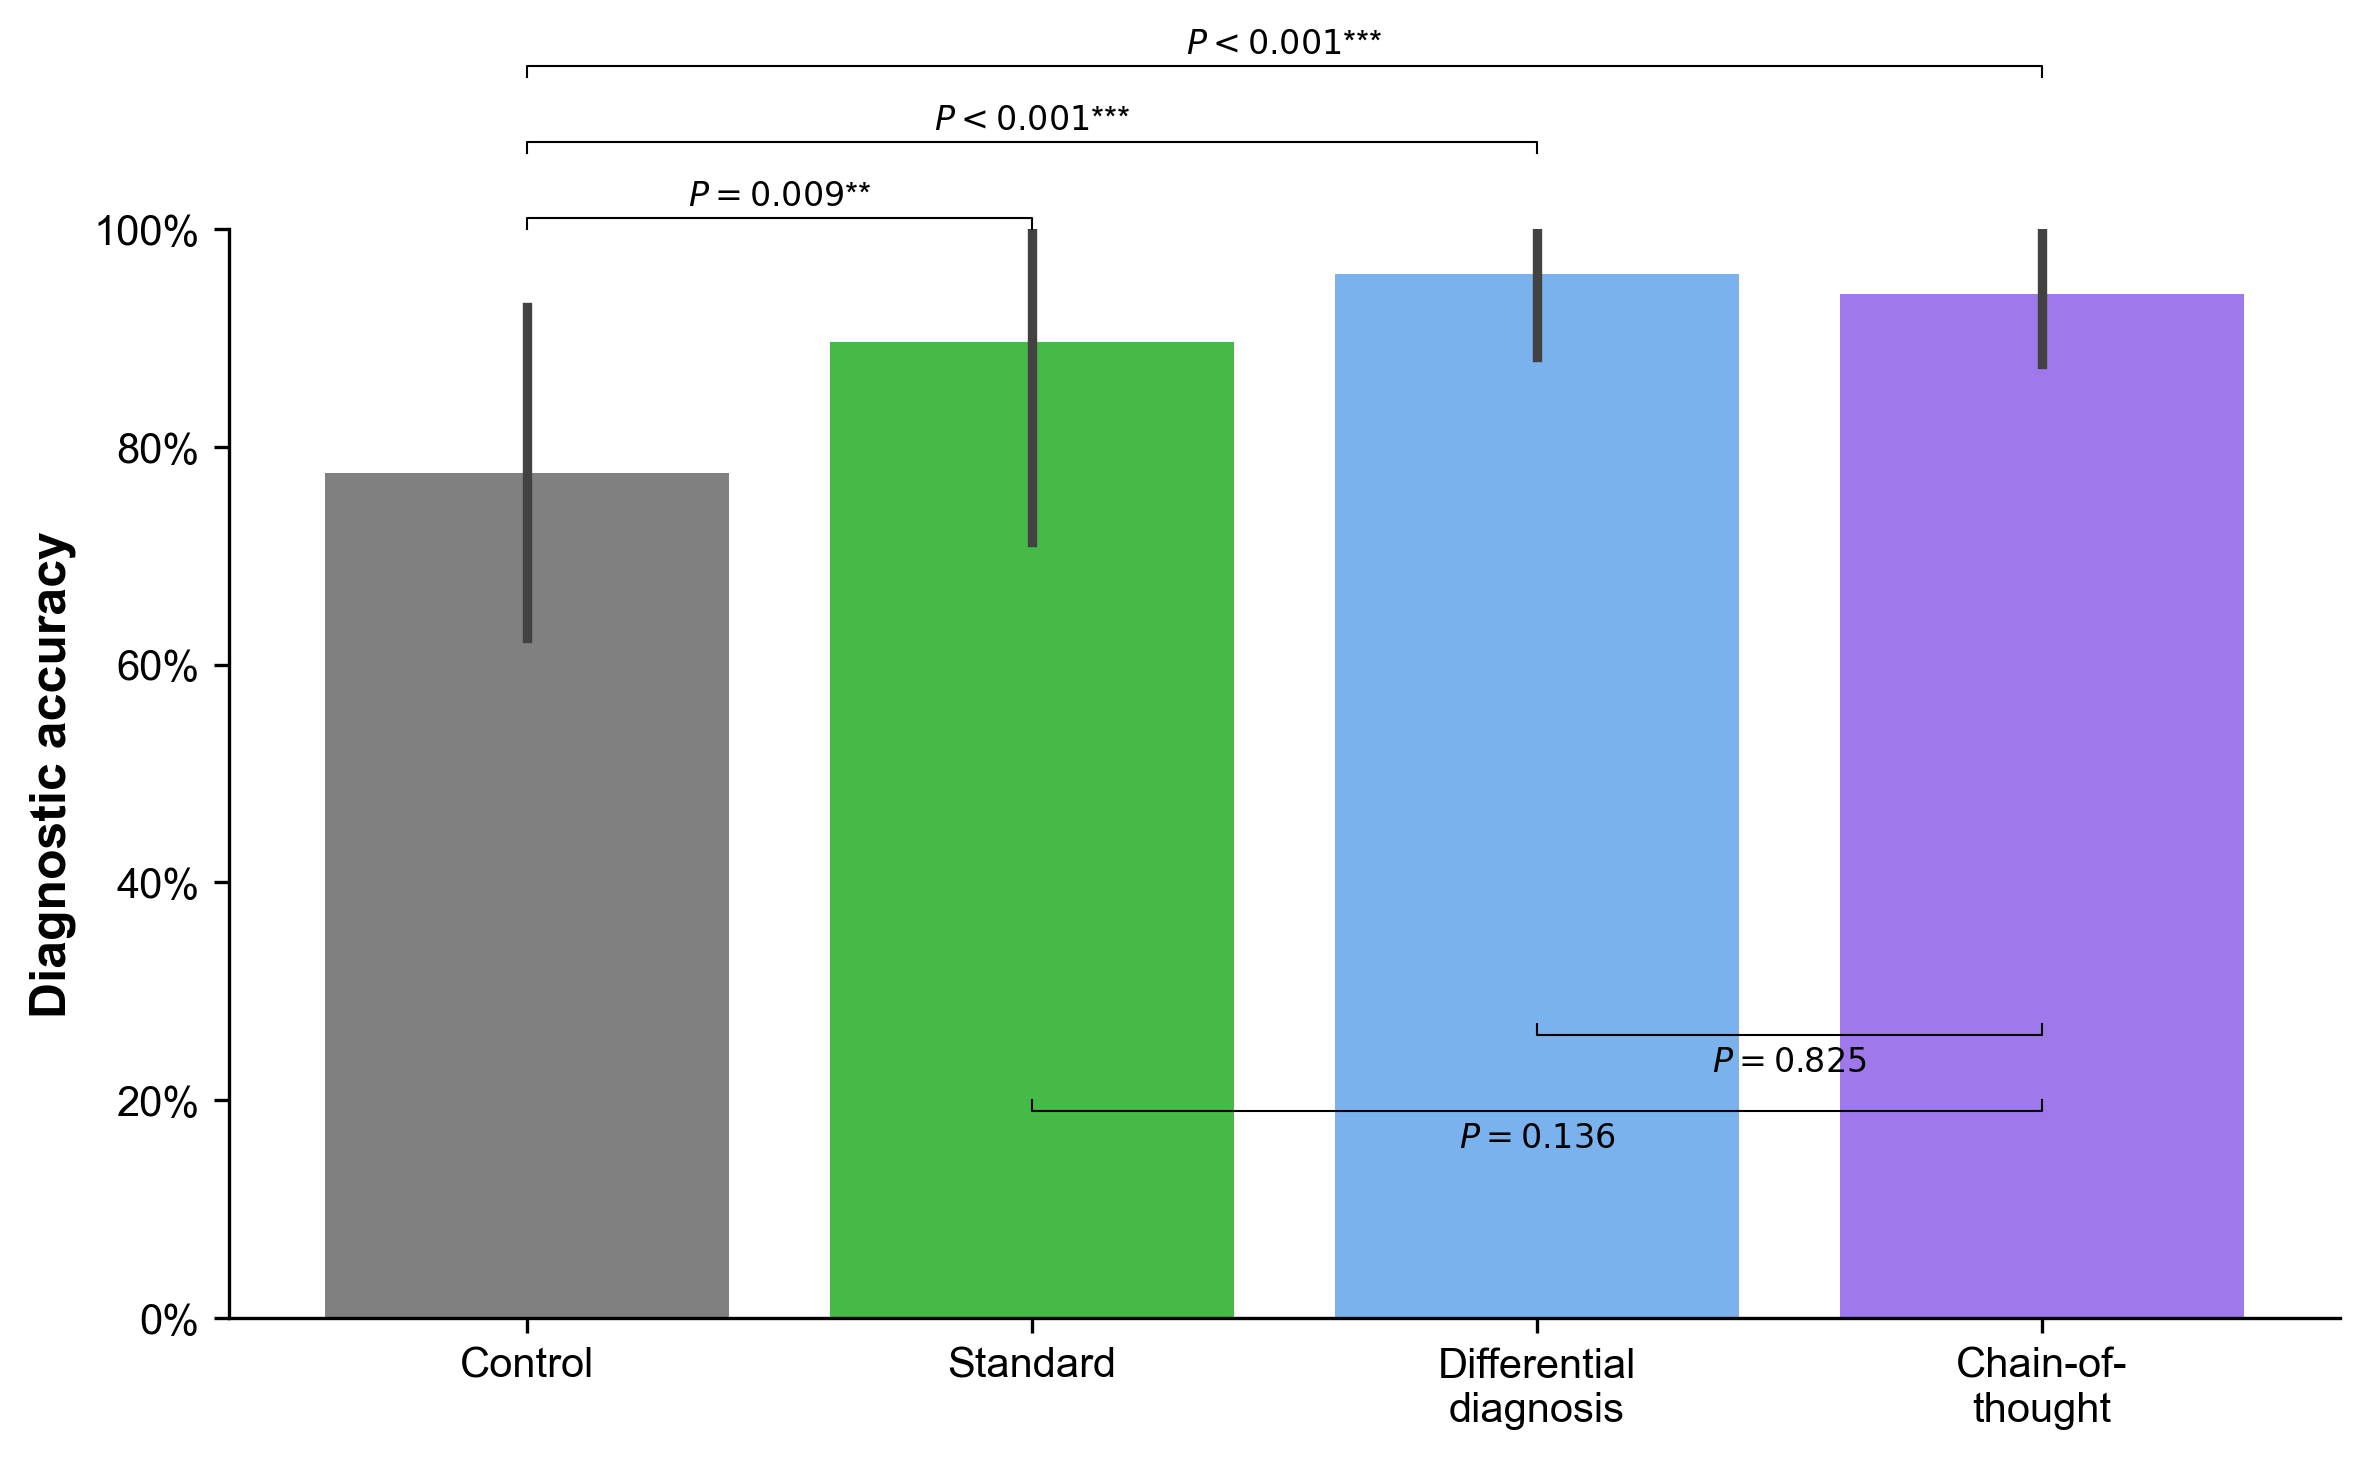

In [169]:
control_performance = df_subset_equal_correctness.query('condition == "control"')['correctness'].to_list()
standard_performance = df_subset_equal_correctness.query('condition == "standard"')['correctness'].to_list()
cot_performance = df_subset_equal_correctness.query('condition == "chain-of-thought"')['correctness'].to_list()
dd_performance = df_subset_equal_correctness.query('condition == "differential"')['correctness'].to_list()

p_values = {
    ('control', 'standard'): one_sided_ttest(control_performance, standard_performance),
    ('control', 'differential'): one_sided_ttest(control_performance, dd_performance),
    ('control', 'chain-of-thought'): one_sided_ttest(control_performance, cot_performance),
    ('standard', 'chain-of-thought'): one_sided_ttest(standard_performance, cot_performance),
    ('differential', 'chain-of-thought'): one_sided_ttest(dd_performance, cot_performance),
}

# select data and create plot
fig, ax = plt.subplots(1,1, figsize=(8,5))
box = sns.barplot(data=df_subset_equal_correctness, x='condition', y='correctness', order=order, hue='condition', hue_order=order, ax=ax, errorbar='sd',
                  #showmeans=True, meanprops={'marker':'o','markerfacecolor':'white','markeredgecolor':'black','markersize':'8'}
                  )
# vio = sns.violinplot(data=df_subset_equal_correctness, x='condition', y='correctness',alpha=0.5, hue='condition', hue_order=order, order=order, ax=ax, inner='point', cut=0)
for violin in vio.collections: violin.set_alpha(0.5) 
format_labs(xlab='',ylab='Diagnostic accuracy',ylim=(0,1),perc=1)
annotate_tests(p_values=p_values,order=order,ymax=1)

# Show and save plot
plt.tight_layout()
save_plot(f'performance_equal_acc')

In [170]:
# in percentage points
(df_subset_equal_correctness.groupby('condition')['correctness'].mean()* 100).round(2)

condition
control             77.60
standard            89.58
differential        95.83
chain-of-thought    94.02
Name: correctness, dtype: float64

In [171]:
model = fit(df_subset_equal_correctness,'correctness','condition')
print(model.summary())

#save_tex(fn='OLS regression of diagnostic accuracy on conditions including only cases that were equally correct between treaments from both diagnosis and explanation', model=model, caption='OLS regression of diagnostic accuracy on conditions including only cases that were equally correct between treaments from both diagnosis and explanation. The intercept coefficient is 0.776 with a P-value of < 0.001 and a 95\% confidence interval of [0.725; 0.827]. The standard intervention arm has a coefficient of 0.120, a P-value of 0.001, and a confidence interval of [0.047; 0.192]. The differential diagnosis intervention arm shows a coefficient of 0.182, a P-value of < 0.001, and a confidence interval of [0.113; 0.251]. The chain-of-thought intervention arm has a coefficient of 0.164, a P-value of < 0.001, and a confidence interval of [0.091; 0.238].')

                            OLS Regression Results                            
Dep. Variable:            correctness   R-squared:                       0.246
Model:                            OLS   Adj. R-squared:                  0.222
Method:                 Least Squares   F-statistic:                     10.52
Date:                 Mo, 10 Mär 2025   Prob (F-statistic):           4.71e-06
Time:                        08:34:20   Log-Likelihood:                 67.366
No. Observations:                 101   AIC:                            -126.7
Df Residuals:                      97   BIC:                            -116.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [172]:
# Set 'chain-of-thought' as the reference category
df_subset_equal_correctness['condition'] = pd.Categorical(df_subset_equal_correctness['condition'], categories=['chain-of-thought', 'control', 'standard', 'differential'])

# Create the design matrix
#df_subset_equal_correctness = pd.get_dummies(df_subset_equal_correctness[['condition']], drop_first=True)
model = fit(df_subset_equal_correctness,'correctness','condition')
print(model.summary())

# Save the results to a LaTeX file
save_tex(fn='OLS regression of diagnostic accuracy on conditions including only cases that were equally correct between treaments from both diagnosis and explanation and cot as reference group',
         model=model, caption=r'\textbf{OLS regression of diagnostic accuracy on conditions including only cases that were equally correct between treatments for both diagnosis and explanation.} The chain-of-thought explanations are set as the reference group. The intercept is estimated at 0.940 with a highly significant P-value (\(P < 0.001\)). The control group shows a significant negative effect (difference = -16.4 percentage points, \(95\%\) CI = \([-23.8, -9.1]\), \(P < 0.001\)). The standard group has a negative but non-significant effect (difference = -4.44 percentage points, \(95\%\) CI = \([-11.8, 2.9]\), \(P = 0.233\)). The differential diagnosis group has a positive but non-significant effect (difference = 1.8 percentage points, \(95\%\) CI = \([-5.2, 8.8]\), \(P = 0.607\)).')

                            OLS Regression Results                            
Dep. Variable:            correctness   R-squared:                       0.246
Model:                            OLS   Adj. R-squared:                  0.222
Method:                 Least Squares   F-statistic:                     10.52
Date:                 Mo, 10 Mär 2025   Prob (F-statistic):           4.71e-06
Time:                        08:34:20   Log-Likelihood:                 67.366
No. Observations:                 101   AIC:                            -126.7
Df Residuals:                      97   BIC:                            -116.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0

In [173]:
df_subset_equal_correctness.head()

correctness  task-load  usefulness  ease-of-use      trust  \
ResponseId                                                                      
R_10vjyyr8j51riwX        0.875  50.000000   69.444444    66.666667        NaN   
R_1CE2eg81xyyBnNy        0.625  50.000000         NaN          NaN        NaN   
R_1CsZuXiqwalCXnP        0.875  20.000000   66.666667    83.333333        NaN   
R_1D6DTqOxDt0JFsE        1.000   6.666667   91.666667    75.000000        NaN   
R_1Hudm1jX6HBh0qg        0.625  33.333333   91.666667    86.111111  52.777778   

                      condition           StartDate             EndDate  \
ResponseId                                                                
R_10vjyyr8j51riwX  differential 2024-11-23 21:07:26 2024-11-23 21:30:34   
R_1CE2eg81xyyBnNy       control 2024-11-28 05:05:55 2024-11-28 05:17:38   
R_1CsZuXiqwalCXnP      standard 2024-11-24 15:55:16 2024-11-24 16:43:26   
R_1D6DTqOxDt0JFsE  differential 2024-11-22 17:35:49 2024-11-22 18:02:03   
R_1Hudm1jX6HBh0qg      standard 2024-11-30 01:08:58 2024-11-30 01:21:35   

                   Status      IPAddress  ...  t_dd11  t_dd12  t_dd13  t_dd14  \
ResponseId                                ...                                   
R_10vjyyr8j51riwX       0    73.76.76.59  ...   68955   48491   76403  154022   
R_1CE2eg81xyyBnNy       0   73.245.79.36  ...       0       0       0       0   
R_1CsZuXiqwalCXnP       0  104.28.57.239  ...       0       0       0       0   
R_1D6DTqOxDt0JFsE       0  128.23.128.10  ...   40890   35275   73245  324137   
R_1Hudm1jX6HBh0qg       0  69.125.48.110  ...       0       0       0       0   

                   t_dd15  t_dd16  t_dd17  t_dd18  t_dd19  t_dd20  
ResponseId                                                         
R_10vjyyr8j51riwX   42699   22213  117917   32680   80499   24215  
R_1CE2eg81xyyBnNy       0       0       0       0       0       0  
R_1CsZuXiqwalCXnP       0       0       0       0       0       0  
R_1D6DTqOxDt0JFsE   53364   32760   63783   29455   43602   15992  
R_1Hudm1jX6HBh0qg       0       0       0       0       0       0  

[5 rows x 603 columns]

# Robustness Check: Controlling for explanation and diagnosis correcteness of the LLM

In [174]:
df_treated = df[df.condition != 'control']
assert all(df_treated['Explanation correctness'].notna())

df_treated[['Explanation correctness','Diagnosis correctness']] = df_treated[['Explanation correctness','Diagnosis correctness']] \
    .replace({'Yes':1,'No':0})

df_treated = df_treated.rename(columns={'Explanation correctness':'Correct Explanation ($True = 1$)',
                                       'Diagnosis correctness': 'Correct Diagnosis ($True = 1$)'})

df_treated['condition'] = pd.Categorical(df_treated['condition'],['chain-of-thought','standard','differential'])
controls = ['Correct Explanation ($True = 1$)', 'Correct Diagnosis ($True = 1$)']
df_encoded = pd.get_dummies(
    df_treated[target + treatment + controls].dropna(axis=0), 
    drop_first=True,)


In [175]:
df_treated.condition.value_counts()

condition
differential        600
standard            480
chain-of-thought    460
Name: count, dtype: int64

In [176]:

# change order of columns 
first_cols = df_encoded[['condition_standard','condition_differential',]]
df_encoded.drop(['condition_standard','condition_differential'], axis=1,inplace=True)
df_encoded = pd.concat([first_cols,df_encoded],axis=1)

X = sm.add_constant(df_encoded.drop('correctness',axis=1)).astype(float)
Y = df_encoded['correctness'].round()

model = sm.Logit(Y, X).fit()
odds_ratios = np.exp(model.params)
print("Odds Ratios: ", odds_ratios)
print(model.summary())
save_tex(fn='Logistic regression of diagnostic accuracy on conditions and correctness diagnosis and explanations from the LLM',model=model,
         caption=r'\textbf{Logistic regression of diagnostic accuracy on conditions and correctness of diagnosis and explanations from the LLM.} The differential diagnosis is considered correct if the correct diagnosis is one of the five presented options. The intercept log-odds is estimated at -0.619 with a significant $P$-value ($P < 0.001$). The standard group has a negative and non-significant effect (coef = -0.504, \(95\%\) CI = \([-0.914, -0.094]\), \(P = 0.016\)). The differential diagnosis group has a negative significant effect (coef = -1.014, \(95\%\) CI = \([-1.383, -0.646]\), \(P < 0.001\)).')

Optimization terminated successfully.
         Current function value: 0.406846
         Iterations 6
Odds Ratios:  const                                  0.538322
condition_standard                     0.604120
condition_differential                 0.362754
Correct Explanation ($True = 1$)_1     1.586516
Correct Diagnosis ($True = 1$)_1      18.177880
dtype: float64
                           Logit Regression Results                           
Dep. Variable:            correctness   No. Observations:                 1540
Model:                          Logit   Df Residuals:                     1535
Method:                           MLE   Df Model:                            4
Date:                 Mo, 10 Mär 2025   Pseudo R-squ.:                  0.2846
Time:                        08:34:20   Log-Likelihood:                -626.54
converged:                       True   LL-Null:                       -875.74
Covariance Type:            nonrobust   LLR p-value:                1.485e-1

# LLM comparison

In [177]:
advice_df.columns

Index(['question', 'Image information in text', 'Rank of Correct Diagnosis',
       'differential diagnosis correct', 'differential explanation correct',
       'chain-of-thought diagnosis correct',
       'chain-of-thought explanation correct', 'standard diagnosis correct',
       'standard explanation correct', 'vignette-length',
       'differential advice length', 'chain-of-thought advice length',
       'standard advice length'],
      dtype='object')

In [178]:
claude_perf_df = pd.read_excel('../Data/Claude_output_reviews.xlsx',index_col='id')
map_cols = {
 'STD_diagnosis_correct': 'standard diagnosis correct', 
 'STD_explanation_correct': 'standard explanation correct', 
 'COT_diagnosis_correct': 'chain-of-thought diagnosis correct',
 'COT_explanation_correct': 'chain-of-thought explanation correct', 
 'DD_diagnosis_correct': 'differential diagnosis correct',
 'DD_explanation_correct': 'differential explanation correct',
}

claude_perf_df = claude_perf_df.rename(columns=map_cols)
for col in map_cols.values():
    claude_perf_df[col] = claude_perf_df[col].map(lambda o: 'No' if 'partial' in o.lower() else 'No' if 'no' in o.lower() else 'Yes')
claude_perf_df['question'] = claude_perf_df.case.map({v:k for k,v in TASKS.items()})
claude_perf_df = claude_perf_df[['question']+list(map_cols.values())]
claude_perf_df = claude_perf_df.melt(id_vars='question',value_name='Correctness',var_name='aspect')

claude_perf_df['condition'] = claude_perf_df['aspect'].apply(lambda o: 'standard' if 'standard' in o else 'differential' if 'differential' in o else 'chain-of-thought')
claude_perf_df['aspect'] = claude_perf_df['aspect'].apply(lambda o: 'diagnosis' if 'diagnosis' in o else 'explanation')
claude_perf_df['model'] = 'Claude'

explanation_df['aspect'] = 'explanation'
explanation_df = explanation_df.rename(columns={'Explanation correctness': 'Correctness'})
diagnosis_df = diagnosis_df.rename(columns={'Diagnosis correctness': 'Correctness'})
diagnosis_df['aspect'] = 'diagnosis'

gpt_perf_df = pd.concat([diagnosis_df,explanation_df],axis=0)
gpt_perf_df['model'] = 'GPT-4'

llm_perf_df = pd.concat([claude_perf_df,gpt_perf_df],axis=0)
llm_perf_df['Correctness'] = llm_perf_df['Correctness'].map({'No': 0, 'Yes': 1})


In [179]:
llm_perf_df[(llm_perf_df.aspect == 'diagnosis') & 
            (llm_perf_df.model == 'GPT-4') & 
            (llm_perf_df.condition == 'differential')]

question     aspect  Correctness     condition  model
0    question_1  diagnosis            1  differential  GPT-4
1    question_2  diagnosis            1  differential  GPT-4
2    question_3  diagnosis            1  differential  GPT-4
3    question_4  diagnosis            1  differential  GPT-4
4    question_5  diagnosis            1  differential  GPT-4
5    question_6  diagnosis            1  differential  GPT-4
6    question_7  diagnosis            0  differential  GPT-4
7    question_8  diagnosis            0  differential  GPT-4
8    question_9  diagnosis            1  differential  GPT-4
9   question_10  diagnosis            1  differential  GPT-4
10  question_11  diagnosis            1  differential  GPT-4
11  question_12  diagnosis            1  differential  GPT-4
12  question_13  diagnosis            1  differential  GPT-4
13  question_14  diagnosis            1  differential  GPT-4
14  question_15  diagnosis            0  differential  GPT-4
15  question_16  diagnosis            1  differential  GPT-4
16  question_17  diagnosis            1  differential  GPT-4
17  question_18  diagnosis            1  differential  GPT-4
18  question_19  diagnosis            0  differential  GPT-4
19  question_20  diagnosis            1  differential  GPT-4

In [180]:
pd.DataFrame(data).query("condition == 'differential_diagnosis'")

performance               condition  task_number
20            1  differential_diagnosis            1
21            1  differential_diagnosis            2
22            1  differential_diagnosis            3
23            1  differential_diagnosis            4
24            1  differential_diagnosis            5
25            1  differential_diagnosis            6
26            0  differential_diagnosis            7
27            0  differential_diagnosis            8
28            1  differential_diagnosis            9
29            1  differential_diagnosis           10
30            1  differential_diagnosis           11
31            1  differential_diagnosis           12
32            1  differential_diagnosis           13
33            1  differential_diagnosis           14
34            0  differential_diagnosis           15
35            1  differential_diagnosis           16
36            1  differential_diagnosis           17
37            1  differential_diagnosis           18
38            0  differential_diagnosis           19
39            1  differential_diagnosis           20

In [181]:
llm_perf_df.groupby(['aspect', 'model', 'condition'])['Correctness'].mean()

aspect       model   condition       
diagnosis    Claude  chain-of-thought    0.65
                     differential        0.75
                     standard            0.65
             GPT-4   chain-of-thought    0.80
                     differential        0.80
                     standard            0.75
explanation  Claude  chain-of-thought    0.80
                     differential        0.75
                     standard            0.85
             GPT-4   chain-of-thought    0.40
                     differential        0.55
                     standard            0.75
Name: Correctness, dtype: float64

In [182]:
llm_perf_df

question       aspect  Correctness condition   model
0    question_1    diagnosis            0  standard  Claude
1    question_2    diagnosis            1  standard  Claude
2    question_3    diagnosis            0  standard  Claude
3    question_4    diagnosis            1  standard  Claude
4    question_5    diagnosis            1  standard  Claude
..          ...          ...          ...       ...     ...
55  question_16  explanation            1  standard   GPT-4
56  question_17  explanation            1  standard   GPT-4
57  question_18  explanation            1  standard   GPT-4
58  question_19  explanation            1  standard   GPT-4
59  question_20  explanation            1  standard   GPT-4

[240 rows x 5 columns]

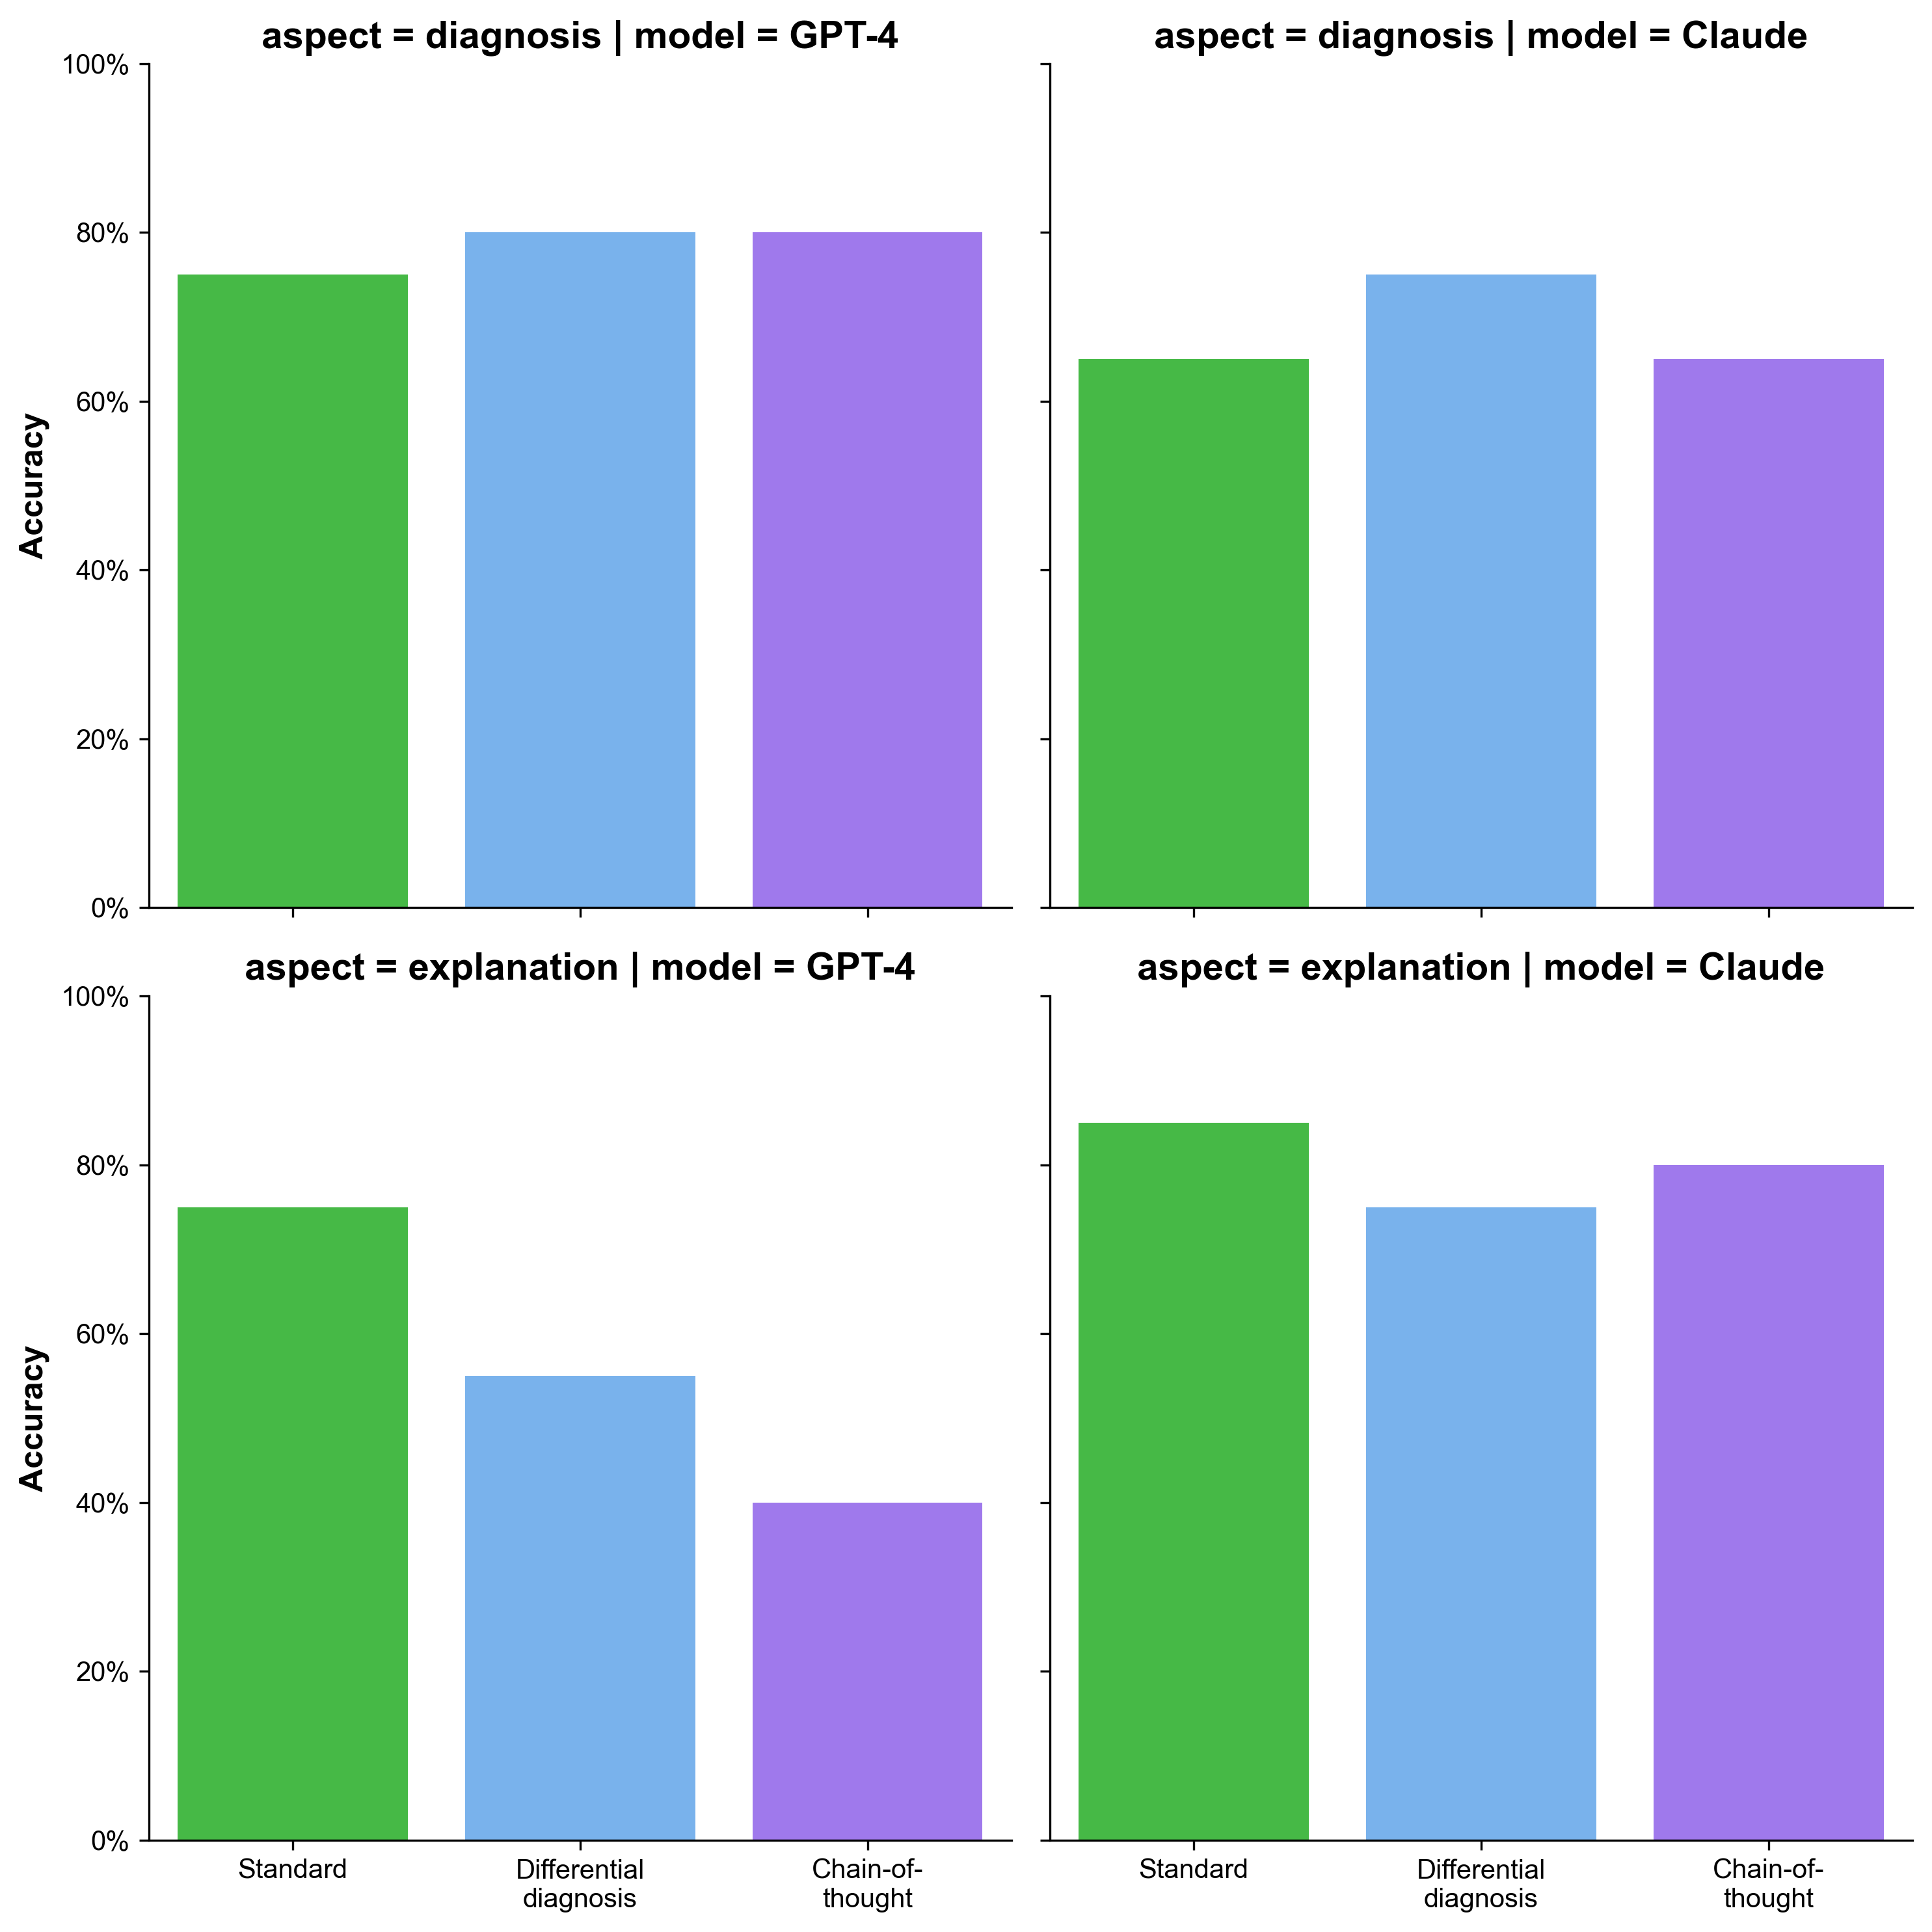

In [183]:
g = sns.FacetGrid(llm_perf_df, col='model', row='aspect', hue='condition', height=5, margin_titles=False, col_order=['GPT-4','Claude'])
g.set_titles(size=14, weight='bold')
g.map(sns.barplot, 'condition', 'Correctness', order=order[1:], palette=pal, ci=None, )
g.set_axis_labels("", "Accuracy")
format_labs(perc=1, ylim=(0,1))

# for ax in g.axes.flat:
#     for p in ax.patches:
#         height = p.get_height() - 0.1
#         # Filter the dataframe by the axis' condition on aspect and model
#         model = ax.get_title().split(' | ')[1].split('=')[1].strip()
#         aspect = ax.get_title().split(' | ')[0].split('=')[1].strip()
#         # import pdb; pdb.set_trace()
#         filtered_df = llm_perf_df[(llm_perf_df['model'] == model) & (llm_perf_df['aspect'] == aspect)]
        
#         # Calculate the sample size
#         sample_size = len(filtered_df)
        
#         # Annotate the bar with the sample size
#         ax.annotate(f'$n = {sample_size}$', 
#                 (p.get_x() + p.get_width() / 2., height), 
#                 ha='center', va='baseline', fontsize=10, color='white', xytext=(0, 1), 
#                 textcoords='offset points')
        
plt.tight_layout()    

try:
    g.savefig(f'../Results/Plots/performance_model_comparison.pdf')
except FileNotFoundError:
    warnings.warn('Create "../Results/Plots folder" to save figure files')

In [184]:
diagnosis_df.Correctness = diagnosis_df.Correctness.map({'Yes':1,'No':0})
diagnosis_df.groupby(['aspect','condition']).agg({'Correctness': 'mean'})

Correctness
aspect    condition                    
diagnosis chain-of-thought         0.80
          differential             0.80
          standard                 0.75

In [185]:
from sklearn.metrics import cohen_kappa_score
from scipy.stats import norm

def interrater_reliability(rater1, rater2):
    kappa = cohen_kappa_score(rater1, rater2)
    conf_matrix = pd.crosstab(pd.Series(rater1), pd.Series(rater2)).to_numpy()
    obs_agree = np.trace(conf_matrix) / np.sum(conf_matrix)

    row_totals = conf_matrix.sum(axis=1)
    col_totals = conf_matrix.sum(axis=0)
    total = np.sum(conf_matrix)

    exp_agree = np.sum((row_totals * col_totals)) / (total ** 2)
    assert exp_agree != 0
    std_error = np.sqrt((obs_agree * (1 - obs_agree)) / (total * (1 - exp_agree) ** 2))
    z_score = kappa / std_error
    p_value = 2 * (1 - norm.cdf(abs(z_score)))

    confidence_level = 0.95
    z_critical = norm.ppf(1 - (1 - confidence_level) / 2)
    lower_bound, upper_bound = kappa - (z_critical * std_error), kappa + (z_critical * std_error)

    print(f"Cohen's Kappa: {kappa:.4f}")
    print(f"{confidence_level*100}% Confidence Interval: [{lower_bound:.4f}, {upper_bound:.4f}]" if not np.isnan(std_error) else "Confidence Interval: Undefined")
    print(f"P-value: {p_value:.4f}" if not np.isnan(p_value) else "P-value: Undefined")

In [186]:
for a in ['diagnosis','explanation']:
    gpt = llm_perf_df[(llm_perf_df.aspect == a) & (llm_perf_df.model == 'GPT-4')]['Correctness']
    claude = llm_perf_df[(llm_perf_df.aspect == a) & (llm_perf_df.model == 'Claude')]['Correctness']

    # kappa = cohen_kappa_score(gpt, claude)
    # print(f"Cohen's Kappa for {a}: {kappa:.3f}")
    interrater_reliability(gpt, claude)

# gpt = llm_perf_df[(llm_perf_df.model == 'GPT-4')]['Correctness']
# claude = llm_perf_df[(llm_perf_df.model == 'Claude')]['Correctness']

# kappa = cohen_kappa_score(gpt, claude)
# print(f"Cohen's Kappa: {kappa:.3f}", )

Cohen's Kappa: 0.2426
95.0% Confidence Interval: [-0.0888, 0.5741]
P-value: 0.1513
Cohen's Kappa: 0.3478
95.0% Confidence Interval: [-0.0347, 0.7303]
P-value: 0.0747


# Consolidate text outputs

In [187]:
consolidate_tex(add_header=False)

Demographics of study sample by condtion.tex
LLM performance comparison.tex
OLS regression of diagnostic accuracy on conditions.tex
OLS regression of diagnostic accuracy on conditions with CoT as baseline.tex
Regression on participant level of diagnostic acucracy on conditions with control for personal factors.tex
Regression on participant level of diagnostic acucracy on conditions with control for study factors.tex
OLS regression for subgroup with low IT skills.tex
OLS regression for subgroup with high IT skills.tex
OLS regression for subgroup with low medical experience.tex
OLS regression for subgroup with high medical experience.tex
OLS regression for basic patient cases.tex
OLS regression for complex patient cases.tex
OLS regression of winsorized diagnostic accuracy on conditions.tex
Mixed effects model.tex
Quasi-binomial model.tex
OLS regression of time per case on conditions.tex
OLS regression of time per case on conditions and standard as control.tex
OLS regression of adherence 